<a href="https://colab.research.google.com/github/syongu/Pitch_type_prediction/blob/main/Sprint3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 3


In Sprint 2, we established the baseline model. However, the model is not functioning well due to class imbalance.

This notebook will follow the below workflow:
- Data Cleaning and Processing with slight difference with Sprint 2
- Data Exploration on updated Dataset
- Baseline Trail Model on Justin Valender
- Baseline Model with entire dataset
- Review on Baseline Models
- Final model on Zone prediction
- Final model on Pitch Type prediction
- Product Demo Deployment
- Discussion and Limitation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
#pd.options.mode.chained_assignment = None  # default='warn'

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
from google.colab import drive
drive.mount('/mnt/drive')

Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


## Loading Dataset and Module

In [ ]:
data_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/pitches.csv')
data_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_pitches.csv')
game_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/games.csv')
game_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_games.csv')
ab_2018 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/atbats.csv')
ab_2019 = pd.read_csv('/mnt/drive/MyDrive/capstone_data/2019_atbats.csv')
name_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/player_names.csv')

In [ ]:
pitch_df = pd.concat([data_2018, data_2019])
game_df = pd.concat([game_2018, game_2019])
ab_df = pd.concat([ab_2018, ab_2019])
abdata = pitch_df.merge(ab_df, on = "ab_id")
gamedata = abdata.merge(game_df, on = 'g_id')
gamedata1 =pd.merge(gamedata, name_df, left_on='batter_id', right_on='id', how = 'left')

We are removing below columns:
- spin and break: These data are summarized after the pitch is thrown and mostly used for analyzing pitch quality.
- type of confidence: This data shows how likely the pitch type is correct. However, there's too many missing value and it's difficult to interpret the value.
- ax, ay, az:
- vx/y/z, x0/y0/z0, pfx_x/z: These data shows the movement of the throw. We are only interested at the end result.
- event/umpire/other: These data are irrelevant to pitching in this study.

In [ ]:
gamedata1 = gamedata1.drop(columns=['spin_rate', 'spin_rate','spin_dir','break_angle','break_length','break_y'])
gamedata1 = gamedata1.drop(columns=['ax', 'ay','az'])
gamedata1 = gamedata1.drop(columns=['type_confidence'])
gamedata1 = gamedata1.drop(columns=['vx0', 'vy0','vz0','x','x0','y', 'y0','z0','pfx_x','pfx_z'])
gamedata1 = gamedata1.drop(columns=['event_num', 'away_final_score','away_team','date','elapsed_time','home_final_score', 'home_team','start_time'])
gamedata1 = gamedata1.drop(columns=['umpire_1B', 'umpire_2B','umpire_3B','umpire_HP','venue_name','delay', 'id','first_name','last_name'])

## Feature Engineering

### Feature Engineering on Pitch Count

#### Spliting dataframe to top and bottom innings

Because teams switch fielding positions by half innings, splitting the dataframe by top and bottom innings makes sure that we can process the pitching of the same team in one cluster later on.

In [ ]:
gamedata1['top'].value_counts()

,count
top,
1.0,1831115
0.0,1764829


In [ ]:
top_ins = gamedata1[gamedata1['top'] ==True]
bot_ins = gamedata1[gamedata1['top'] == False]

#### Pitch Count

Pitch count represents the game status of the current pitcher. First, pitchers get tired after repeatingly throwing. The more someone pitches, the more likely he will lose control or speed of his pitch due to fatigue. On the other hand, the hitter will observe the pitches throughout the game. When one pitcher makes adquate number of pitches, the hitter will "figure out" the pitcher's strategy as well as pitching mix .These leads to advantage for hitter and helps them to make a good hit.

Luckily, the dataframe is pitch-by-pitch record, which means games are grouped together with the pitch-by-pitch sequence. We will divide the dataframe to top innings and bottom innings, give pitch count to each row and update the original dataframe.


#### Generating Pitch Count for top innings (away team)

In [ ]:
#Initiate the pitch_count column
top_ins['pitch_count'] = 1

<ipython-input-257-4ef215ae57e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['pitch_count'] = 1


In [ ]:
count = 1
for i in range(len(top_ins)):
    if (top_ins['pitcher_id'].iloc[i] == top_ins['pitcher_id'].iloc[i-1]):
        count = count + 1 ## if the previous row and the current row is the same pitcher, add count
    else:
        count = 1
    top_ins.loc[top_ins.index[i], 'pitch_count'] = count

#### Generating Pitch Count for bottom innings (home team)

In [ ]:
bot_ins['pitch_count'] = 1

<ipython-input-259-5ced665786c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins['pitch_count'] = 1


In [ ]:
count = 1
for i in range(len(bot_ins)):
    if (bot_ins['pitcher_id'].iloc[i] == bot_ins['pitcher_id'].iloc[i-1]):
        count = count + 1
    else:
        count = 1
    bot_ins.loc[bot_ins.index[i], 'pitch_count'] = count

In [ ]:
bot_ins[['pitch_count','pitcher_id']][60:120]

,pitch_count,pitcher_id
134,61,425794
135,62,425794
136,63,425794
137,64,425794
138,65,425794
165,66,425794
166,67,425794
167,68,425794
168,69,425794
169,70,425794


#### Updating Pitch count to original dataframe

In [ ]:
gamedata1['pitch_count'] = 0
gamedata1.update(top_ins)
gamedata1.update(bot_ins)

### Removing Rows #1

After generating the pitch count, we can safely remove the rows containing N/A values so that the sequence of the pitches will not be disrupted.

However, because we intend to use Recurrent neural network to train the model, it won't be able to handle data when there's a missing data in the sequence.

For example, the RNN model will happily look at the data pitch 1 to pitch 5. But if the data of pitch 3 is missing and we removed this row, RNN model won't effectively analysis the sequence.

To avoid that, we will remove the pitching data of a pitcher in the whole game whose pitching data is missing even 1 pitch. We will not remove the data for the whole game as pitcher will rotate.

In [ ]:
na_pitch_data = gamedata1[gamedata1['pitch_type'].isna()]

na_pitch_list = na_pitch_data[['g_id','pitcher_id']].drop_duplicates()

The N/A cell number for px & pz is the same as pitch type, which hints the possibility that these are the same rows. We will drop N/A cells in column 'pitch_type' and remove more rows if necessary.

After that, we will list the game_id and pitcher_id that are missing pitch type data.

In [ ]:
na_pitch_list

,g_id,pitcher_id
344,201500002.00,450308
684,201500003.00,506693
1597,201500006.00,543359
2791,201500011.00,456501
4282,201500017.00,502009
...,...,...
3594502,201902404.00,642098
3594576,201902404.00,641793
3594897,201902405.00,544928
3595367,201902407.00,592662


In [ ]:
to_remove = gamedata1.merge(na_pitch_list, on=['g_id', 'pitcher_id'], how='inner')

# Remove these rows from the original DataFrame
gamedata_clean = gamedata1[~gamedata1.set_index(['g_id', 'pitcher_id']).index.isin(na_pitch_list.set_index(['g_id', 'pitcher_id']).index)]


In [ ]:
gamedata_clean.isna().sum()

,0
px,0
pz,0
start_speed,0
end_speed,0
sz_bot,0
sz_top,0
nasty,675488
zone,0
code,5616
type,0


After removing these data, px, pz and pitch type don't have N/A value anymore.

In [ ]:
gamedata_clean.shape

(3311559, 34)

##### Check placeholder

In Sprint1, we notice zone column has a value called 'placeholder'. Zone column are determined by px and pz. Both will serve as coordinates, and zone reprents the area on the strike zone map.

We will check if any other colomns contains this value. This will be dealt with later on.

In [ ]:
mask_placeholder = gamedata_clean.applymap(lambda x: 'placeholder' in str(x))

# Check which columns contain 'placeholder'
columns_with_placeholder = mask_placeholder.any()

print(columns_with_placeholder)

<ipython-input-268-43100cc09b11>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_placeholder = gamedata_clean.applymap(lambda x: 'placeholder' in str(x))


px             False
pz             False
start_speed    False
end_speed      False
sz_bot         False
sz_top         False
nasty          False
zone            True
code           False
type           False
pitch_type     False
b_score        False
ab_id          False
b_count        False
s_count        False
outs           False
pitch_num      False
on_1b          False
on_2b          False
on_3b          False
batter_id      False
event          False
g_id           False
inning         False
o              False
p_score        False
p_throws       False
pitcher_id     False
stand          False
top            False
attendance     False
weather        False
wind           False
pitch_count    False
dtype: bool


### * **New** * Class Imbalance on Pitch Type

In Sprint 2, we found fastball accounts for ~60% of the total pitches. This is causing a big issue for the modeling. To overcome this, we will split fastball to four-seam fastball and other types of fastball.

For the very unique types of pitch, we will classify them as four-seam fastball because this is the most common type and almost everyone uses this type.

The result will be:
- Four-Seam Fastball & Other
- Other Fastball
- Breaking ball
- Off-speed

In [ ]:
dictionary_pitch = {'CH':'Off-speed',
                'CU':'Breaking',
                'EP':'Off-speed',
                'FC':'Fastball',
                'FF':'Four-Seam Fastball',
                'FO':'Four-Seam Fastball',
                'FS':'Off-speed',
                'FT':'Fastball',
                'IN':'Off-speed',
                'KC':'Breaking',
                'KN':'Breaking',
                'PO':'Four-Seam Fastball',
                'SC':'Breaking',
                'SI':'Fastball',
                'SL':'Breaking',
                'UN':'Four-Seam Fastball',
                'FA':'Four-Seam Fastball',
                'AB':'Four-Seam Fastball'
                }

In [ ]:
# Update Pitch Type to simplified version
simple_pitch_types = [dictionary_pitch[pitch_type] for pitch_type in gamedata_clean['pitch_type']]
gamedata_clean['simple_pitch_type'] = simple_pitch_types

<ipython-input-270-799c29b74e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_pitch_type'] = simple_pitch_types


<Axes: xlabel='simple_pitch_type'>

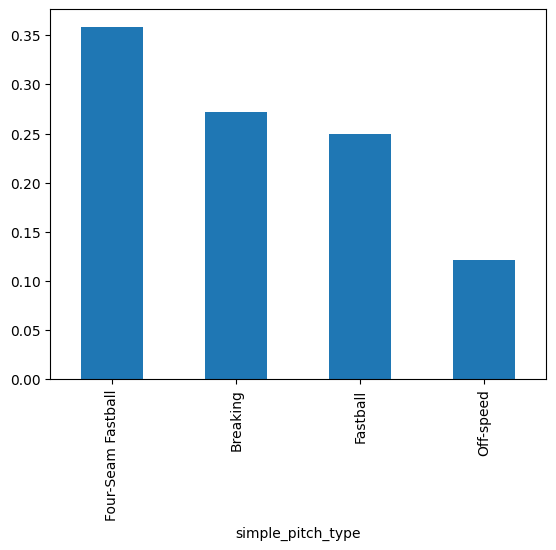

In [ ]:
# Update Simplified Pitch Type
pitch_type_counts = gamedata_clean['simple_pitch_type'].value_counts(normalize = True)
pitch_type_counts.plot(kind='bar')

The classes looks much balanced. The only concern is that off-speed pitches only accounts for ~12% of the total pitches, 3 times less than the four-seams. We have to use techniques to address this mild imbalance when training our models.

### * **New** * Class Imbalance on Zones

As mentioned in Sprint 2, we also find class imbalance on Zone numbers. We will check the overall distribution, replace "placeholder", check the distribution again.

#### Strike zone number

First, we shall check the actual boundary of the strike zone from the dataset.

Previously we assume the strike zone is 1.54 inch wide and height between sz_top and sz_bot, which means -0.77<= px <= 0.77, sz_bot<=pz<=sz_top.  

##### The maximum size of the strike pitch area

In [ ]:
max_px = gamedata_clean[gamedata_clean['type'] == 'C']['px'].max()
min_px = gamedata_clean[gamedata_clean['type'] == 'C']['px'].min()
max_pz = gamedata_clean[gamedata_clean['type'] == 'C']['pz'].max()
min_pz = gamedata_clean[gamedata_clean['type'] == 'C']['pz'].min()
sz_top_avg = gamedata_clean['sz_top'].mean()
sz_bot_avg = gamedata_clean['sz_bot'].mean()

We only look at the pitches that are "calle strike", which means the home plate umpire ruled as strike. It's often that players try to hit a bad pitch, causing a swing strike. Thus we will ignore the swing strike when determining the strike pitch area.

In [ ]:
print("For a strike pitch:")
print(f'max_px: {max_px}')
print(f'min_px: {min_px}')
print(f'max_pz: {max_pz}')
print(f'min_pz: {min_pz}')
print(f'average sz_top: {sz_top_avg}')
print(f'average sz_bot: {sz_bot_avg}')

For a strike pitch:
max_px: 1.38
min_px: -1.39
max_pz: 4.02
min_pz: 0.93
average sz_top: 3.4225425851026743
average sz_bot: 1.5744443626444826


It turns out the imaginated strike zone from home plate umpire's view is bigger than the theoretical one. Human makes mistakes. We will check the boundry of the outside zones instead.

##### Strike pitch area size based on existing data

In [ ]:
#Left Boundary
min_px_1 = gamedata_clean[gamedata_clean['zone'] == 1]['px'].min()
min_px_4 = gamedata_clean[gamedata_clean['zone'] == 4]['px'].min()
min_px_7 = gamedata_clean[gamedata_clean['zone'] == 7]['px'].min()
print(f'left boundary of zone1 (px): {min_px_1}')
print(f'left boundary of zone4 (px): {min_px_4}')
print(f'left boundary of zone7 (px):: {min_px_7}')

left boundary of zone1 (px): -0.708329920387346
left boundary of zone4 (px): -0.708329392716526
left boundary of zone7 (px):: -0.708316498975968


In [ ]:
#Right Boundary
max_px_3 = gamedata_clean[gamedata_clean['zone'] == 3]['px'].max()
max_px_6 = gamedata_clean[gamedata_clean['zone'] == 6]['px'].max()
max_px_9 = gamedata_clean[gamedata_clean['zone'] == 9]['px'].max()
print(f'right boundary of zone3 (px): {max_px_3}')
print(f'right boundary of zone6 (px): {max_px_6}')
print(f'right boundary of zone9 (px):: {max_px_9}')

right boundary of zone3 (px): 0.708323024086472
right boundary of zone6 (px): 0.708327440424
right boundary of zone9 (px):: 0.7083330084601


The left boundary and right boundary of a strike looks very consistent. When a ball is in zone 1-9, it will land between -0.7<px<0.7.

In [ ]:
#Top Boundary
max_pz_1 = gamedata_clean[gamedata_clean['zone'] == 1]['pz'].max()
max_pz_2 = gamedata_clean[gamedata_clean['zone'] == 2]['pz'].max()
max_pz_3 = gamedata_clean[gamedata_clean['zone'] == 3]['pz'].max()
print(f'top boundary of zone1 (pz): {max_pz_1}')
print(f'top boundary of zone2 (pz): {max_pz_2}')
print(f'top boundary of zone3 (pz): {max_pz_3}')

top boundary of zone1 (px): 4.067
top boundary of zone2 (px): 4.02654247755424
top boundary of zone3 (px): 4.1094441934


In [ ]:
min_pz_7 = gamedata_clean[gamedata_clean['zone'] == 7]['pz'].min()
min_pz_8 = gamedata_clean[gamedata_clean['zone'] == 8]['pz'].min()
min_pz_9 = gamedata_clean[gamedata_clean['zone'] == 9]['pz'].min()
print(f'bottom boundary of zone7 (pz): {min_pz_7}')
print(f'bottom boundary of zone8 (pz): {min_pz_8}')
print(f'bottom boundary of zone9 (pz): {min_pz_9}')

bottom boundary of zone7 (px): -0.608897115499727
bottom boundary of zone8 (px): 0.33
bottom boundary of zone9 (px): 0.52947272835962


It's clear that the strike zone should be 1.4 inch wide. But the height is ambigious. The high boundary looks to be at 4.067, but the low boundary is interesting. We will look at pz in details.

###### Evaluation on pz

In theory, a strike is called when ball is lower than hitter's shoulder height. So if pz < sz_top, it should be good. Let's filter the data and see.

In [ ]:
higher_than_sz = gamedata_clean[(gamedata_clean['type'] == 'C')&(gamedata_clean['pz'] > gamedata_clean['sz_top'])][['px','pz','sz_top','sz_bot','zone']]

In [ ]:
higher_than_sz

,px,pz,sz_top,sz_bot,zone
2867513,0.26,3.47,3.39,1.57,placeholder
2868080,-0.11,3.25,3.10,1.45,placeholder
2868418,0.25,3.34,3.22,1.62,placeholder
2868809,0.40,3.55,3.17,1.53,placeholder
2869032,-0.24,3.22,3.16,1.44,placeholder
...,...,...,...,...,...
3595434,-0.30,3.61,3.37,1.66,placeholder
3595787,-0.76,3.33,3.31,1.53,placeholder
3595791,0.19,3.23,3.12,1.48,placeholder
3595902,0.01,3.55,3.33,1.47,placeholder


3937 balls are called strike even if it's higher than the top strike zone boundary.

In [ ]:
lower_than_sz = gamedata_clean[(gamedata_clean['type'] == 'C')&(gamedata_clean['pz'] < gamedata_clean['sz_bot'])][['px','pz','sz_top','sz_bot','zone']]

In [ ]:
lower_than_sz

,px,pz,sz_top,sz_bot,zone
2867248,0.89,1.74,3.58,1.84,placeholder
2867308,0.35,1.71,3.72,1.78,placeholder
2867505,-0.46,1.36,3.56,1.60,placeholder
2867507,-0.52,1.47,3.59,1.60,placeholder
2867566,0.02,1.55,3.62,1.57,placeholder
...,...,...,...,...,...
3594955,-0.08,1.31,3.09,1.40,placeholder
3595278,0.55,1.65,3.50,1.67,placeholder
3595338,0.71,1.59,3.54,1.77,placeholder
3595372,0.39,1.57,3.41,1.58,placeholder


7519 balls are called strike even if it's lower than the bottom strike zone boundary.

At first glance, looks like pz is just slightly over the edge or under the edge of the strike area. We can probably give it a "margin area of error". This is where teams always have conflict with umpires about.

We will quickly look how "bad" these calls are.


In [ ]:
higher_than_sz['diff'] = higher_than_sz['pz'] - higher_than_sz['sz_top']
lower_than_sz['diff'] = lower_than_sz['sz_bot'] - lower_than_sz['pz']
higher_than_sz['diff'].describe()


,diff
count,3937.00
mean,0.14
std,0.12
min,0.01
25%,0.05
50%,0.12
75%,0.21
max,0.69


In [ ]:
lower_than_sz['diff'].describe()

,diff
count,7519.00
mean,0.11
std,0.09
min,0.01
25%,0.04
50%,0.09
75%,0.15
max,0.72


There are certainly some bad calls. But we can tell that most of wrong judgements are close within one std. It's likely the ball is very close to the edge.

##### First Look at the Distribution of Pitches

<Axes: xlabel='zone'>

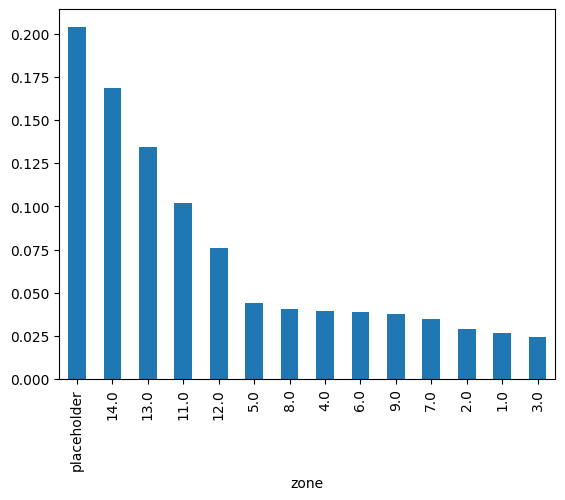

In [ ]:
zone_counts = gamedata_clean['zone'].value_counts(normalize = True)
zone_counts.plot(kind='bar')

As we can tell, zone 11-14 accounts for a lot of the portion, causing class imbalance. We will replace "placeholder" value and recheck

##### Update "placeholder" with zone number

In [ ]:
gamedata_clean[['zone','px','pz','type']][gamedata_clean['zone'] == 'placeholder']

,zone,px,pz,type
2867154,placeholder,0.00,2.15,X
2867155,placeholder,0.34,2.31,C
2867156,placeholder,-0.05,2.03,S
2867157,placeholder,0.49,0.92,B
2867158,placeholder,-0.13,1.11,B
...,...,...,...,...
3595939,placeholder,0.30,1.99,X
3595940,placeholder,1.00,-0.38,B
3595941,placeholder,0.36,2.02,C
3595942,placeholder,-0.26,2.60,C


In [ ]:
# Filter for placeholder cells
gamedata_clean_na = gamedata_clean[gamedata_clean['zone'] == 'placeholder']

In [ ]:
#mask for strike zone
px = gamedata_clean_na['px']
pz = gamedata_clean_na['pz']
sz_top = gamedata_clean_na['sz_top'] + 0.12 #some of the calls are off due to the "margin of error". We will add the mean of the difference to simulate real-life situations.
sz_bot = gamedata_clean_na['sz_bot'] - 0.09 #some of the calls are off due to the "margin of error". We will substract the mean of the difference to simulate real-life situations.
sz_bot_avg = gamedata_clean['sz_bot'].mean()
sz_top_avg = gamedata_clean['sz_top'].mean()

In [ ]:
print(sz_bot_avg)
print(sz_top_avg)

1.5744443626444826
3.4225425851026743


In [ ]:
zone11 = (px<=0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone12 = (px>0)&(pz>=(sz_top-(sz_top-sz_bot)/2))
zone13 = (px<=0)&(pz<(sz_top-(sz_top-sz_bot)/2))
zone14 = (px>0)&(pz<(sz_top-(sz_top-sz_bot)/2))
zone1 = (px>=-0.70)&(px<-0.23)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone4 = (px>=-0.70)&(px<-0.23)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone7 = (px>=-0.70)&(px<-0.23)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone2 = (px>=-0.23)&(px<=0.23)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone5 = (px>=-0.23)&(px<=0.23)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone8 = (px>=-0.23)&(px<=0.23)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))
zone3 = (px>0.23)&(px<=0.70)&(pz>(sz_top-(sz_top-sz_bot)/3))&(pz<=(sz_top))
zone6 = (px>0.23)&(px<=0.70)&(pz>=(sz_top-(sz_top-sz_bot)*2/3))&(pz<=(sz_top-(sz_top-sz_bot)/3))
zone9 = (px>0.23)&(px<=0.70)&(pz>=(sz_bot))&(pz<(sz_top-(sz_top-sz_bot)*2/3))


In [ ]:
#use for loop
gamedata_clean_na.loc[zone11, 'zone'] = 11
gamedata_clean_na.loc[zone12, 'zone'] = 12
gamedata_clean_na.loc[zone13, 'zone'] = 13
gamedata_clean_na.loc[zone14, 'zone'] = 14
gamedata_clean_na.loc[zone1, 'zone'] = 1
gamedata_clean_na.loc[zone2, 'zone'] = 2
gamedata_clean_na.loc[zone3, 'zone'] = 3
gamedata_clean_na.loc[zone4, 'zone'] = 4
gamedata_clean_na.loc[zone5, 'zone'] = 5
gamedata_clean_na.loc[zone6, 'zone'] = 6
gamedata_clean_na.loc[zone7, 'zone'] = 7
gamedata_clean_na.loc[zone8, 'zone'] = 8
gamedata_clean_na.loc[zone9, 'zone'] = 9


In [ ]:
gamedata_clean_na['zone'].value_counts()

,count
zone,
14,146117
13,103916
11,81780
12,61998
5,39727
8,36725
6,35328
4,34712
9,34570


In [ ]:
gamedata_clean.update(gamedata_clean_na)

<Axes: xlabel='zone'>

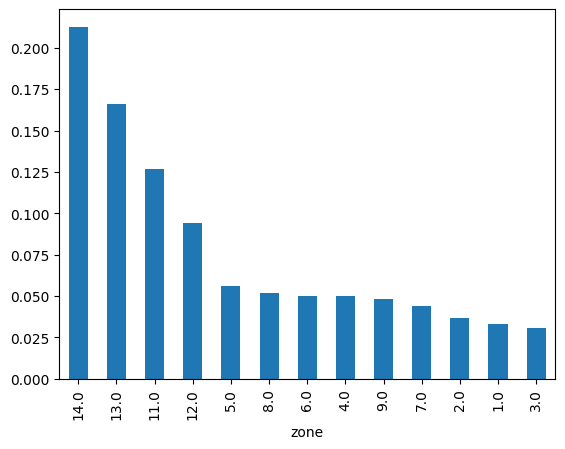

In [ ]:
zone_counts = gamedata_clean['zone'].value_counts(normalize = True)
zone_counts.plot(kind='bar')

We can't address the class imbalance issue with this distribution.

One thing we can do is to combine strike zone 1-9 to 1-4. We will do this in a seperate dataframe, check the distribution and then apply to the original dataframe. Visually, the zones will be like the follows:


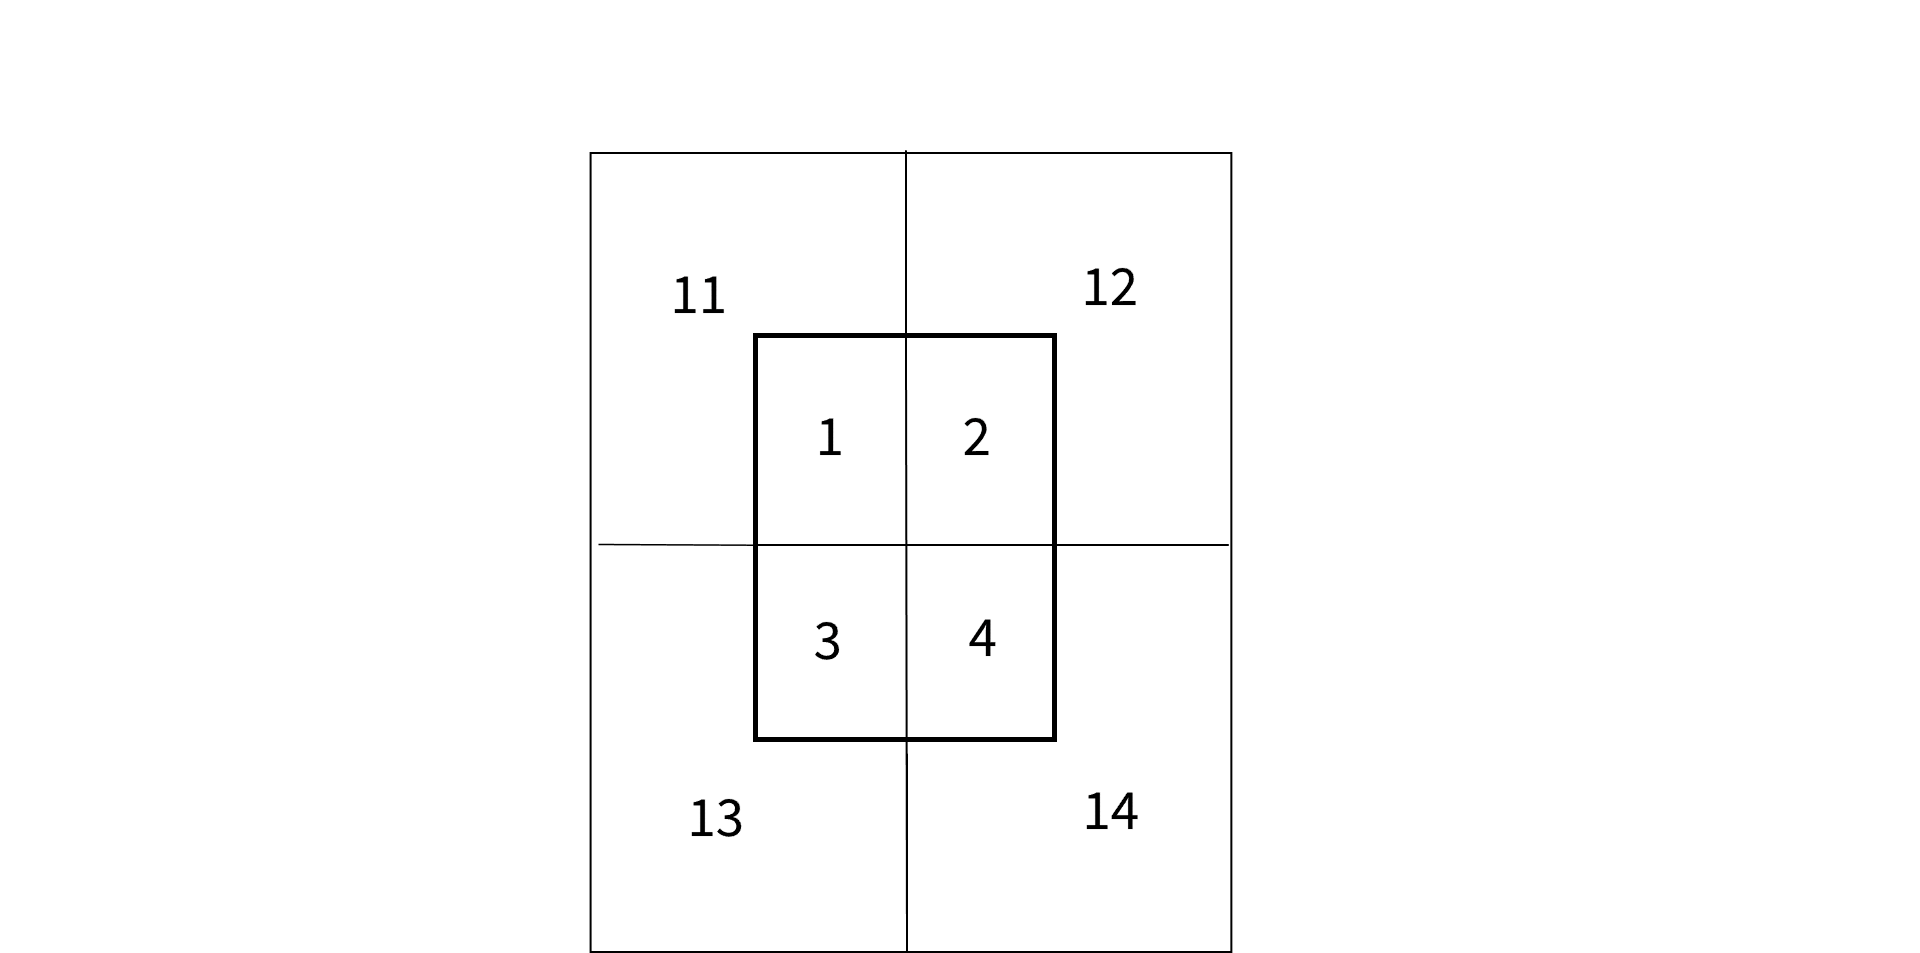

In [ ]:
zone_test  = gamedata_clean[['px','pz','sz_top','sz_bot','zone']].copy()

In [ ]:
# Filter to re-classify the balls in the strike zone only.
zone_test_19 = gamedata_clean[['px','pz','sz_top','sz_bot','zone']][(gamedata_clean['zone']>=1) & (gamedata_clean['zone']<=9)].copy()

In [ ]:
px = zone_test_19['px']
pz = zone_test_19['pz']
sz_top = zone_test_19['sz_top']
sz_bot = zone_test_19['sz_bot']

In [ ]:

zone1 = (px<=0)&(pz>(sz_top-(sz_top-sz_bot)/2))
zone2 = (px>0)&(pz>(sz_top-(sz_top-sz_bot)/2))
zone3 = (px<=0)&(pz<=(sz_top-(sz_top-sz_bot)/2))
zone4 = (px>0)&(pz<=(sz_top-(sz_top-sz_bot)/2))


#use for loop

zone_test_19.loc[zone1, 'zone'] = 1
zone_test_19.loc[zone2, 'zone'] = 2
zone_test_19.loc[zone3, 'zone'] = 3
zone_test_19.loc[zone4, 'zone'] = 4

In [ ]:
zone_test.update(zone_test_19)

In [ ]:
zone_test_count = zone_test['zone'].value_counts(normalize = True)

<Axes: xlabel='zone'>

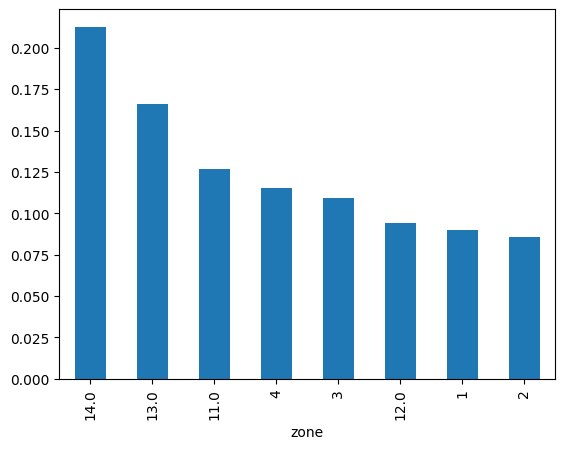

In [ ]:
zone_test_count.plot(kind='bar')

Zone 11,13,14 still accounts for a high proportion, but the classes look more balanced.

In [ ]:
gamedata_clean.update(zone_test_19)

### Simplified At-Bat Result

We will use the previous at-bat result as a feature later on. Let's take a look at the unique kinds of events. Note that this is the result of the at-bat, pitcher usually pitch 5+ balls and at-bat is considered over with one of these results.

In [ ]:
gamedata_clean['event'].value_counts()

,count
event,
Strikeout,893179
Groundout,536893
Single,419722
Walk,382295
Flyout,316937
Lineout,177740
Pop Out,137777
Double,126393
Home Run,90366


49 types of outcome. This will absolutely create issues when we feature engineer the "previous at-bat result" and put it to dummy variables. We will set the following rules:
- If the batter advances one base, it's a hit. Walk, HBP will be considered as a hit as well.
- If the batter advances more than one base, it's a slug. We distingtish this from a hit to show the extra damage the batter has created.
- If the batter is out, it's an out.
- If there's more than 1 out, it's a double play. We distingtish this from an out to show the extra advantage the pitcher and defense has gained.
- The rest of the event is called 'Other'.

In [ ]:
dictionary_event = {'Strikeout':'Out',
                'Groundout':'Out',
                'Single':'Hit',
                'Walk':'Hit',
                'Flyout':'Out',
                'Lineout':'Out',
                'Pop Out':'Out',
                'Double':'Slug',
                'Home Run':'Slug',
                'Forceout':'Out',
                'Grounded Into DP':'DP',
                'Hit By Pitch':'Hit',
                'Field Error':'Other',
                'Sac Fly':'Other',
                'Intent Walk':'Hit',
                'Triple':'Slug',
                'Sac Bunt':'Other',
                'Double Play':'DP',
                'Fielders Choice Out':'Out',
                'Runner Out':'Out',
                'Strikeout - DP':'DP',
                'Fielders Choice':'Out',
                'Bunt Groundout':'Out',
                'Bunt Pop Out':'Out',
                'Strikeout Double Play':'DP',
                'Catcher Interference':'Other',
                'Batter Interference':'Other',
                'Caught Stealing 2B':'Out',
                'Sac Fly DP':'DP',
                'Fan Interference':'Other',
                'Bunt Lineout':'Out',
                'Pickoff Caught Stealing 2B':'Other',
                'Triple Play':'DP',
                'Pickoff 1B':'Other',
                'Caught Stealing Home':'Out',
                'Sac Fly Double Play':'DP',
                'Caught Stealing 3B':'Out',
                'Pickoff 2B':'Other',
                'Pickoff Caught Stealing Home':'Out',
                'Wild Pitch':'Other',
                'Pickoff 3B':'Other',
                'Sacrifice Bunt DP':'DP',
                'Sac Bunt Double Play':'DP',
                'Runner Double Play':'DP',
                'Pickoff Caught Stealing 3B':'Out',
                'Game Advisory':'Other',
                'Pickoff Caught Stealing Home':'Out',
                'Passed Ball':'Other',
                'Pickoff Error 1B':'Other',
                'Stolen Base 2B':'Other'
                }


In [ ]:
# Update to a new column
simple_ab_event = [dictionary_event[event_type] for event_type in gamedata_clean['event']]
gamedata_clean['simple_ab_event'] = simple_ab_event

<ipython-input-304-3d0a61c0a531>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_ab_event'] = simple_ab_event


### Simple Pitch Result

There are 15 different outcome for each pitch. To reduce the dummy variable created, we will simply them to 5 types:



In [ ]:
gamedata_clean['type'].value_counts()

,count
type,
S,1278747
B,1182890
X,546226
F,119853
C,111250
D,25983
*B,16129
E,15517
T,6032


In [ ]:
dictionary_type = {'S':'S',
                'B':'B',
                'X':'X',
                'F':'F',
                'C':'S',
                'D':'D',
                '*B':'B',
                'E':'E',
                'T':'F',
                'W':'S',
                'H':'D',
                'L':'F',
                'M':'S',
                'P':'B',
                'O':'B',
                'First Pitch':'Other'
                }

In [ ]:
simple_type = [dictionary_type[type] for type in gamedata_clean['type']]
gamedata_clean['simple_type'] = simple_type

<ipython-input-307-303da646b40f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_type'] = simple_type


In [ ]:
gamedata_clean['simple_type'].value_counts()

,count
simple_type,
S,1395509
B,1199099
X,546226
F,127401
D,27807
E,15517


### Count Difference

The rule of baseball pitching is that if 4 bad pitches (ball) are made, batter can walk to the first base. If 3 good pitchers (strike) are made, batter is out. Ball count serves as a tool to show who's at advantage.

Suppose the current count is 3 ball and no strike, then the pitcher has the pressure to throw strikes, otherwise the batter will get free base. On the other hand, if the count is 1 ball 2 strikes, then the batter has two more chances to throw ball. They might intentionally throw breaking balls that induce batters to swing and miss, thus strikeing them out.

We will simply use ball count - strike count to show the difference.

In [ ]:
gamedata_clean['b_count_diff'] = gamedata_clean['b_count'] - gamedata_clean['s_count']

<ipython-input-308-41f1632e72f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['b_count_diff'] = gamedata_clean['b_count'] - gamedata_clean['s_count']


### Run Difference

For some reason, baseball calls score as run. So this is simply showing the score difference. Note that the difference is calculated using the pitcher's team's score minus the opposite side's score. The sign of this run difference will change when changing between top and bottom innings.

In [ ]:
gamedata_clean['run_diff'] = gamedata_clean['p_score'] - gamedata_clean['b_score']

<ipython-input-309-2d5576de9293>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['run_diff'] = gamedata_clean['p_score'] - gamedata_clean['b_score']


In [ ]:
gamedata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 3595943
Data columns (total 39 columns):
 #   Column             Dtype  
---  ------             -----  
 0   px                 float64
 1   pz                 float64
 2   start_speed        float64
 3   end_speed          float64
 4   sz_bot             float64
 5   sz_top             float64
 6   nasty              float64
 7   zone               object 
 8   code               object 
 9   type               object 
 10  pitch_type         object 
 11  b_score            float64
 12  ab_id              float64
 13  b_count            float64
 14  s_count            float64
 15  outs               float64
 16  pitch_num          float64
 17  on_1b              float64
 18  on_2b              float64
 19  on_3b              float64
 20  batter_id          int64  
 21  event              object 
 22  g_id               float64
 23  inning             float64
 24  o                  int64  
 25  p_score            floa

### Split to top and bottom again

We will move on to the feature engineering for previous result that shows some idea of recurrent. It's important to split the dataframe to top and bottom innings again.

In [ ]:
top_ins = gamedata_clean[gamedata_clean['top'] ==True]
bot_ins = gamedata_clean[gamedata_clean['top'] == False]

### Previous at-bat result

Previous at-bat result generally serves as an indicator of "Advantage". Consecutive hits probably shows the last pitch is not good enough or has been anticpated. In other words, it's a signal for pitcher to keep or adjust their pitching strategy.

It will also have some corelation with other features. For example, if previous at-bat is an out, then the current out number will be one more than the previous at-bat.

It's important to note that there's an underlying assumption. Are each at-bats related to each other? Are each innings connected to each other?

In [ ]:
ab_df['event'].value_counts()

,count
event,
Strikeout,199405
Groundout,166734
Single,134520
Flyout,100488
Walk,71903
Lineout,55960
Pop Out,43115
Double,41582
Home Run,28927


It will be tough to locate last pitch from the pitch-by-pitch script. Luckily, the ab_df dataframe contains the at-bat result, same as the 'event' column from our main dataframe. We will encode the event column in ab_df, look up the previous at-bat id and bring the simplied event to a new column.

In [ ]:
simple_ab_event = [dictionary_event[event_type] for event_type in ab_df['event']]
ab_df['simple_ab_event'] = simple_ab_event

In [ ]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]): # Make sure to set first AB for the first ab-bat of the game
        result = "FirstAB"
    else:
        if (top_ins['ab_id'].iloc[i] != top_ins['ab_id'].iloc[i-1]):
            matching_index = ab_df[ab_df['ab_id'] == top_ins['ab_id'].iloc[i-1]].index[0]
            result = ab_df.iloc[matching_index]['simple_ab_event']
    top_ins.loc[top_ins.index[i], 'prvs_ab'] = result

<ipython-input-314-a40d60580f47>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_ab'] = result


In [ ]:
top_ins[['event','prvs_ab']].head(20)

,event,prvs_ab
0,Groundout,FirstAB
1,Groundout,FirstAB
2,Groundout,FirstAB
3,Groundout,FirstAB
4,Groundout,FirstAB
5,Groundout,FirstAB
6,Double,Out
7,Double,Out
8,Single,Slug
9,Single,Slug


In [ ]:
# Rpeat the same for bottom innings
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "FirstAB"
    else:
        if (bot_ins['ab_id'].iloc[i] != bot_ins['ab_id'].iloc[i-1]):
            matching_index = ab_df[ab_df['ab_id'] == bot_ins['ab_id'].iloc[i-1]].index[0]
            result = ab_df.iloc[matching_index]['simple_ab_event']
    bot_ins.loc[bot_ins.index[i], 'prvs_ab'] = result

<ipython-input-316-f966b582f4bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_ab'] = result


### Previous Pitch Type

Previous pitch type will show the combination of pitches. Famous combo includes fastball + off-speed to make the hitting hard, or fastball+breaking ball to make it hard predicting the pitch location.

Note that the first pitch of each game and each pitcher will be encoded as 'First pitch' as I assume the sequence doesn't last between games and between pitchers.

In [ ]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (top_ins['pitcher_id'].iloc[i] != top_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = top_ins['simple_pitch_type'].iloc[i-1]
    top_ins.loc[top_ins.index[i], 'prvs_pitch'] = result

<ipython-input-317-2c93a49ac2c4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_pitch'] = result


In [ ]:
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (bot_ins['pitcher_id'].iloc[i] != bot_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = bot_ins['simple_pitch_type'].iloc[i-1]
    bot_ins.loc[bot_ins.index[i], 'prvs_pitch'] = result

<ipython-input-318-bc1279059410>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_pitch'] = result


### Previous Pitch Result

We can consider this to be a more detailed version of strike-ball count and previous ab-bat result. Same as at-bat result, it's a signal for pitcher to determine if the stragegy is working. Same as strike-ball count, pitcher needs to update the count and realize what they should do next.

In [ ]:
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (top_ins['pitcher_id'].iloc[i] != top_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = top_ins['simple_type'].iloc[i-1]
    top_ins.loc[top_ins.index[i], 'prvs_pitch_result'] = result

<ipython-input-319-87887f6bb9b4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_pitch_result'] = result


In [ ]:
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (bot_ins['pitcher_id'].iloc[i] != bot_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = bot_ins['simple_type'].iloc[i-1]
    bot_ins.loc[bot_ins.index[i], 'prvs_pitch_result'] = result

<ipython-input-320-a4a8b6c48297>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_pitch_result'] = result


### Previous Pitch Zone

Previous pitch type will show the combination of zones. Pitcher will pitch to different areas of the strike zone to make it harder for hitter to anticipate trajaectory.

Note that the first pitch of each game and each pitcher will be encoded as 'First pitch' as I assume the sequence doesn't last between games and between pitchers.

In [ ]:
#Add previous pitch zone for top innings.
result = ""
for i in range(len(top_ins)):
    if (top_ins['g_id'].iloc[i] != top_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (top_ins['pitcher_id'].iloc[i] != top_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = top_ins['zone'].iloc[i-1]
    top_ins.loc[top_ins.index[i], 'prvs_zone'] = result

<ipython-input-321-0bb9addc55f8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins.loc[top_ins.index[i], 'prvs_zone'] = result


In [ ]:
#Add previous pitch zone for bottom innings.
result = ""
for i in range(len(bot_ins)):
    if (bot_ins['g_id'].iloc[i] != bot_ins['g_id'].iloc[i-1]):
        result = "First Pitch"
    else:
        if (bot_ins['pitcher_id'].iloc[i] != bot_ins['pitcher_id'].iloc[i-1]):
            result = "First Pitch"
        else:
            result = bot_ins['zone'].iloc[i-1]
    bot_ins.loc[bot_ins.index[i], 'prvs_zone'] = result

<ipython-input-322-809c34baab1b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_ins.loc[bot_ins.index[i], 'prvs_zone'] = result


### Starting Pitcher vs. Relief Pitcher

A starting pitcher usually will pitch for 5+ innings with around 80 pitches from the start of the game. In comparison, relief pitchers usually pitch for 1 to 2 innings in the middle of the game. These two roles have the following difference due to the nature of their responsibility:
- Starting pitchers usually have 3-4 good types of pitching. Relief pitchers usually only have 2.
- Starting pitchers needs to perserve energy for late innings. They will not throw as hard as relief pitcher, especially on fastballs.

These differences make both have different pitching strategies. It feels essential to classify if someone is relief pitcher or starting pitcher. Consider the following two situations:
- Starter got pulled from mount on a particular game because of injury or poor performance. He only had 20 pitches but relief pitcher has to take over.
- The team doesn't have enough starting pitcher to fill the rotation. A relief pitcher has to start the game and is replaced after 2 innings. (Also called bullpen day).

To accurately classify the role, we will look each pitcher's maximum pitch count through the dataframe. If he ever pitched more than 50 pitches, he should be considered as a starting pitcher.

First, we will find maximum(final) pitch count for each pithcer in their games. If the maximum pitch count is more than 50 then he's a SP, otherwise he's a RP.

In [ ]:
#Create a dataset with the unique pitchers and their maximum pitch count through 2015-2019 and determine their pitching assignment based on 50 pitches as threhold.
max_pitch_1 = top_ins.groupby('pitcher_id')['pitch_count'].max()
max_pitch_1 = max_pitch_1.reset_index()
max_pitch_1['SPorRP'] = ['SP' if value > 50 else 'RP' for value in max_pitch_1['pitch_count']]
max_pitch_2 = bot_ins.groupby('pitcher_id')['pitch_count'].max()
max_pitch_2 = max_pitch_2.reset_index()
max_pitch_2['SPorRP'] = ['SP' if value > 50 else 'RP' for value in max_pitch_2['pitch_count']]

In [ ]:
top_ins = top_ins.merge(max_pitch_1[['pitcher_id', 'SPorRP']], on='pitcher_id', how='left');
bot_ins = bot_ins.merge(max_pitch_2[['pitcher_id', 'SPorRP']], on='pitcher_id', how='left');


In [ ]:
top_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684977 entries, 0 to 1684976
Data columns (total 44 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   px                 1684977 non-null  float64
 1   pz                 1684977 non-null  float64
 2   start_speed        1684977 non-null  float64
 3   end_speed          1684977 non-null  float64
 4   sz_bot             1684977 non-null  float64
 5   sz_top             1684977 non-null  float64
 6   nasty              1340318 non-null  float64
 7   zone               1684977 non-null  object 
 8   code               1681927 non-null  object 
 9   type               1684977 non-null  object 
 10  pitch_type         1684977 non-null  object 
 11  b_score            1684977 non-null  float64
 12  ab_id              1684977 non-null  float64
 13  b_count            1684977 non-null  float64
 14  s_count            1684977 non-null  float64
 15  outs               1684977 non-n

At the end, we will save all added features to csv and pass to further data cleaning and processing.

In [ ]:
top_ins.to_csv('/mnt/drive/MyDrive/capstone_data/top_ins.csv')
bot_ins.to_csv('/mnt/drive/MyDrive/capstone_data/bot_ins.csv')

## Finalizing Dataset

In [ ]:
top_ins = pd.read_csv('/mnt/drive/MyDrive/capstone_data/top_ins.csv')
bot_ins = pd.read_csv('/mnt/drive/MyDrive/capstone_data/bot_ins.csv')

<ipython-input-485-5b5e0670d520>:1: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  top_ins = pd.read_csv('/mnt/drive/MyDrive/capstone_data/top_ins.csv')
<ipython-input-485-5b5e0670d520>:2: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  bot_ins = pd.read_csv('/mnt/drive/MyDrive/capstone_data/bot_ins.csv')


### Cleaning dataframe

#### Columns to Remove

First, we need to remove N/A values. Then, there are some columns we are not going to use in this project as they are not affecting the game at a competivie level.

In [ ]:
top_ins.isna().sum()

,0
Unnamed: 0,0
px,0
pz,0
start_speed,0
end_speed,0
sz_bot,0
sz_top,0
nasty,344659
zone,0
code,3050


- 'nasty' columns would be helpful as nasty pitching will be harder to hit upon comparing to normal pitching. Unfortunately we have to remove this column due to missing values.

- 'code','event','pitch_type' has been encoded so we can just remove them.

- 'attendance' will not be needed as it's not very related to competitive level.

- 'wind' column is unnecessary as it won't affect a ball 'travelling' at 90 mph for 60.5 feet.

In [ ]:
top_ins = top_ins.drop(columns=['nasty', 'code','event','pitch_type','attendance','wind'])
bot_ins = bot_ins.drop(columns=['nasty', 'code','event','pitch_type','attendance','wind'])

#### Weather

Weather might play a factor for pitching. We will try to fill the N/A values instead of simply remove it.

We will use the weather column in the original dataframe to see the overall situation and apply changes to top_ins and bot_ins seperately.

In [ ]:
gamedata_clean['weather'].head()

,weather
0,"44 degrees, clear"
1,"44 degrees, clear"
2,"44 degrees, clear"
3,"44 degrees, clear"
4,"44 degrees, clear"


We should try to extract the last word of the weather description as the weather feature and disregard the temperature.

In [ ]:
gamedata_clean['simple_weather'] = gamedata_clean['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')

<ipython-input-489-d04dcc85c001>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_clean['simple_weather'] = gamedata_clean['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')


In [ ]:
gamedata_clean['simple_weather'].value_counts()

,count
simple_weather,
cloudy,1269522
,675488
clear,511560
closed,293618
sunny,264311
overcast,171366
dome,92767
drizzle,17920
rain,14801


There are in total 675488 N/A cells, representing 20% of the data. I am not expecting huge corelation or weight on this feature for our analysis, so we will use cloudy as a replacement.

In addition, we will combine closed with dome as they both represent in-door game environment.

In [ ]:
top_ins['simple_weather'] = top_ins['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')
top_ins['simple_weather'][top_ins['simple_weather'] == ''] = 'cloudy'
top_ins['simple_weather'][top_ins['simple_weather'] == 'closed'] = 'dome'

<ipython-input-491-2d8fe8922e4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['simple_weather'][top_ins['simple_weather'] == ''] = 'cloudy'
<ipython-input-491-2d8fe8922e4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ins['simple_weather'][top_ins['simple_weather'] == 'closed'] = 'dome'


In [ ]:
bot_ins['simple_weather'] = bot_ins['weather'].apply(lambda x: x.split()[-1] if isinstance(x, str) and x else '')


In [ ]:
bot_ins['simple_weather'] = bot_ins['simple_weather'].replace('', 'cloudy')
bot_ins['simple_weather'] = bot_ins['simple_weather'].replace('closed', 'dome')

In [ ]:
top_ins = top_ins.drop(columns=['weather'])
bot_ins = bot_ins.drop(columns=['weather'])

This was the last step of cleaning N/A values. Let's check if anything is missing.

In [ ]:
top_ins.isna().sum()

,0
Unnamed: 0,0
px,0
pz,0
start_speed,0
end_speed,0
sz_bot,0
sz_top,0
zone,0
type,0
b_score,0


In [ ]:
bot_ins.isna().sum()

,0
Unnamed: 0,0
px,0
pz,0
start_speed,0
end_speed,0
sz_bot,0
sz_top,0
zone,0
type,0
b_score,0


### Get Dummy Variable

As we finished all feature enginering, we will combine both dataframe to 1 dataframe.

In [ ]:
input_df = pd.concat([top_ins, bot_ins])

In [ ]:
input_df = input_df.drop(columns=['batter_id'])

In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 1626581
Data columns (total 38 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   px                 float64
 2   pz                 float64
 3   start_speed        float64
 4   end_speed          float64
 5   sz_bot             float64
 6   sz_top             float64
 7   zone               float64
 8   type               object 
 9   b_score            float64
 10  ab_id              float64
 11  b_count            float64
 12  s_count            float64
 13  outs               float64
 14  pitch_num          float64
 15  on_1b              float64
 16  on_2b              float64
 17  on_3b              float64
 18  g_id               float64
 19  inning             float64
 20  o                  int64  
 21  p_score            float64
 22  p_throws           object 
 23  pitcher_id         int64  
 24  stand              object 
 25  top                floa

Out of these columns:
- ID: ab_id, pitcher_id, g_id, top can be removed once dataframe are partitioned.
- zone (13 unique values) and simple_pitch_type (4 unique values) will be the target variable. I need to encode these two columns.
- p_throws, stand are binary features. We need to replace 'L' and 'R' with 0 or 1.
- simple_ab_event, pvrs_ab,pvrs_pitch and pvrs_pitch_result and simple_weather will need dummy variable and treat as input features.

#### Dummy Variable for Previous Pitch Result

In [ ]:
input_df['prvs_pitch_result'].value_counts()

,count
prvs_pitch_result,
S,1368877
B,1193245
X,483868
F,127069
First Pitch,97866
D,26541
E,14093


In [ ]:
input_df = pd.get_dummies(input_df, columns=['prvs_pitch_result'])
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 1626581
Data columns (total 44 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   px                             float64
 2   pz                             float64
 3   start_speed                    float64
 4   end_speed                      float64
 5   sz_bot                         float64
 6   sz_top                         float64
 7   zone                           float64
 8   type                           object 
 9   b_score                        float64
 10  ab_id                          float64
 11  b_count                        float64
 12  s_count                        float64
 13  outs                           float64
 14  pitch_num                      float64
 15  on_1b                          float64
 16  on_2b                          float64
 17  on_3b                          float64
 18  g_id   

#### Dummy Variable for Previous Pitch Type

In [ ]:
input_df['prvs_pitch'].value_counts()

,count
prvs_pitch,
Four-Seam Fastball,1153128
Breaking,869976
Fastball,800646
Off-speed,389943
First Pitch,97866


In [ ]:
input_df = pd.get_dummies(input_df, columns=['prvs_pitch'])

#### Dummy Variable for Previous Pitch Zone

In [ ]:
input_df['prvs_zone'].value_counts()

,count
prvs_zone,
14.0,546166
13.0,434870
4,365191
3,346720
11.0,331328
1,286798
2,272772
12.0,244772
14,142797


Oops, somehow the index wasn't proper. zone 14 and zone 14.0 should be the same. We need to update this.

In [ ]:
print(input_df['prvs_zone'].dtype)

object


In [ ]:
#Remove decimal place.
dictionary_zone_str = {'11.0':'11','12.0':'12','13.0':'13','14.0':'14'}
input_df['prvs_zone'] = input_df['prvs_zone'].astype(str)
input_df['prvs_zone'] = input_df['prvs_zone'].replace(dictionary_zone_str)
input_df['prvs_zone'].value_counts()

,count
prvs_zone,
14,688963
13,536273
11,411531
4,365191
3,346720
12,305445
1,286798
2,272772
First Pitch,97866


In [ ]:
input_df = pd.get_dummies(input_df, columns=['prvs_zone'])

#### Dummy Variable for Previous At-Bat Result

In [ ]:
input_df['prvs_ab'].value_counts()

,count
prvs_ab,
Out,2068141
Hit,755982
Slug,250460
FirstAB,95693
DP,74376
Other,66907


In [ ]:
input_df = pd.get_dummies(input_df, columns=['prvs_ab'])
input_df = input_df.drop(columns=['simple_ab_event'])

#### Dummy Variable for Weather

In [ ]:
input_df['simple_weather'].value_counts()

,count
simple_weather,
cloudy,1945010
clear,511560
dome,386385
sunny,264311
overcast,171366
drizzle,17920
rain,14801
snow,206


In [ ]:
input_df = pd.get_dummies(input_df, columns=['simple_weather'])

#### Update L/R to Boolean

Pitching throwing side and batter stand side is text data. We will use 0 for left-hand user and 1 for right-hand user.

##### Pitcher's throwing hand

In [ ]:
input_df['p_throws'].value_counts()

,count
p_throws,
R,2421174
L,890385


In [ ]:
input_df['p_throws'][input_df['p_throws'] =='L'] = 0
input_df['p_throws'][input_df['p_throws'] =='R'] = 1

<ipython-input-513-2d180f1f2966>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['p_throws'][input_df['p_throws'] =='L'] = 0
<ipython-input-513-2d180f1f2966>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['p_throws'][input_df['p_throws'] =='R'] = 1


In [ ]:
input_df['stand'].value_counts()

,count
stand,
R,1928447
L,1383112


In [ ]:
input_df['stand'][input_df['stand'] =='L'] = 0
input_df['stand'][input_df['stand'] =='R'] = 1

<ipython-input-515-072ab0f1e50c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['stand'][input_df['stand'] =='L'] = 0
<ipython-input-515-072ab0f1e50c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['stand'][input_df['stand'] =='R'] = 1


In [ ]:
input_df['p_throws'].value_counts()

,count
p_throws,
1,2421174
0,890385


In [ ]:
input_df['stand'].value_counts()

,count
stand,
1,1928447
0,1383112


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 1626581
Data columns (total 67 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   px                             float64
 2   pz                             float64
 3   start_speed                    float64
 4   end_speed                      float64
 5   sz_bot                         float64
 6   sz_top                         float64
 7   zone                           float64
 8   type                           object 
 9   b_score                        float64
 10  ab_id                          float64
 11  b_count                        float64
 12  s_count                        float64
 13  outs                           float64
 14  pitch_num                      float64
 15  on_1b                          float64
 16  on_2b                          float64
 17  on_3b                          float64
 18  g_id   

In [ ]:
input_df['stand'] = input_df['stand'].astype(float)
input_df['p_throws'] = input_df['p_throws'].astype(float)

In [ ]:
bool_columns = input_df.select_dtypes(include=['bool']).columns
input_df[bool_columns] = input_df[bool_columns].astype(float)

In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 1626581
Data columns (total 67 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   px                             float64
 2   pz                             float64
 3   start_speed                    float64
 4   end_speed                      float64
 5   sz_bot                         float64
 6   sz_top                         float64
 7   zone                           float64
 8   type                           object 
 9   b_score                        float64
 10  ab_id                          float64
 11  b_count                        float64
 12  s_count                        float64
 13  outs                           float64
 14  pitch_num                      float64
 15  on_1b                          float64
 16  on_2b                          float64
 17  on_3b                          float64
 18  g_id   

#### Encode simple_pitch_type

Pitch type column is one of the targets. Due to the multiclass prediction task, it will be easier to encode it from text.

In [ ]:
input_df['simple_pitch_type'].value_counts()

,count
simple_pitch_type,
Four-Seam Fastball,1186853
Breaking,899084
Fastball,824773
Off-speed,400849


In [ ]:
dictionary_pitch_type = {'Fastball': 3,
                'Breaking': 2,
                'Four-Seam Fastball': 1,
                'Off-speed': 4
                }

In [ ]:
simple_pitch_type_enc = [dictionary_pitch_type[type] for type in input_df['simple_pitch_type']]
input_df['simple_pitch_type_enc'] = simple_pitch_type_enc


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3311559 entries, 0 to 1626581
Data columns (total 68 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   px                             float64
 2   pz                             float64
 3   start_speed                    float64
 4   end_speed                      float64
 5   sz_bot                         float64
 6   sz_top                         float64
 7   zone                           float64
 8   type                           object 
 9   b_score                        float64
 10  ab_id                          float64
 11  b_count                        float64
 12  s_count                        float64
 13  outs                           float64
 14  pitch_num                      float64
 15  on_1b                          float64
 16  on_2b                          float64
 17  on_3b                          float64
 18  g_id   

#### Encode SPorRP

We are strings in the SP or RP column. Because it's binary, we will just encode it as 1 or 0 rather than creating dummies.

In [ ]:
input_df['SPorRP'] = input_df['SPorRP'].apply(lambda x: 1 if x == 'SP' else 0)

In [ ]:
input_df['SPorRP'].value_counts()

,count
SPorRP,
1,2444432
0,867127


In [ ]:
input_df.to_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

## Advanced EDA on Common Game Situation

We will look at some common/critical situations with cleaned dataset.

### Ball count

In baseball, pitchers need to throw the 3 pitchs into the stike zone(zone 1-4). These are considered as a throw that can be hit. Pitcher has 3 chances to pitch a "ball", which is a throw outside the strike zone(zone 11-14).

If the pitchers throw 4 "ball"s, the hitter is entitled to the first base, which is called a walk. If the pitchers throw 3 "strike"s without being hit, he "strikeout" the hitter. It's a zero-sum game. The hitter want to get on the base by hitting or getting a "walk". The pitcher has to stop hitters from doing so.

We will examine some of the typical sitation based on ball counts.

#### 3-0

3-0 represents the situation that the pitcher has throw three bad pitches and 0 good pitch. The hitter is one bad pitch away from getting a free base. How will pitcher handle the situation?

In [ ]:
EDA_df = input_df[['px','pz','simple_pitch_type','zone']][(input_df['b_count'] == 3) & (input_df['s_count'] == 0)]
sz_top_mean =input_df['sz_top'].mean()
sz_bot_mean =input_df['sz_bot'].mean()
middle = (sz_top_mean+sz_bot_mean)/2

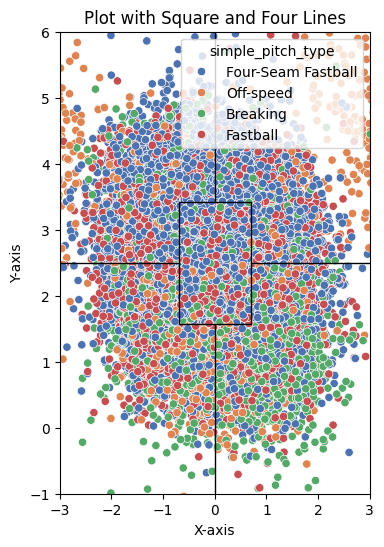

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 6))


# Add the four lines
plt.plot([0, 0], [sz_top_mean, 6], color='black', linewidth=1)
plt.plot([0, 0], [sz_bot_mean, -3], color='black', linewidth=1)
plt.plot([-3, -0.7], [middle, middle], color='black', linewidth=1)
plt.plot([3, 0.7], [middle, middle], color='black', linewidth=1)

# Set the limits to ensure everything is visible
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)

sns.scatterplot(x='px', y='pz', hue='simple_pitch_type', palette='deep', data=EDA_df, ax=ax)

square = patches.Rectangle((-0.7, sz_bot_mean), 1.4, (sz_top_mean-sz_bot_mean), linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(square)
# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pitch Scatter Plot of Pitch Types and location under 3-0 count')

# Show the plot
plt.show()

The pitch distribution is ambigious because the scatter point overlays each other. We will look at numbers below for some insight.

Text(0.5, 1.0, 'Histogram of Pitch Types under 3-0 count')

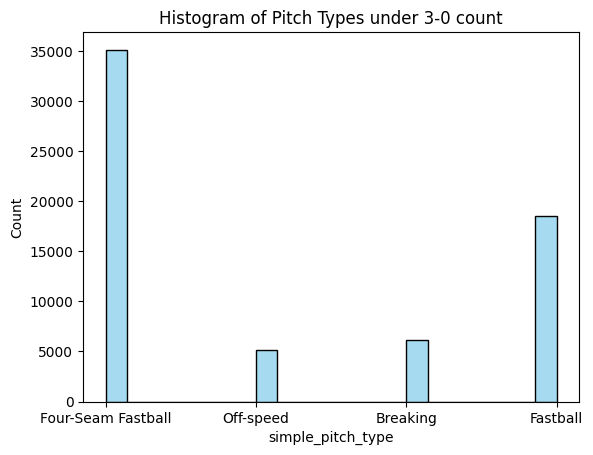

In [ ]:
sns.histplot(data=EDA_df, x='simple_pitch_type', discrete=False, color='skyblue',binwidth = 0.3)
plt.title('Histogram of Pitch Types under 3-0 count')

When facing 3-0 count, pitchers rely a lot on fastball, especially four-seam fastball. This makes sense becuase its the easiest pitch to control to land in the strike zone.

Text(0.5, 1.0, 'Histogram of Pitch Zones under 3-0 count')

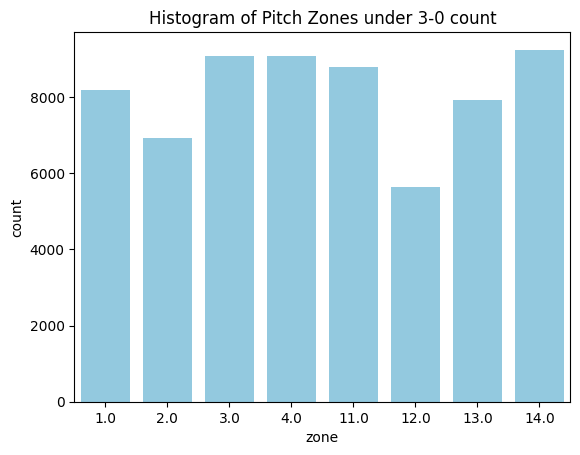

In [ ]:
count_data = EDA_df['zone'].value_counts().reset_index()
count_data.columns = ['zone', 'count']

# Plotting the bar plot
sns.barplot(x='zone', y='count', data=count_data, color='skyblue')

plt.title('Histogram of Pitch Zones under 3-0 count')

The distribution of strike zone placement is different from the overall distribution. There are more pitches thrown to zone 3 and 4 while the throws lands in zone 14 decreases.

#### 0-2

0-2 represents the situation that the pitcher has throw 2 good pitches. The hitter is one good pitch away from being eliminated. How will pitcher handle the situation?

In [ ]:
EDA_df = input_df[['px','pz','simple_pitch_type','zone']][(input_df['b_count'] == 0) & (input_df['s_count'] == 2)]

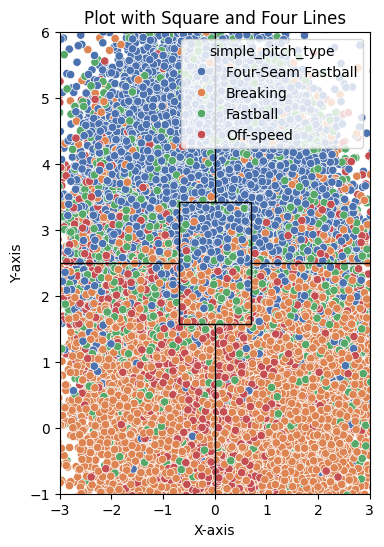

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 6))


# Add the four lines
plt.plot([0, 0], [sz_top_mean, 6], color='black', linewidth=1)
plt.plot([0, 0], [sz_bot_mean, -3], color='black', linewidth=1)
plt.plot([-3, -0.7], [middle, middle], color='black', linewidth=1)
plt.plot([3, 0.7], [middle, middle], color='black', linewidth=1)

# Set the limits to ensure everything is visible
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)

sns.scatterplot(x='px', y='pz', hue='simple_pitch_type', palette='deep', data=EDA_df, ax=ax)

square = patches.Rectangle((-0.7, sz_bot_mean), 1.4, (sz_top_mean-sz_bot_mean), linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(square)
# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pitch Scatter Plot of Pitch Types and location under 0-2 count')

# Show the plot
plt.show()

When compare the above graph with the same graph of 3-0 counts, we can tell that the ball are less concerntrated to the strike zone. Pitchers have more breathing room to throw balls, hoping that the hitter will chase such bad pitches.

Text(0.5, 1.0, 'Histogram of Pitch Types under 0-2 count')

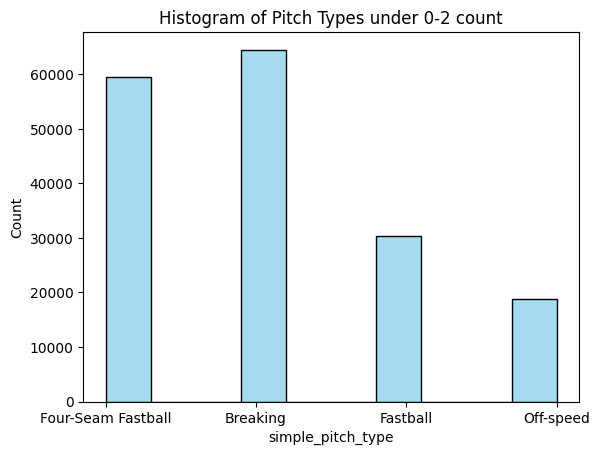

In [ ]:
sns.histplot(data=EDA_df, x='simple_pitch_type', discrete=False, color='skyblue', binwidth = 0.3)
plt.title('Histogram of Pitch Types under 0-2 count')

Two strategies are here: use a fireball finish this at-bat with count advantage, or use a breaking ball to temper the hitter. With more breathing room, pitchers can use breaking ball even if it end up being a "ball".

Text(0.5, 1.0, 'Histogram of Pitch Zones under 0-2 count')

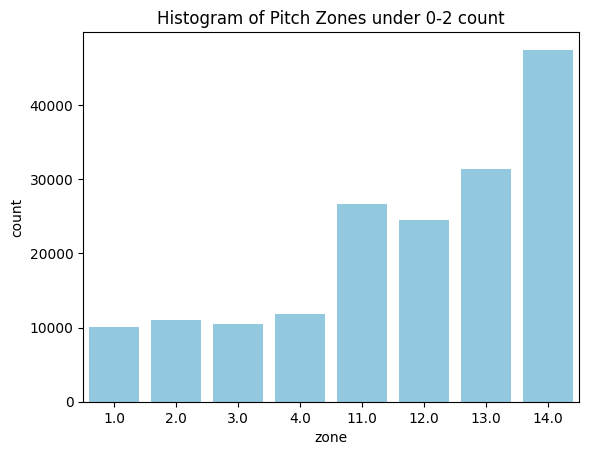

In [ ]:
count_data = EDA_df['zone'].value_counts().reset_index()
count_data.columns = ['zone', 'count']

# Plotting the bar plot
sns.barplot(x='zone', y='count', data=count_data, color='skyblue')

plt.title('Histogram of Pitch Zones under 0-2 count')

And not surprising, most of the pitches under 0-2 count is in the ball zone.

#### 3-2

3-2 represents the situation that the pitcher has throw 3 bad pitches and 2 good pitches. Things could go either way.
How will pitcher handle the situation?

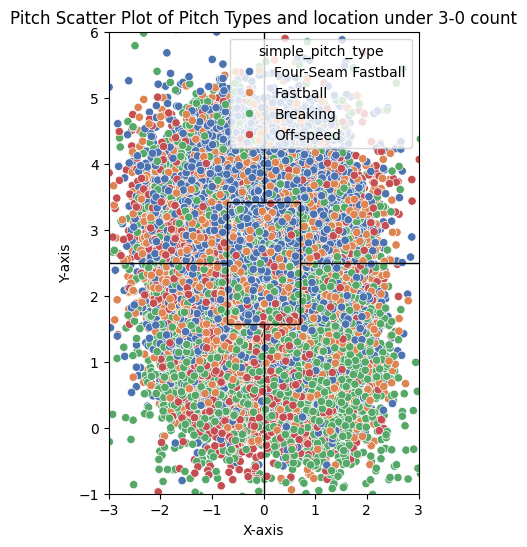

In [ ]:
EDA_df = input_df[['px','pz','simple_pitch_type','zone']][(input_df['b_count'] == 3) & (input_df['s_count'] == 2)]
fig, ax = plt.subplots(figsize=(4, 6))


# Add the four lines
plt.plot([0, 0], [sz_top_mean, 6], color='black', linewidth=1)
plt.plot([0, 0], [sz_bot_mean, -3], color='black', linewidth=1)
plt.plot([-3, -0.7], [middle, middle], color='black', linewidth=1)
plt.plot([3, 0.7], [middle, middle], color='black', linewidth=1)

# Set the limits to ensure everything is visible
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)

sns.scatterplot(x='px', y='pz', hue='simple_pitch_type', palette='deep', data=EDA_df, ax=ax)

square = patches.Rectangle((-0.7, sz_bot_mean), 1.4, (sz_top_mean-sz_bot_mean), linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(square)
# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pitch Scatter Plot of Pitch Types and location under 3-0 count')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Histogram of Pitch Types under 3-2 count')

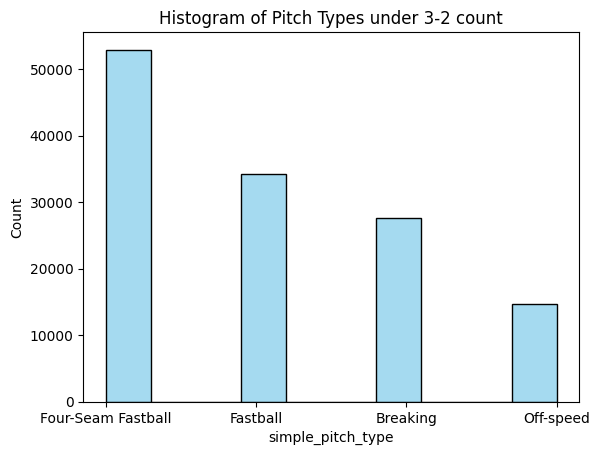

In [ ]:
sns.histplot(data=EDA_df, x='simple_pitch_type', discrete=False, color='skyblue', binwidth = 0.3)
plt.title('Histogram of Pitch Types under 3-2 count')

Text(0.5, 1.0, 'Histogram of Pitch Zones under 3-2 count')

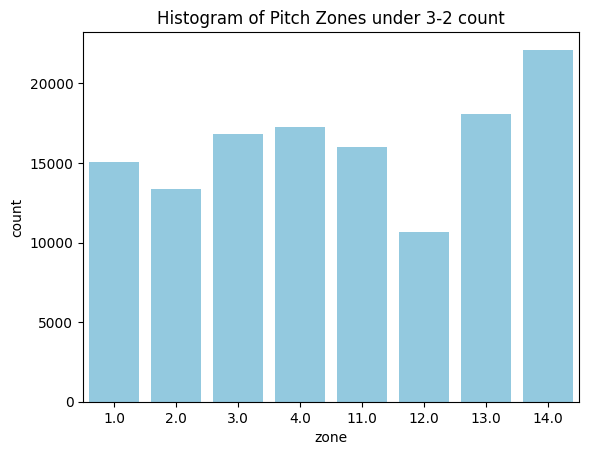

In [ ]:
count_data = EDA_df['zone'].value_counts().reset_index()
count_data.columns = ['zone', 'count']

# Plotting the bar plot
sns.barplot(x='zone', y='count', data=count_data, color='skyblue')

plt.title('Histogram of Pitch Zones under 3-2 count')

It looks like pitchers didn't treat 3-2 too series. The pitch type count and zone distribution generally follows the overall distribution.

### Runner-on-Base

##### Runner on first base

In [ ]:
EDA_df_p = input_df[['simple_pitch_type']][(input_df['on_1b'] == 1) & (input_df['on_2b'] == 0)&(input_df['on_3b'] == 0)].value_counts(normalize = True).reset_index()

In [ ]:
print(EDA_df_p)

    simple_pitch_type  proportion
0  Four-Seam Fastball        0.36
1            Fastball        0.28
2            Breaking        0.24
3           Off-speed        0.12


When runner is on the first base, the pitching is similar to the overall distribution.

In [ ]:
EDA_df_z = input_df[['px','pz']][(input_df['on_1b'] == 1) & (input_df['on_2b'] == 0)&(input_df['on_3b'] == 0)]

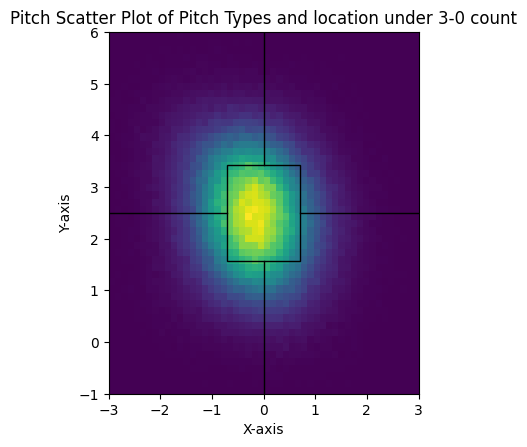

In [ ]:
x = EDA_df_z['px']
y = EDA_df_z['pz']

fig, ax = plt.subplots(figsize=(4, 6))

# Add the four lines
plt.plot([0, 0], [sz_top_mean, 6], color='black', linewidth=1)
plt.plot([0, 0], [sz_bot_mean, -3], color='black', linewidth=1)
plt.plot([-3, -0.7], [middle, middle], color='black', linewidth=1)
plt.plot([3, 0.7], [middle, middle], color='black', linewidth=1)

# Set the limits to ensure everything is visible
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)

bins_x = 50
bins_y = 50
x_range = (-3, 3)
y_range = (-1, 6)
hist, xedges, yedges = np.histogram2d(x, y,bins=[bins_x, bins_y],range=[x_range, y_range])
plt.imshow(hist, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
square = patches.Rectangle((-0.7, sz_bot_mean), 1.4, (sz_top_mean-sz_bot_mean), linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(square)
# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pitch Scatter Plot of location when 1 runner on the first base')

# Show the plot
plt.show()

When runner is on the first base only, usually pitcher would pitch low to field a double play, eliminating both the runner and hitter. From the heatmap, this theory doesn't hold well. Most of the pitches go to the middle area.

##### Fully Loaded

In [ ]:
EDA_df_p = input_df[['simple_pitch_type']][(input_df['on_1b'] == 1) & (input_df['on_2b'] == 1)&(input_df['on_3b'] == 1)].value_counts(normalize = True).reset_index()

In [ ]:
print(EDA_df_p)

    simple_pitch_type  proportion
0  Four-Seam Fastball        0.36
1            Breaking        0.28
2            Fastball        0.26
3           Off-speed        0.10


When bases are fully loaded, the pitching is similar to the overall distribution.

In [ ]:
EDA_df_z = input_df[['px','pz']][(input_df['on_1b'] == 1) & (input_df['on_2b'] == 1)&(input_df['on_3b'] == 1)]

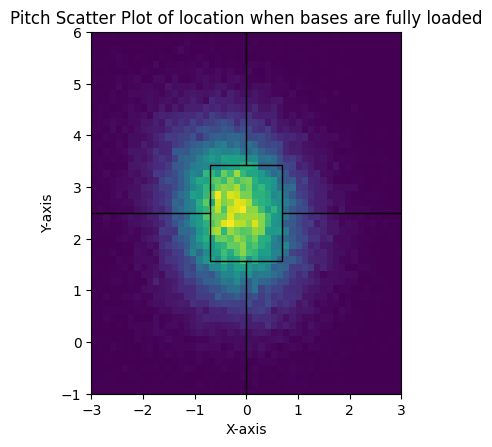

In [ ]:
x = EDA_df_z['px']
y = EDA_df_z['pz']

fig, ax = plt.subplots(figsize=(4, 6))

# Add the four lines
plt.plot([0, 0], [sz_top_mean, 6], color='black', linewidth=1)
plt.plot([0, 0], [sz_bot_mean, -3], color='black', linewidth=1)
plt.plot([-3, -0.7], [middle, middle], color='black', linewidth=1)
plt.plot([3, 0.7], [middle, middle], color='black', linewidth=1)

# Set the limits to ensure everything is visible
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)

bins_x = 50
bins_y = 50
x_range = (-3, 3)
y_range = (-1, 6)
hist, xedges, yedges = np.histogram2d(x, y,bins=[bins_x, bins_y],range=[x_range, y_range])
plt.imshow(hist, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
square = patches.Rectangle((-0.7, sz_bot_mean), 1.4, (sz_top_mean-sz_bot_mean), linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(square)
# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pitch Scatter Plot of location when bases are fully loaded')

# Show the plot
plt.show()

When the bases are fully loaded, a basehit will get at least 2 scores. It looks like pitcheres generally treat the situation as normal, distributing the throws everywhere.

### SP vs RP

When pitcher is starting the game, it's believed that he will not throw too many fastballs to save stamina. He would also try to get more strikes to in order to be efficient.Is it true?

In [ ]:
EDA_df_SP = input_df[['simple_pitch_type','SPorRP']][input_df['SPorRP'] == 1].value_counts(normalize = True).reset_index()
EDA_df_SP.columns =['simple_pitch_type','SPorRP','count']
EDA_df_RP = input_df[['simple_pitch_type','SPorRP']][input_df['SPorRP'] == 0].value_counts(normalize = True).reset_index()
EDA_df_RP.columns =['simple_pitch_type','SPorRP','count']
EDA_df = pd.concat([EDA_df_SP,EDA_df_RP])
print(EDA_df)

    simple_pitch_type  SPorRP  count
0  Four-Seam Fastball       1   0.34
1            Breaking       1   0.27
2            Fastball       1   0.26
3           Off-speed       1   0.13
0  Four-Seam Fastball       0   0.40
1            Breaking       0   0.28
2            Fastball       0   0.23
3           Off-speed       0   0.09


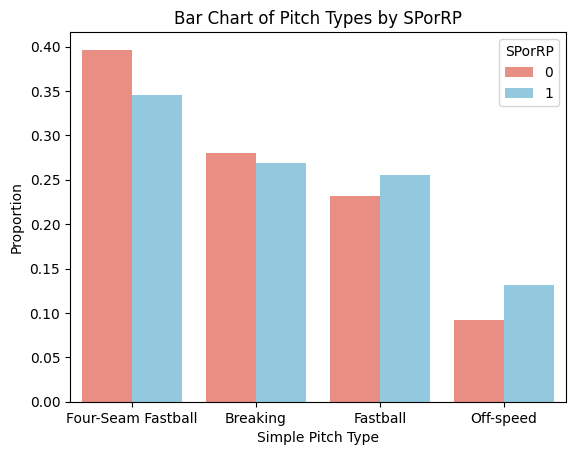

In [ ]:

sns.barplot(data=EDA_df, x='simple_pitch_type', y='count', hue='SPorRP', palette={0: 'salmon', 1: 'skyblue'})
plt.legend(title='SPorRP', labels=['SPorRP = RP', 'SPorRP = SP'])
# Add labels and title
plt.xlabel('Simple Pitch Type')
plt.ylabel('Proportion')
plt.title('Bar Chart of Pitch Types by SPorRP')
plt.legend(title='SPorRP')

As 1(blue) represents starting pitcher, we do find that pitchers throws 5% less four-seam fastballs than relief pitcher. Instead, they throw around 4% more change-ups than the reliefers.

### First Pitch

A lot of the emphasis would be on prior pitches as I believe past information will help predict current. What if there's no past info on the first pitch? We will examine the first pitches and get some insights.

In [ ]:
EDA_df = input_df[['simple_pitch_type','zone']][input_df['prvs_pitch_First Pitch'] == 1]

Text(0.5, 1.0, 'Histogram of Pitch Types under 3-2 count')

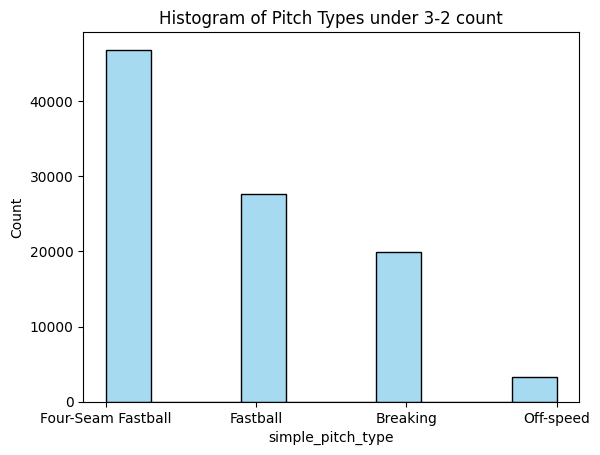

In [ ]:
sns.histplot(data=EDA_df, x='simple_pitch_type', discrete=False, color='skyblue', binwidth = 0.3)
plt.title('Histogram of Pitch Types at first pitch')

It appears that four-seam fastballs are the dominant kind of pitch as the first one. It's fast and easy to command, an ideal tool to get a strike. Following by fastball, breaking ball and off-speed, the ranking follows the overall distribution. However, we can see there's significantly less off-speed pitches being used as first pitch.

Text(0.5, 1.0, 'Histogram of Pitch Zones at First Pitch')

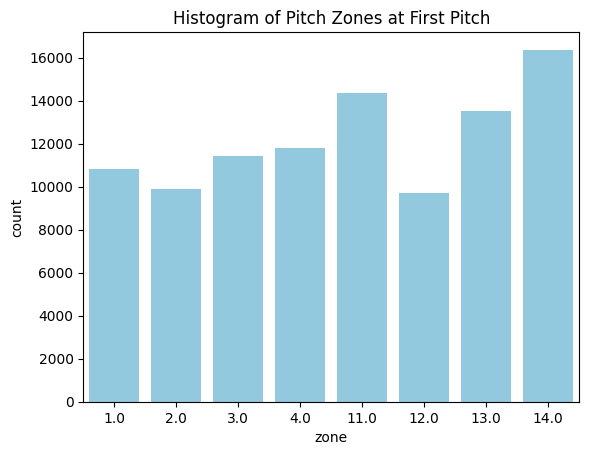

In [ ]:
count_data = EDA_df['zone'].value_counts().reset_index()
count_data.columns = ['zone', 'count']

# Plotting the bar plot
sns.barplot(x='zone', y='count', data=count_data, color='skyblue')

plt.title('Histogram of Pitch Zones at First Pitch')

First pitch can be considered as 0-0 count. It appears that each pitcher approach the zone placement differently. There's no clear pattern, although zone 11 and 14 receives more pitches than the other zone. This is not a big surprise as it aligns with the overall distrubtion.

### Pitch by Pitch

Lastly, we will quickly examine the pitch by pitch sequence, trying to see the most common pitching mix.

In [ ]:
df = input_df[['prvs_pitch_Four-Seam Fastball','prvs_pitch_Breaking','prvs_pitch_Fastball','prvs_pitch_Off-speed','prvs_pitch_First Pitch']]

In [ ]:
# Reverse dummies of previous pitch type
df['prvs_pitch'] = df.idxmax(axis=1).str.replace('prvs_pitch_', '')

<ipython-input-200-307069e83aab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prvs_pitch'] = df.idxmax(axis=1).str.replace('prvs_pitch_', '')


Text(0.5, 1.0, 'Histogram of Pitch Type Combo')

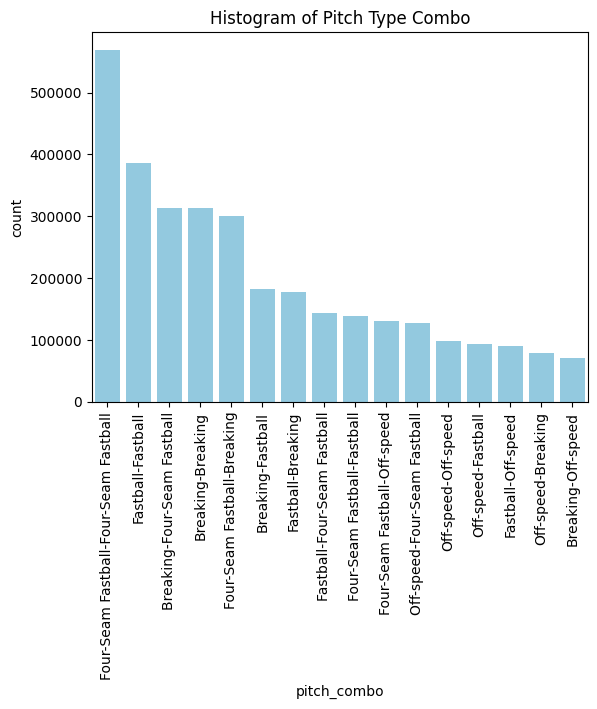

In [ ]:
EDA_df = pd.concat([input_df['simple_pitch_type'], df['prvs_pitch']], axis=1)
# First pitch is just a placeholder.
EDA_df = EDA_df[EDA_df['prvs_pitch']!= 'First Pitch']
#Create the pitch- previous pitch string data
EDA_df['pitch_combo'] = EDA_df['simple_pitch_type'] + '-' + EDA_df['prvs_pitch']
EDA_df['pitch_combo'].value_counts()
count_data = EDA_df['pitch_combo'].value_counts().reset_index()
count_data.columns = ['pitch_combo', 'count']

# Plotting the bar plot
sns.barplot(x='pitch_combo', y='count', data=count_data, color='skyblue')
plt.xticks(rotation=90)
plt.title('Histogram of Pitch Type Combo')

It appears that pitchers tends to throw same types of pitches. We see two consecutive four-seam fastballs, consecutive fastballs and consecutive breaking balls in the top five combinations.

The famous combo of fastball-offspped is not very popular due to the low amount of off-speed pitches.

## Baseline Model - Trail


In this section, we will look at different models with the pitcher throwing most pitches during the time span first. This will give us a quick result comparison between models. I will load the entire dataset to the model in a similar structure in the next section.

- Our baseline model will be a recurrent neural network. The purpose of this model is to capture the sequential feature of a baseball game. The dataset is constructed as pitch-by-pitch script, making it easy to generate sequences to train a RNN model.

- We will use some other simple models like logistic regression/decision tree as supplementary models.

#### Trial RNN Model on One Pitcher

Here we will read the final dataframe 'input_df' directly to save time.

In [ ]:
input_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

##### Test of Independence on target variables

Is the pitch type and pitch area related? In real game situaions, it might be the case. For example, curve ball usually lands at the bottom half of the strike zone due to the vertical breaking. Sweeper, slider usually doesn't land in the middle due to the horizontal breaking.

We will examine if this correlation exists after we classified the two targets.

In [ ]:
pitch_type_chi = input_df['simple_pitch_type_enc'].astype(str)
zone_chi = input_df['zone'].astype(str)

import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a DataFrame `df` with two categorical columns 'col1' and 'col2'
contingency_table = pd.crosstab(pitch_type_chi, zone_chi)
print(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)
if p < 0.05:
    print("There is a significant association between the two variables.")
else:
    print("There is no significant association between the two variables.")

zone                      1.0    11.0    12.0    13.0    14.0     2.0     3.0  \
simple_pitch_type_enc                                                           
1                      143400  204259  165561  129245  158962  141420  117953   
2                       59509   65795   48791  157312  298019   58034   94806   
3                       75407  110675   75753  149496  148196   69615   99036   
4                       19963   39311   22306  113478   98932   14698   50548   

zone                      4.0  
simple_pitch_type_enc          
1                      126053  
2                      116818  
3                       96595  
4                       41613  
There is a significant association between the two variables.


As above test shows, zone and pitch type has a significant relationship. When choosing and building models, we should consider this correlation.

##### Finding the Most Hardworking Pitcher

In [ ]:
input_df['pitcher_id'].value_counts()

,count
pitcher_id,
434378,15302
545333,14565
500779,14562
519144,14444
453286,14423
...,...
545358,5
640447,3
506560,3


In [ ]:
len(input_df['pitcher_id'].unique())

1511

We will study the famous Justin Valender, the 3 time Cy Young award winner as our test pitcher.

In [ ]:
test_pitcher_df = input_df[input_df['pitcher_id'].isin([434378])]

In [ ]:
test_pitcher_df

,Unnamed: 0.1,Unnamed: 0,px,pz,start_speed,end_speed,sz_bot,sz_top,zone,type,...,prvs_ab_Slug,simple_weather_clear,simple_weather_cloudy,simple_weather_dome,simple_weather_drizzle,simple_weather_overcast,simple_weather_rain,simple_weather_snow,simple_weather_sunny,simple_pitch_type_enc
127681,127681,127681,-0.50,2.36,92.10,84.70,1.46,3.27,3.00,S,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127682,127682,127682,-0.41,1.30,92.00,84.60,1.46,3.27,13.00,B,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127683,127683,127683,-0.23,1.67,84.70,78.70,1.46,3.27,3.00,X,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4
127684,127684,127684,-1.34,3.41,92.50,85.80,1.57,3.45,11.00,B,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
127685,127685,127685,-1.16,2.80,92.80,85.50,1.57,3.45,11.00,S,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310562,1625585,1625585,-0.58,3.01,94.60,85.40,1.49,3.06,1.00,S,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3310563,1625586,1625586,1.31,1.97,80.40,74.10,1.50,2.99,14.00,B,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2
3310564,1625587,1625587,0.02,3.82,94.80,85.50,1.49,3.06,12.00,T,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3310565,1625588,1625588,-0.38,2.47,94.00,85.70,1.67,3.50,3.00,C,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1


##### Encoding Target Variables

Becase we wil use softmax layer as out final output, we need to encode our target variable starting from 0 to match the output for accuracy analysis.

In [ ]:
test_pitcher_df['simple_pitch_type_enc'].value_counts()

,count
simple_pitch_type_enc,
1,8710
2,5719
4,827
3,46


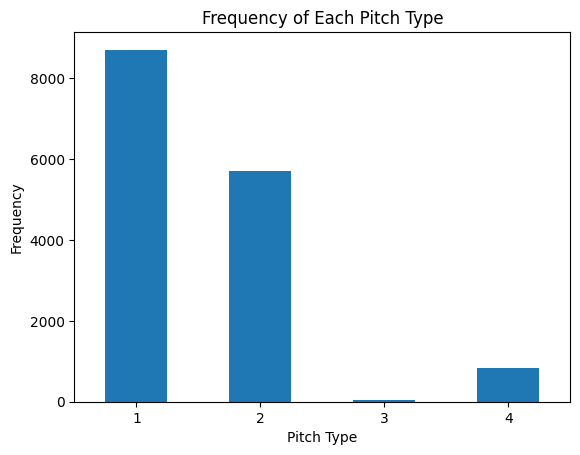

In [ ]:
pitch_counts = test_pitcher_df['simple_pitch_type_enc'].value_counts().sort_index()

# Plotting the bar plot
pitch_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Pitch Type')

plt.show()

From the pitch type distribution, we can tell that Justin throws four-seam fastball most, followed by other kinds of fastball. His third pitch is off-speed, and he rarely throw breaking balls.

Note that he mainly throw fastballs. The data is very imbalanced.

In [ ]:
test_pitcher_df['zone'].value_counts()

,count
zone,
14.00,3423
11.00,2355
12.00,1930
2.00,1884
4.00,1838
1.00,1519
3.00,1218
13.00,1135


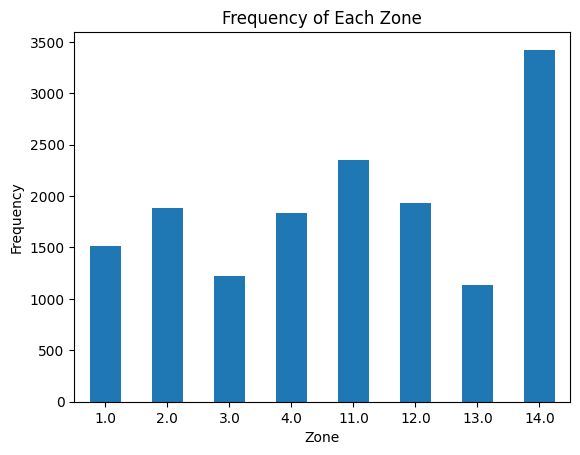

In [ ]:
zone_counts = test_pitcher_df['zone'].value_counts().sort_index()

# Plotting the bar plot
zone_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Each Zone')

plt.show()

From the pitch type distribution, we can tell that Justin throws fairly even to differnet zones except a outlier of zone 14.

We will build a dictionary for this.
Note that there's no zone 10, so zone 11 will be encoded as 9, and zone 12-14 will follow.

In [ ]:
dictionary_class = {
  1:0,
  2:1,
  3:2,
  4:3,
  11:4,
  12:5,
  13:6,
  14:7,
}

In [ ]:
#Updated Zone column to newly encoded version
new_class = [dictionary_class[class_name] for class_name in test_pitcher_df['zone']]
test_pitcher_df['zone'] = new_class

<ipython-input-357-8428bcf36058>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pitcher_df['zone'] = new_class


In [ ]:
#Updated pitch type column to newly encoded version
new_class = [dictionary_class[class_name] for class_name in test_pitcher_df['simple_pitch_type_enc']]
test_pitcher_df['simple_pitch_type_enc'] = new_class

<ipython-input-358-f5fb949bfca3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pitcher_df['simple_pitch_type_enc'] = new_class


Before we hand the dataset to models, we have to remove some other columns:
- speed : Human won't be able to measure the s0peed of 70mph - 90mph by bare eye. It's a data summarized after the pitch is thrown.
- px & pz: We've converted this to 'zone' target
- o : This is the out *after* the pitch is thrown, which is a future event.
- type/simple_type: This is the result of the pitch, which is a future event.
- g_id/top : This is an indication/index of game progress. We are not using them to partitioning the dataset.
- simple_pitch_type: We've encoded this column.


In [ ]:
test_pitcher_df = test_pitcher_df.drop(columns = ['start_speed','end_speed','px','pz','Unnamed: 0','o','g_id','top','simple_pitch_type','type','simple_type'])

In [ ]:
test_pitcher_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15302 entries, 127681 to 3310566
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0.1                   15302 non-null  int64  
 1   sz_bot                         15302 non-null  float64
 2   sz_top                         15302 non-null  float64
 3   zone                           15302 non-null  int64  
 4   b_score                        15302 non-null  float64
 5   ab_id                          15302 non-null  float64
 6   b_count                        15302 non-null  float64
 7   s_count                        15302 non-null  float64
 8   outs                           15302 non-null  float64
 9   pitch_num                      15302 non-null  float64
 10  on_1b                          15302 non-null  float64
 11  on_2b                          15302 non-null  float64
 12  on_3b                          15302 non-nul

##### Split Dataframe by at-bat

We are going to split the dataset to a dicitonary by at-bat. VERY rarely will pitchers rally each other on the same at-bat. By doing this, every time the machine is learning the pattern of one pitcher throwing to one batter.

In [ ]:
# Initialize the dictionary to store the data
ab_data_df = {}
ab_list = test_pitcher_df['ab_id'].unique()

for ab_number in ab_list:
    ab_data_df[ab_number] = test_pitcher_df[test_pitcher_df['ab_id'] == ab_number].drop(columns = ['ab_id','pitcher_id'])


##### Create Sequence

The purpose of creating sequence is to create sub_dataframe for every 3 pitches in each at bat.
If an at-bat has 5 pitches, then 3 dataframe will be generated: pitch 1-3, 2-4 and 3-5.

In [ ]:
seq_length = 3
target_columns = ['zone', 'simple_pitch_type_enc']
all_X, all_y = [], []

def create_sequences(df, seq_length, target_columns):
    xs, ys = [], []
    for i in range(len(df) - seq_length + 1):
        x = df.iloc[i:i + seq_length].drop(columns=target_columns).values
        y = df.iloc[i + seq_length - 1][target_columns].values
        xs.append(x)
        ys.append(y)
    # Reshape the arrays to ensure consistent dimensions
    return np.array(xs).reshape(-1, seq_length, df.shape[1] - len(target_columns)), np.array(ys)

for ab_id, data in ab_data_df.items():
    X, y = create_sequences(data, seq_length, target_columns)
    # Append only if sequences were created
    if X.size > 0:
       all_X.append(X)
       all_y.append(y)
#Combine all sequences and labels
# Handle the case where all_X might be empty
if all_X:
  X = np.concatenate(all_X)
  y = np.concatenate(all_y)
else:
    print("No sequences were created. Check your data and sequence length.")
    X = np.array([])
    y = np.array([])

We can see that each element of X contains three rows of data.

In [ ]:
X

array([[[1.276810e+05, 1.460000e+00, 3.270000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276820e+05, 1.460000e+00, 3.270000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276830e+05, 1.460000e+00, 3.270000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]],

       [[1.276840e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276850e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276860e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]],

       [[1.276850e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276860e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.276870e+05, 1.570000e+00, 3.450000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]],

       ...,

       [[

In [ ]:
y

array([[2., 3.],
       [4., 1.],
       [7., 1.],
       ...,
       [3., 1.],
       [7., 1.],
       [5., 0.]])

##### Train-Test Split, Tensorizing and Data loading

We have to convert data to tensor form when traning RNN model with pytorch.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Reshape to 2D for scaling
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler().fit(X_train_2D)
X_train_scaled = scaler.transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

# Reshape back to 3D for the model training
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [ ]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test)

# Create DataLoader objects for bigger dataset
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##### Class Weight

Class weight is one of the method to help with class imbalance. Justin rarely throw off-speed and breaking ball, making it very difficult to balance the class even with a weight. His zone distribution only has mild imbalance, we will see if it will help.

In [ ]:
# Calculate class weights for output1 (8 classes)
classes1, counts1 = np.unique(y_train[:, 0], return_counts=True)
total_samples1 = len(y_train[:, 0])
class_weights1 = total_samples1 / (len(classes1) * counts1)
class_weights1 = torch.tensor(class_weights1, dtype=torch.float32)

# Calculate class weights for output2 (4 classes)
classes2, counts2 = np.unique(y_train[:, 1], return_counts=True)
total_samples2 = len(y_train[:, 1])
class_weights2 = total_samples2 / (len(classes2) * counts2)

if class_weights2.shape != (4,):
    class_weights2 = np.append(class_weights2, 0)
class_weights2 = torch.tensor(class_weights2, dtype=torch.float32)

##### RNN Model Test Pitcher

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size1, output_size2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Shared fully connected layer with fewer neurons
        #self.shared_fc = nn.Linear(hidden_size, hidden_size // 2)

        # Output-specific fully connected layers with increased capacity
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.out1 = nn.Linear(hidden_size, output_size1)
        self.out2 = nn.Linear(hidden_size, output_size2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        out1 = F.relu(self.fc1(out))

        out1 = self.dropout1(out1)
        out1 = self.out1(out1)

        out2 = F.relu(self.fc2(out))
        out2 = self.dropout2(out2)
        out2 = self.out2(out2)

        return out1, out2

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size1 = 8  # Number of classes for the first target
output_size2 = 4  # Number of classes for the second target

# Initialize and print the model
model = RNNModel(input_size, hidden_size, output_size1, output_size2)
print(model)

RNNModel(
  (rnn): RNN(54, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=8, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


##### Training



In [ ]:
import torch.optim as optim

# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss(weight=class_weights1)  # For output1 with 8 classes
criterion2 = nn.CrossEntropyLoss(weight=class_weights2)  # For output2 with 4 classes
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs1, outputs2 = model(X_train_tensor)

    loss1 = criterion1(outputs1, (y_train_tensor[:, 0]).long())
    loss2 = criterion2(outputs2, (y_train_tensor[:, 1]).long())

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 3.4947195053100586
Epoch 2/20, Loss: 3.4754815101623535
Epoch 3/20, Loss: 3.4665424823760986
Epoch 4/20, Loss: 3.4652252197265625
Epoch 5/20, Loss: 3.4599318504333496
Epoch 6/20, Loss: 3.459563732147217
Epoch 7/20, Loss: 3.449744701385498
Epoch 8/20, Loss: 3.433579921722412
Epoch 9/20, Loss: 3.4326672554016113
Epoch 10/20, Loss: 3.4299428462982178
Epoch 11/20, Loss: 3.4153032302856445
Epoch 12/20, Loss: 3.387253999710083
Epoch 13/20, Loss: 3.379270553588867
Epoch 14/20, Loss: 3.392902135848999
Epoch 15/20, Loss: 3.3728435039520264
Epoch 16/20, Loss: 3.3846845626831055
Epoch 17/20, Loss: 3.369556188583374
Epoch 18/20, Loss: 3.361429214477539
Epoch 19/20, Loss: 3.348679542541504
Epoch 20/20, Loss: 3.331160545349121


##### Evaluation

We will look evaluate the model with loss, accuracy and review of raw output.

###### Training Loss v.s. Test Loss

In [ ]:
model.eval()
with torch.no_grad():
    y_pred1, y_pred2 = model(X_test_tensor) # Unpack both outputs of the model
    y_train_pred1, y_train_pred2 = model(X_train_tensor) # Unpack both outputs of the model
    train_loss1 = criterion1(y_train_pred1, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    train_loss2 = criterion2(y_train_pred2, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Train Loss 1: {train_loss1.item():.4f}, Train Loss 2: {train_loss2.item():.4f}')
    # Assuming y_test_tensor also needs to be split for two outputs
    test_loss1 = criterion1(y_pred1, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    test_loss2 = criterion2(y_pred2, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Test Loss 1: {test_loss1.item():.4f}, Test Loss 2: {test_loss2.item():.4f}')

Train Loss 1: 2.0529, Train Loss 2: 1.3370
Test Loss 1: 2.0514, Test Loss 2: 1.3337


When fine tuning the model, we will see if the loss is reduced.

###### Accuracy Score

We should compare the predicted value of both target variables with the actual value to get the accuracy score. This also helps with real-life application

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

# Make predictions
with torch.no_grad():
    y_pred1, y_pred2 = model(X_test_tensor)

    # Check if y_test needs to be split for two outputs and adjust accordingly
    # For example, if y_test is a 2D array where each row represents multiple labels:
    y_test_1 = y_test[:, 0]  # Assuming the first column corresponds to the first output
    y_test_2 = y_test[:, 1]  # Assuming the second column corresponds to the second output

    # Convert model outputs to class predictions
    classification1 = y_pred1.argmax(dim=1).cpu().numpy()
    classification2 = y_pred2.argmax(dim=1).cpu().numpy()

# Calculate accuracy for each output separately
accuracy1 = accuracy_score(y_test_1, classification1)
accuracy2 = accuracy_score(y_test_2, classification2)


print(f"Accuracy score on test set for zone prediction: {round(accuracy1 * 100, 2)}%")

print(f"Accuracy score on test set for pitch type prediction: {round(accuracy2 * 100, 2)}%")


Accuracy score on test set for zone prediction: 18.58%
Accuracy score on test set for pitch type prediction: 40.47%


Based on the accuracy score, our zone prediction performed very badly. Pitch type prediction looks better. However, if the model predicts all pitch to be four-seam fastball, it will reach 36% accuracy. We need a big improvement on RNN model or just try other model.

We will look at the classification report to gain more insights.

###### Prediction

Reviewing prediction set is the last step.

In [ ]:
# During evaluation, apply softmax to the outputs to get probabilities
with torch.no_grad():
    logits1, logits2 = model(X_test_tensor)
    probabilities1 = F.softmax(logits1, dim=1)
    probabilities2 = F.softmax(logits2, dim=1)
    predictions1 = probabilities1.argmax(dim=1)
    predictions2 = probabilities2.argmax(dim=1)
    print("Logits 1:", logits1)
    print("Probabilities 1:", probabilities1)
    print("Predictions 1:", predictions1)
    print("Logits 2:", logits2)
    print("Probabilities 2:", probabilities2)
    print("Predictions 2:", predictions2)

Logits 1: tensor([[ 0.0466,  0.1043, -0.1202,  ..., -0.0432, -0.0453,  0.1455],
        [ 0.0994, -0.0926, -0.1324,  ..., -0.0322,  0.2429, -0.0141],
        [ 0.1325, -0.0475,  0.0330,  ..., -0.0012, -0.0260,  0.1076],
        ...,
        [ 0.0102, -0.0378,  0.0167,  ..., -0.0038,  0.0659,  0.0435],
        [ 0.0128,  0.0097, -0.0970,  ..., -0.0138,  0.1396,  0.0720],
        [ 0.2978,  0.0181,  0.1375,  ...,  0.0251, -0.3111, -0.2935]])
Probabilities 1: tensor([[0.1334, 0.1413, 0.1129,  ..., 0.1219, 0.1217, 0.1473],
        [0.1390, 0.1147, 0.1102,  ..., 0.1219, 0.1605, 0.1241],
        [0.1386, 0.1158, 0.1255,  ..., 0.1213, 0.1183, 0.1352],
        ...,
        [0.1244, 0.1186, 0.1252,  ..., 0.1227, 0.1315, 0.1286],
        [0.1250, 0.1246, 0.1120,  ..., 0.1218, 0.1420, 0.1327],
        [0.1611, 0.1218, 0.1373,  ..., 0.1227, 0.0876, 0.0892]])
Predictions 1: tensor([7, 6, 0,  ..., 6, 6, 4])
Logits 2: tensor([[-0.4012, -0.3516,  1.0125, -0.6891],
        [-0.1649, -0.0376, -0.1835,  

In [ ]:
print(f"Classification report for zone prediction")
print(classification_report(y_test_1, classification1))
print(f"Classification report for pitch type prediction")
print(classification_report(y_test_2, classification2))

Classification report for zone prediction
              precision    recall  f1-score   support

         0.0       0.14      0.23      0.17       159
         1.0       0.17      0.08      0.10       211
         2.0       0.08      0.09      0.09       116
         3.0       0.12      0.03      0.05       180
         4.0       0.18      0.41      0.25       238
         5.0       0.15      0.04      0.06       220
         6.0       0.10      0.21      0.13        96
         7.0       0.34      0.27      0.30       411

    accuracy                           0.19      1631
   macro avg       0.16      0.17      0.14      1631
weighted avg       0.19      0.19      0.17      1631

Classification report for pitch type prediction
              precision    recall  f1-score   support

         0.0       0.66      0.42      0.52       851
         1.0       0.59      0.37      0.45       693
         2.0       0.00      0.20      0.01         5
         3.0       0.10      0.51      0.1

For zone prediction, the accuracy itself is not good. F1 score on all eight classes are not high as well. Zone 14 and zone 11 have relative high scores. This is likely due to the more observations in both classes.

For pitch type prediction, we can easily notice that prediction on breaking ball is horrible, with a F1 score of 0.01. The prediction power on the other three pitch types are acceptable. Specifically, the model can identify quick a lot of fastballs, but will miss several. On the other hand, the model  labels many other types as off speed pitch incorrectly.

#### Baseline Trial Model for One Pitcher - Softmax Regression

Due to the terrible result of RNN model, I will use softmax regression as an alternative for prediction for comparison.

###### Softmax Regression on Zone

In [ ]:
X = test_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','ab_id','pitcher_id','Unnamed: 0.1'])
y = test_pitcher_df[['zone','simple_pitch_type_enc']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15302 entries, 127681 to 3310566
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sz_bot                         15302 non-null  float64
 1   sz_top                         15302 non-null  float64
 2   b_score                        15302 non-null  float64
 3   b_count                        15302 non-null  float64
 4   s_count                        15302 non-null  float64
 5   outs                           15302 non-null  float64
 6   pitch_num                      15302 non-null  float64
 7   on_1b                          15302 non-null  float64
 8   on_2b                          15302 non-null  float64
 9   on_3b                          15302 non-null  float64
 10  inning                         15302 non-null  float64
 11  p_score                        15302 non-null  float64
 12  p_throws                       15302 non-nul

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Reshape X_train to 2D if it's 3D
if X_train.ndim == 3:
    X_train = X_train.reshape(X_train.shape[0], -1)
if X_test.ndim == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, class_weight = 'balanced')
model.fit(X_train, y_train.iloc[:,0]) # fit zone data


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test.iloc[:,0], y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:,0], y_pred))

[7 2 4 ... 2 1 4]
Accuracy: 0.21
              precision    recall  f1-score   support

           0       0.10      0.10      0.10       291
           1       0.19      0.16      0.17       379
           2       0.11      0.13      0.12       210
           3       0.17      0.15      0.16       391
           4       0.25      0.19      0.21       506
           5       0.20      0.24      0.22       385
           6       0.15      0.34      0.21       212
           7       0.37      0.30      0.33       687

    accuracy                           0.21      3061
   macro avg       0.19      0.20      0.19      3061
weighted avg       0.22      0.21      0.21      3061



This model is doing slightly better than the RNN model. However, we can tell that this model is bad predicting at predicint strikes. All precision scores, recall scores and f1 scores for zone 1-4 are below 0.2. The prediction of balls are better.

This is most likely due to the class imbalance.

##### Softmax Regression on Pitch Type

In [ ]:
model1.fit(X_train, y_train.iloc[:,1])


y_pred = model1.predict(X_test)

accuracy = accuracy_score(y_test.iloc[:,1], y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:,1], y_pred))

[1 0 1 ... 1 0 0]
Accuracy: 0.37
              precision    recall  f1-score   support

           0       0.68      0.33      0.44      1729
           1       0.53      0.41      0.46      1176
           2       0.01      0.50      0.01         6
           3       0.10      0.49      0.17       150

    accuracy                           0.37      3061
   macro avg       0.33      0.43      0.27      3061
weighted avg       0.59      0.37      0.44      3061



Due to the smaller number of classes, the model performs better when predicting pitch type. However, this model has a high precision score and low recall score on Four-seam and other fastballs, while a horrible precision score on breaking ball as well as off-speed. This is fair because Justin doesn't throw both kinds very often.

In conclusion, when looking at specific player, the model doesn't perform well with class imbalance. We will train the model with complete dataset with mild imbalance to see the performance.

## Baseline - Full Dataset

#### Model Using RNN

Now we will use the full dataset for the models that have been tested earlier.

One of the drawback is that we are treating ~1500 pitchers as one pitcher. In real-life situations, every pitcher is unique. We are assuming pitcher will only throw based on the on-field situation without any personalization here.

We will re-read the dataset.

In [ ]:
full_pitcher_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

##### Encoding Target Variables

Becase we wil use softmax layer as out final output, we need to encode our target variable starting from 0 to match the output for accuracy analysis.

In [ ]:
full_pitcher_df['simple_pitch_type_enc'].value_counts()

,count
simple_pitch_type_enc,
1,1186853
2,899084
3,824773
4,400849


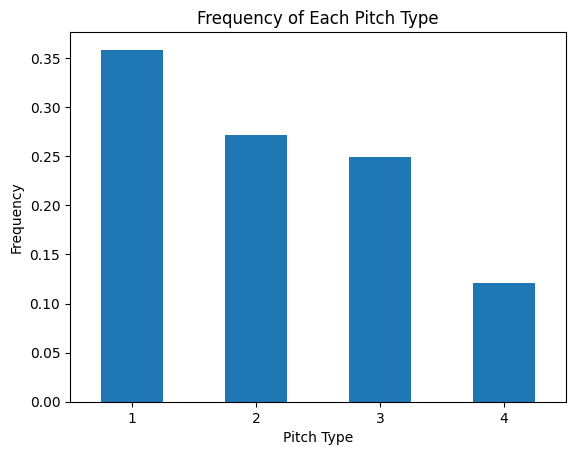

In [ ]:
pitch_counts = full_pitcher_df['simple_pitch_type_enc'].value_counts(normalize = True).sort_index()

# Plotting the bar plot
pitch_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Pitch Type')

plt.show()

In [ ]:
full_pitcher_df['zone'].value_counts()

,count
zone,
14.00,704109
13.00,549531
11.00,420040
4.00,381079
3.00,362343
12.00,312411
1.00,298279
2.00,283767


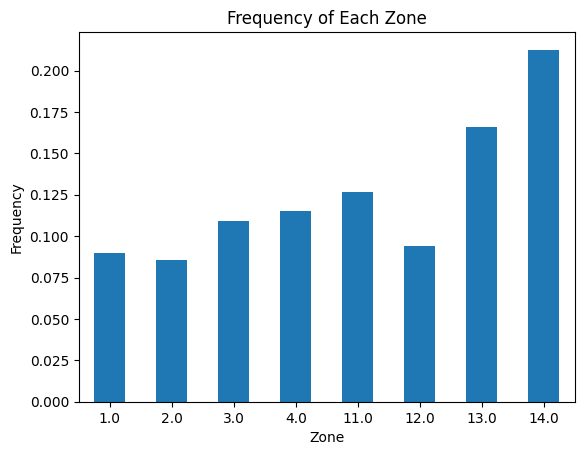

In [ ]:
zone_counts = full_pitcher_df['zone'].value_counts(normalize = True).sort_index()

# Plotting the bar plot
zone_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Each Zone')

plt.show()

We will build a dictionary for this.
Note that there's no zone 10, so zone 11 will be encoded as 9, and zone 12-14 will follow.

In [ ]:
dictionary_class = {
  1:0,
  2:1,
  3:2,
  4:3,
  11:4,
  12:5,
  13:6,
  14:7,
}

In [ ]:
new_class = [dictionary_class[class_name] for class_name in full_pitcher_df['zone']]
full_pitcher_df['zone'] = new_class

In [ ]:
new_class = [dictionary_class[class_name] for class_name in full_pitcher_df['simple_pitch_type_enc']]
full_pitcher_df['simple_pitch_type_enc'] = new_class

In [ ]:
full_pitcher_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 69 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0.1                   int64  
 1   Unnamed: 0                     int64  
 2   px                             float64
 3   pz                             float64
 4   start_speed                    float64
 5   end_speed                      float64
 6   sz_bot                         float64
 7   sz_top                         float64
 8   zone                           int64  
 9   type                           object 
 10  b_score                        float64
 11  ab_id                          float64
 12  b_count                        float64
 13  s_count                        float64
 14  outs                           float64
 15  pitch_num                      float64
 16  on_1b                          float64
 17  on_2b                          float64
 18  on

Some of the columns need to be removed:
- speed : Human won't be able to measure the speed by bare eye.
- px & pz: We've converted this to 'zone' target
- o : This is the out *after* the pitch is thrown, which is a future event.
- type/simple_type: This is the result of the pitch, which is a future event.
- g_id/top : This is an indication/index of game progress. We are not using them to partitioning the dataset.
- simple_pitch_type: We've encoded this column.


In [ ]:
full_pitcher_df = full_pitcher_df.drop(columns = ['start_speed','end_speed','px','o','pz','Unnamed: 0','g_id','top','simple_pitch_type','Unnamed: 0.1','type','simple_type'])


##### Split Dataframe by at-bat

We are partitioning the dataset based on at-bat id. By doing this, we ensure that sequence are correctly generated with a start point and an end point.

In [ ]:
# Initialize the dictionary to store the data
ab_data_df = {}
ab_list = full_pitcher_df['ab_id'].unique()

for ab_number in ab_list:
    ab_data_df[ab_number] = full_pitcher_df[full_pitcher_df['ab_id'] == ab_number].drop(columns = ['ab_id','pitcher_id'])

##### Create Sequence

The purpose of creating sequence is to create sub_dataframe for every 3 pitches in each at bat.
If an at-bat has 5 pitches, then 3 dataframe will be generated: pitch 1-3, 2-4 and 3-5.

In [ ]:
seq_length = 3
target_columns = ['zone', 'simple_pitch_type_enc']
all_X, all_y = [], []

def create_sequences(df, seq_length, target_columns):
    xs, ys = [], []
    for i in range(len(df) - seq_length + 1):
        x = df.iloc[i:i + seq_length].drop(columns=target_columns).values
        y = df.iloc[i + seq_length - 1][target_columns].values
        xs.append(x)
        ys.append(y)
    # Reshape the arrays to ensure consistent dimensions
    return np.array(xs).reshape(-1, seq_length, df.shape[1] - len(target_columns)), np.array(ys)
for ab_id, data in ab_data_df.items():
    X, y = create_sequences(data, seq_length, target_columns)
    # Append only if sequences were created
    if X.size > 0:
       all_X.append(X)
       all_y.append(y)
#Combine all sequences and labels
# Handle the case where all_X might be empty
if all_X:
  X = np.concatenate(all_X)
  y = np.concatenate(all_y)
else:
    print("No sequences were created. Check your data and sequence length.")
    X = np.array([])
    y = np.array([])

In [ ]:
X

array([[[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ]],

       [[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.74, 3.35, 0.  , ..., 0.  , 0.  , 0.  ]],

       [[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.74, 3.35, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ]],

       ...,

       [[1.43, 3.24, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.62, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ]],

       [[1.62, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.65, 3.31, 4.  , ..., 0.  , 0.  , 0.  ]],

       [[1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.65, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.31, 4.  , ..., 0.  , 0.  , 0.  ]]])

##### Train-Test Split, Tensorizing and Data loading

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Reshape to 2D for scaling
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler().fit(X_train_2D)
X_train_scaled = scaler.transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

# Reshape back to 3D for your model
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [ ]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test)

# Create DataLoader objects for bigger dataset
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##### Class Weight

When we are encoding the target variables, there is a class imbalance problems for both targets. Fastball accounts for 50% of the total pitches, and ball zone (zone 11-14) accounts for 67% of the total pitches. We should calculate the class weight and apply it to the weight loss, hoping it will improve the performance of the model.

In [ ]:
# Calculate class weights for output1 (8 classes)
classes1, counts1 = np.unique(y_train[:, 0], return_counts=True)
total_samples1 = len(y_train[:, 0])
class_weights1 = total_samples1 / (len(classes1) * counts1)
class_weights1 = torch.tensor(class_weights1, dtype=torch.float32)

# Calculate class weights for output2 (4 classes)
classes2, counts2 = np.unique(y_train[:, 1], return_counts=True)
total_samples2 = len(y_train[:, 1])
class_weights2 = total_samples2 / (len(classes2) * counts2)

if class_weights2.shape != (4,):
    class_weights2 = np.append(class_weights2, 0)
class_weights2 = torch.tensor(class_weights2, dtype=torch.float32)

##### RNN Model with Full data


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size1, output_size2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Shared fully connected layer with fewer neurons
        self.shared_fc = nn.Linear(hidden_size, hidden_size // 2)

        # Output-specific fully connected layers with increased capacity
        self.fc1 = nn.Linear(hidden_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size)

        self.out1 = nn.Linear(hidden_size, output_size1)
        self.out2 = nn.Linear(hidden_size, output_size2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        # Shared layer
        shared_out = F.relu(self.shared_fc(out))
        #out1 = F.relu(self.fc1(out))

        # Output 1 branch with increased capacity
        out1 = F.relu(self.fc1(shared_out))
        out1 = self.dropout1(out1)
        out1 = self.out1(out1)

        # Output 2 branch with increased capacity
        out2 = F.relu(self.fc2(shared_out))
        #out2 = F.relu(self.fc2(out))
        out2 = self.dropout2(out2)
        out2 = self.out2(out2)

        return out1, out2

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size1 = 8  # Number of classes for the first target
output_size2 = 4  # Number of classes for the second target

# Initialize and print the model
baseline_RNN_full_model = RNNModel(input_size, hidden_size, output_size1, output_size2)
print(baseline_RNN_full_model)




RNNModel(
  (rnn): RNN(53, 50, batch_first=True)
  (shared_fc): Linear(in_features=50, out_features=25, bias=True)
  (fc1): Linear(in_features=25, out_features=50, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=8, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


##### Training



In [ ]:
import torch.optim as optim

# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss(weight=class_weights1)  # For output1 with 8 classes
criterion2 = nn.CrossEntropyLoss(weight=class_weights2)  # For output2 with 4 classes
optimizer = optim.Adam(baseline_RNN_full_model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    baseline_RNN_full_model.train()
    optimizer.zero_grad()
    outputs1, outputs2 = baseline_RNN_full_model(X_train_tensor)

    # Subtract 1 from y_train_tensor to shift the labels to the range 0-12
    loss1 = criterion1(outputs1, (y_train_tensor[:, 0]).long())
    loss2 = criterion2(outputs2, (y_train_tensor[:, 1]).long())

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 3.4816174507141113
Epoch 2/20, Loss: 3.4785690307617188
Epoch 3/20, Loss: 3.4754443168640137
Epoch 4/20, Loss: 3.4728055000305176
Epoch 5/20, Loss: 3.4701263904571533
Epoch 6/20, Loss: 3.467611312866211
Epoch 7/20, Loss: 3.4651317596435547
Epoch 8/20, Loss: 3.462512969970703
Epoch 9/20, Loss: 3.4602062702178955
Epoch 10/20, Loss: 3.457587957382202
Epoch 11/20, Loss: 3.455106258392334
Epoch 12/20, Loss: 3.4525341987609863
Epoch 13/20, Loss: 3.449798822402954
Epoch 14/20, Loss: 3.4469707012176514
Epoch 15/20, Loss: 3.4439570903778076
Epoch 16/20, Loss: 3.4407577514648438
Epoch 17/20, Loss: 3.4377007484436035
Epoch 18/20, Loss: 3.4342188835144043
Epoch 19/20, Loss: 3.430724859237671
Epoch 20/20, Loss: 3.4270851612091064


##### Evaluation

We will look evaluate the model with loss, accuracy and review of raw output.

###### Training Loss v.s. Test Loss

In [ ]:
baseline_RNN_full_model.eval()
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_model(X_test_tensor) # Unpack both outputs of the model
    y_train_pred1, y_train_pred2 = baseline_RNN_full_model(X_train_tensor) # Unpack both outputs of the model
    train_loss1 = criterion1(y_train_pred1, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    train_loss2 = criterion2(y_train_pred2, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Train Loss 1: {train_loss1.item():.4f}, Train Loss 2: {train_loss2.item():.4f}')
    # Assuming y_test_tensor also needs to be split for two outputs
    test_loss1 = criterion1(y_pred1, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    test_loss2 = criterion2(y_pred2, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Test Loss 1: {test_loss1.item():.4f}, Test Loss 2: {test_loss2.item():.4f}')

Train Loss 1: 2.1121, Train Loss 2: 1.3916
Test Loss 1: 2.1120, Test Loss 2: 1.3915


When fine tuning the model, we will see if the loss is reduced.

###### Accuracy Score

We should compare the predicted value of both target variables with the actual value to get the accuracy score. This also helps with real-life application

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_model(X_test_tensor)

    # Check if y_test needs to be split for two outputs and adjust accordingly
    # For example, if y_test is a 2D array where each row represents multiple labels:
    y_test_1 = y_test[:, 0]  # Assuming the first column corresponds to the first output
    y_test_2 = y_test[:, 1]  # Assuming the second column corresponds to the second output

    # Convert model outputs to class predictions
    classification1 = y_pred1.argmax(dim=1).cpu().numpy()
    classification2 = y_pred2.argmax(dim=1).cpu().numpy()

# Calculate accuracy for each output separately
accuracy1 = accuracy_score(y_test_1, classification1)
accuracy2 = accuracy_score(y_test_2, classification2)

print(f"Accuracy score on test set for Zone Prediction: {round(accuracy1 * 100, 2)}%")
print(f"Accuracy score on test set for Pitch Prediction: {round(accuracy2 * 100, 2)}%")

Accuracy score on test set for Zone Prediction: 13.64%
Accuracy score on test set for Pitch Prediction: 39.48%


In [ ]:
print(f"Classification report for zone prediction")
print(classification_report(y_test_1, classification1))
print(f"Classification report for pitch type prediction")
print(classification_report(y_test_2, classification2))

Classification report for zone prediction
              precision    recall  f1-score   support

         0.0       0.14      0.00      0.00     29959
         1.0       0.09      0.59      0.16     28718
         2.0       0.15      0.02      0.04     35579
         3.0       0.13      0.00      0.01     37329
         4.0       0.17      0.23      0.20     43545
         5.0       0.12      0.20      0.15     33504
         6.0       0.25      0.13      0.17     57417
         7.0       0.35      0.06      0.10     74314

    accuracy                           0.14    340365
   macro avg       0.18      0.15      0.10    340365
weighted avg       0.20      0.14      0.11    340365

Classification report for pitch type prediction
              precision    recall  f1-score   support

         0.0       0.53      0.30      0.39    121924
         1.0       0.37      0.57      0.45     94788
         2.0       0.39      0.43      0.41     79009
         3.0       0.24      0.20      0.2

From the classification report, there is a decrease on both accuracy when training with single player's profile.
- Zone prediction:
<ul>
- Zone 1,3,4 has basically no right prediction. This is not ideal as these are the strikes that's hittable.
- Zone 2 has a higher accuracy at 16%. However, the precision score is low. It's not a good model to predict pitches in zone 2.
- Zone 11,12,13 has a relatively balanced accuracy at around ~17%. I wouldn't consider it to be a good model.
- Zone 14 has a very low recall score. This model is not able to catching many of the pitches to zone 14. Considering zone 14 is the biggest class, this doesn't make sense.
</ul>
- Pitch Type prediction:
<ul>
- Four-seam fastball has a high precision and relatively low recall. The model can make moderately correct prediction on this kind of pitch, but has trouble to capture most of the positive instances.
- Other type of fastball has the opposite situation as four-seams.
- Prediction on breaking ball has been ok, although the accuracy didn't hit 50% benchmark.
- Prediction on off-spped pitch didn't perform well. Might have something to do with class imbalance.
<ul/>

#### Baseline - Model using Softmax Regression

The accuracy of RNN model has improved, but still below expectation to make it a good model. Can softmax regression model catch the pattern better? We will train the logistic regression model with same data to find out.

In [ ]:
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','ab_id','pitcher_id'])
y = full_pitcher_df[['zone','simple_pitch_type_enc']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 53 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   sz_bot                         float64
 1   sz_top                         float64
 2   b_score                        float64
 3   b_count                        float64
 4   s_count                        float64
 5   outs                           float64
 6   pitch_num                      float64
 7   on_1b                          float64
 8   on_2b                          float64
 9   on_3b                          float64
 10  inning                         float64
 11  p_score                        float64
 12  p_throws                       float64
 13  stand                          float64
 14  pitch_count                    int64  
 15  b_count_diff                   float64
 16  run_diff                       float64
 17  SPorRP                         int64  
 18  pr

In [ ]:
from sklearn.model_selection import train_test_split
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To make things a bit different, we will use undersample method to address the class imbalance issue. We were only able to use class weight to compensate in RNN model because SMOTE or undersample wiil break the sequence of the data.

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Assuming y_train has 2 columns for multi-output targets
y_train_1 = y_train.iloc[:, 0]  # Zone prediction
y_train_2 = y_train.iloc[:, 1]  # Pitch type prediction

# Apply SMOTE to each output column separately
undersampler = RandomUnderSampler(random_state=42)
X_resampled_1, y_resampled_1 = undersampler.fit_resample(X_train, y_train_1) # Zone prediction
X_resampled_2, y_resampled_2 = undersampler.fit_resample(X_train, y_train_2) # Pitch type prediction

###### Softmax Regression on Zone

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Reshape X_train to 2D if it's 3D
if X_resampled_1.ndim == 3:
    X_train = X_train.reshape(X_resampled_1.shape[0], -1)
if X_test.ndim == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Extract the first column of y_train as a Series using either .iloc or the column name
model.fit(X_resampled_1, y_resampled_1)  # Using .iloc for position-based indexing


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test.iloc[:, 0], y_pred)  # Use .iloc for consistency
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:, 0], y_pred))

[2 7 4 ... 1 0 6]
Accuracy: 0.22
              precision    recall  f1-score   support

           0       0.14      0.05      0.08     59725
           1       0.13      0.07      0.09     56942
           2       0.16      0.10      0.12     71888
           3       0.16      0.14      0.15     76186
           4       0.20      0.33      0.25     84113
           5       0.16      0.24      0.19     62451
           6       0.28      0.28      0.28    109779
           7       0.33      0.35      0.34    141228

    accuracy                           0.22    662312
   macro avg       0.19      0.20      0.19    662312
weighted avg       0.22      0.22      0.21    662312



There has been some improvements observed. Strike zone 1,2 still got a low accuracy, but at least the model is making some correct prediction while catching some right patterns. The overall accuracy is still not satisfying.

##### Softmax Regression on Pitch Type

In [ ]:
model.fit(X_resampled_2, y_resampled_2)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test.iloc[:, 1], y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:, 1], y_pred))

[0 1 2 ... 1 1 0]
Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.50      0.47      0.48    237612
           1       0.38      0.36      0.37    179582
           2       0.48      0.46      0.47    164654
           3       0.22      0.31      0.26     80464

    accuracy                           0.42    662312
   macro avg       0.40      0.40      0.40    662312
weighted avg       0.43      0.42      0.42    662312



A huge improvement from RNN model. Not only does the accuracy increases, the precision and recall score for all four pitch type predictions are more balanced. We should note that the model is giving a lower f1 score on other fastball and off-speed.

### Baseline - Model using XGboost

Given that the model can't give out a accuracy higher than 50%. Is it possible we can use ensemble learning and let the machine learn from its mistake? We will use the same data and train a xgboost model for some insights.

In [ ]:
!pip install xgboost
from sklearn.datasets import make_classification
from xgboost import XGBClassifier


In [ ]:
# Initialize the XGBoost classifier for multi-class classification
xgb_model_zone = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', max_depth = 10)

# Train the model
xgb_model_zone.fit(X_resampled_1, y_resampled_1)

# Predict the labels for the test set
y_pred = xgb_model_zone.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test.iloc[:, 0], y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:, 0], y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.22
              precision    recall  f1-score   support

           0       0.14      0.10      0.12     59725
           1       0.14      0.14      0.14     56942
           2       0.16      0.11      0.13     71888
           3       0.17      0.15      0.16     76186
           4       0.22      0.27      0.24     84113
           5       0.17      0.25      0.20     62451
           6       0.29      0.30      0.29    109779
           7       0.35      0.31      0.33    141228

    accuracy                           0.22    662312
   macro avg       0.20      0.21      0.20    662312
weighted avg       0.23      0.22      0.22    662312



There's no improvement in terms of accuracy score. However, the precision scores and recall scores are more balanced, leading to a improvement on f1-score.

In [ ]:
# Initialize the XGBoost classifier for multi-class classification
xgb_model_pitch = XGBClassifier(objective='multi:softmax', num_class=4, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', max_depth = 10)

# Train the model
xgb_model_pitch.fit(X_resampled_2, y_resampled_2)

# Predict the labels for the test set
y_pred = xgb_model_pitch.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test.iloc[:, 1], y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test.iloc[:, 1], y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:20:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.55      0.38      0.45    237612
           1       0.41      0.40      0.40    179582
           2       0.49      0.42      0.45    164654
           3       0.24      0.52      0.32     80464

    accuracy                           0.41    662312
   macro avg       0.42      0.43      0.41    662312
weighted avg       0.46      0.41      0.42    662312



Same as zone prediction, there's no improvement in terms of accuracy score comparing pitch type prediction between logistic regression and xgboost. In xgboost model, we can observe a parity on preicsion and recall for four seam fastball and off speed. This is interesting, as off speed is used to confuse hitter, thinking it will be a four seam fastball. They have almost identical trajectory, but off-speed is 20mph slower. Looks like the model is confused between these two kinds.

## Review and Conclusion from Baseline Modeling

In the above section, we tried to put the partial and full dataset into several baseline models. Here's some conclusions before proceeding to fine-tuning.

- Zone Prediction:
<ul>
<li> Prediction accuracy increases from 13% using RNN model to 22% with softmax logistic regresion/xgboost.
<li> Although there's improvement, 22% is not sufficient to make the model having predicting power. It's the same as predicting all pitches go to zone 14 (22% of the total pitches).
<li> The biggiest problem lies in that we are missing features of batter's info. In this model, we assume the pitcher make decisions based on previous info and current situation. They treat hitter as identical players except left-handed or right-handed. In reality, each batter usually has his own "sweet" zone/pitch type that has better batting average. Pitcher are learnt to avoid the sweet zones to make hitting hard for hitter.
<li> There also exists data quality issues. On average, an average MLB pitcher has a 3:2 strike-to-ball ratio. This means that 60% of the throws in this dataset should be in zone 1-9. In this dataset, the strike-to-ball ratio is 2:3. Roughly 60% of the throws are called ball.
</ul>


- Pitch Prediction:
<ul>
<li> Prediction accuracy increases from 40% using RNN model to 42% with softmax logistic regresion/xgboost.
<li> There's a chance to improve the accuracy further with the softmax logistic regression model, but it will be difficult to reach 50%.
<li> One of the problem is that each pitcher has his own skill set. Most pitchers only do 3 kind of pitches that they are able to command during the game. However, we are assuming every pitcher know all four kinds of pitches. In other words, the model will likely predict a breaking ball for a pitcher who only throws fastball and change-up.
<li> Another reason is regarding data quality. We had to drop 'type_confidence' column. It's an indicator of how accurate the record is, but the quality is poor. There's a lot of placeholders to remove, and numerical values range from 0 to 2 which is an abnormal way to describe confidence.
<li> When simplifying the pitch type, I classify 22 types of pitch to 4 types based on my domain knowledge and research. In fact, fastballs other than four-seam all has some breaking features. So some "other fastball" might be classifed as "breaking ball" in some instances.
</ul>


- Next Step:
<ul>
<li> First, we have proven that pitch type and zone are correlated with a test of independence. Due to the pitchers to look at, we will try to clustering them into several groups and apply machine learning to each cluster instead of the whole set.
<li> For zone prediction, we need to reduce the zone classes to 2. Class 0 is for zone 11-14, representing the pitch is NOT in the strike area. Class 1 is for zone 1-9, represending the pitch is in the strike area. Instead of looking at specific areas, we will simply predict if a throw will be a strike or a ball.
<ul>
<li>This change will reduce the power of the project. Strike zone is big ,not knowing specific area will increase the difficultiy of making a good contact with the pitch. However, this still has business meaning because it helps hitter to avoid chasing bad pitches, enhancing their plate discipline.

<li> For pitch type prediction, we will try improve the accuracy with the clustering and optimizing hyperparameter. Comparing to zone prediction, pitch type prediction involves more "personalization", so there should be a better result in each cluster.



### Re-classify 'Zone'

First, we will relabel the zone numbers to reflect "inside" or "outside" of the strike zone. 1 means the throw is a strike, while 0 means it's a ball.

In [ ]:
full_pitcher_df['zone'].unique()

array([1, 2, 0, 6, 3, 7, 4, 5])

In [ ]:
dictionary_zone_01 = {0:1,
                      1:1,
                      2:1,
                      3:1,
                      4:0,
                      5:0,
                      6:0,
                      7:0}

In [ ]:
new_class = [dictionary_zone_01[class_name] for class_name in full_pitcher_df['zone']]
full_pitcher_df['zone'] = new_class

In [ ]:
full_pitcher_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 57 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   sz_bot                         float64
 1   sz_top                         float64
 2   zone                           int64  
 3   b_score                        float64
 4   ab_id                          float64
 5   b_count                        float64
 6   s_count                        float64
 7   outs                           float64
 8   pitch_num                      float64
 9   on_1b                          float64
 10  on_2b                          float64
 11  on_3b                          float64
 12  inning                         float64
 13  p_score                        float64
 14  p_throws                       float64
 15  pitcher_id                     int64  
 16  stand                          float64
 17  pitch_count                    int64  
 18  b_

In [ ]:
full_pitcher_df['zone'].value_counts(normalize = True)

,proportion
zone,
0,0.60
1,0.40


In this dataset, 60% of the throws are ball, which the hitter should not chase. They need to focus on the strike, which is 40% of the total throws.

#### Softmax Regression on Ball or Strike

In [ ]:
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id'])
y = full_pitcher_df['zone']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 53 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   sz_bot                         float64
 1   sz_top                         float64
 2   b_score                        float64
 3   b_count                        float64
 4   s_count                        float64
 5   outs                           float64
 6   pitch_num                      float64
 7   on_1b                          float64
 8   on_2b                          float64
 9   on_3b                          float64
 10  inning                         float64
 11  p_score                        float64
 12  p_throws                       float64
 13  stand                          float64
 14  pitch_count                    int64  
 15  b_count_diff                   float64
 16  run_diff                       float64
 17  SPorRP                         int64  
 18  pr

In [ ]:

from sklearn.model_selection import train_test_split
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Because 60%-40% is not a terrible imbalance, we won't use resampling or synthetic approach. We will simply set class_weight attribute to 'balanced'.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(solver='lbfgs', max_iter=200,class_weight = 'balanced')


model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

[1 0 0 ... 1 1 1]
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.67      0.55      0.61    397571
           1       0.47      0.59      0.52    264741

    accuracy                           0.57    662312
   macro avg       0.57      0.57      0.56    662312
weighted avg       0.59      0.57      0.57    662312



Of course the performance will improve after combining 8 classes into 2. The only pity is the precision-recall parity. This model is making good prediction on balls and catching 60% of the total strikes. However, the prediction on strikes are not as good, and it only find 55% of the total balls.

Nevertheless, this will serve as our baseline model for zone (ball/strike). Let's check the coefficient for further exploration:

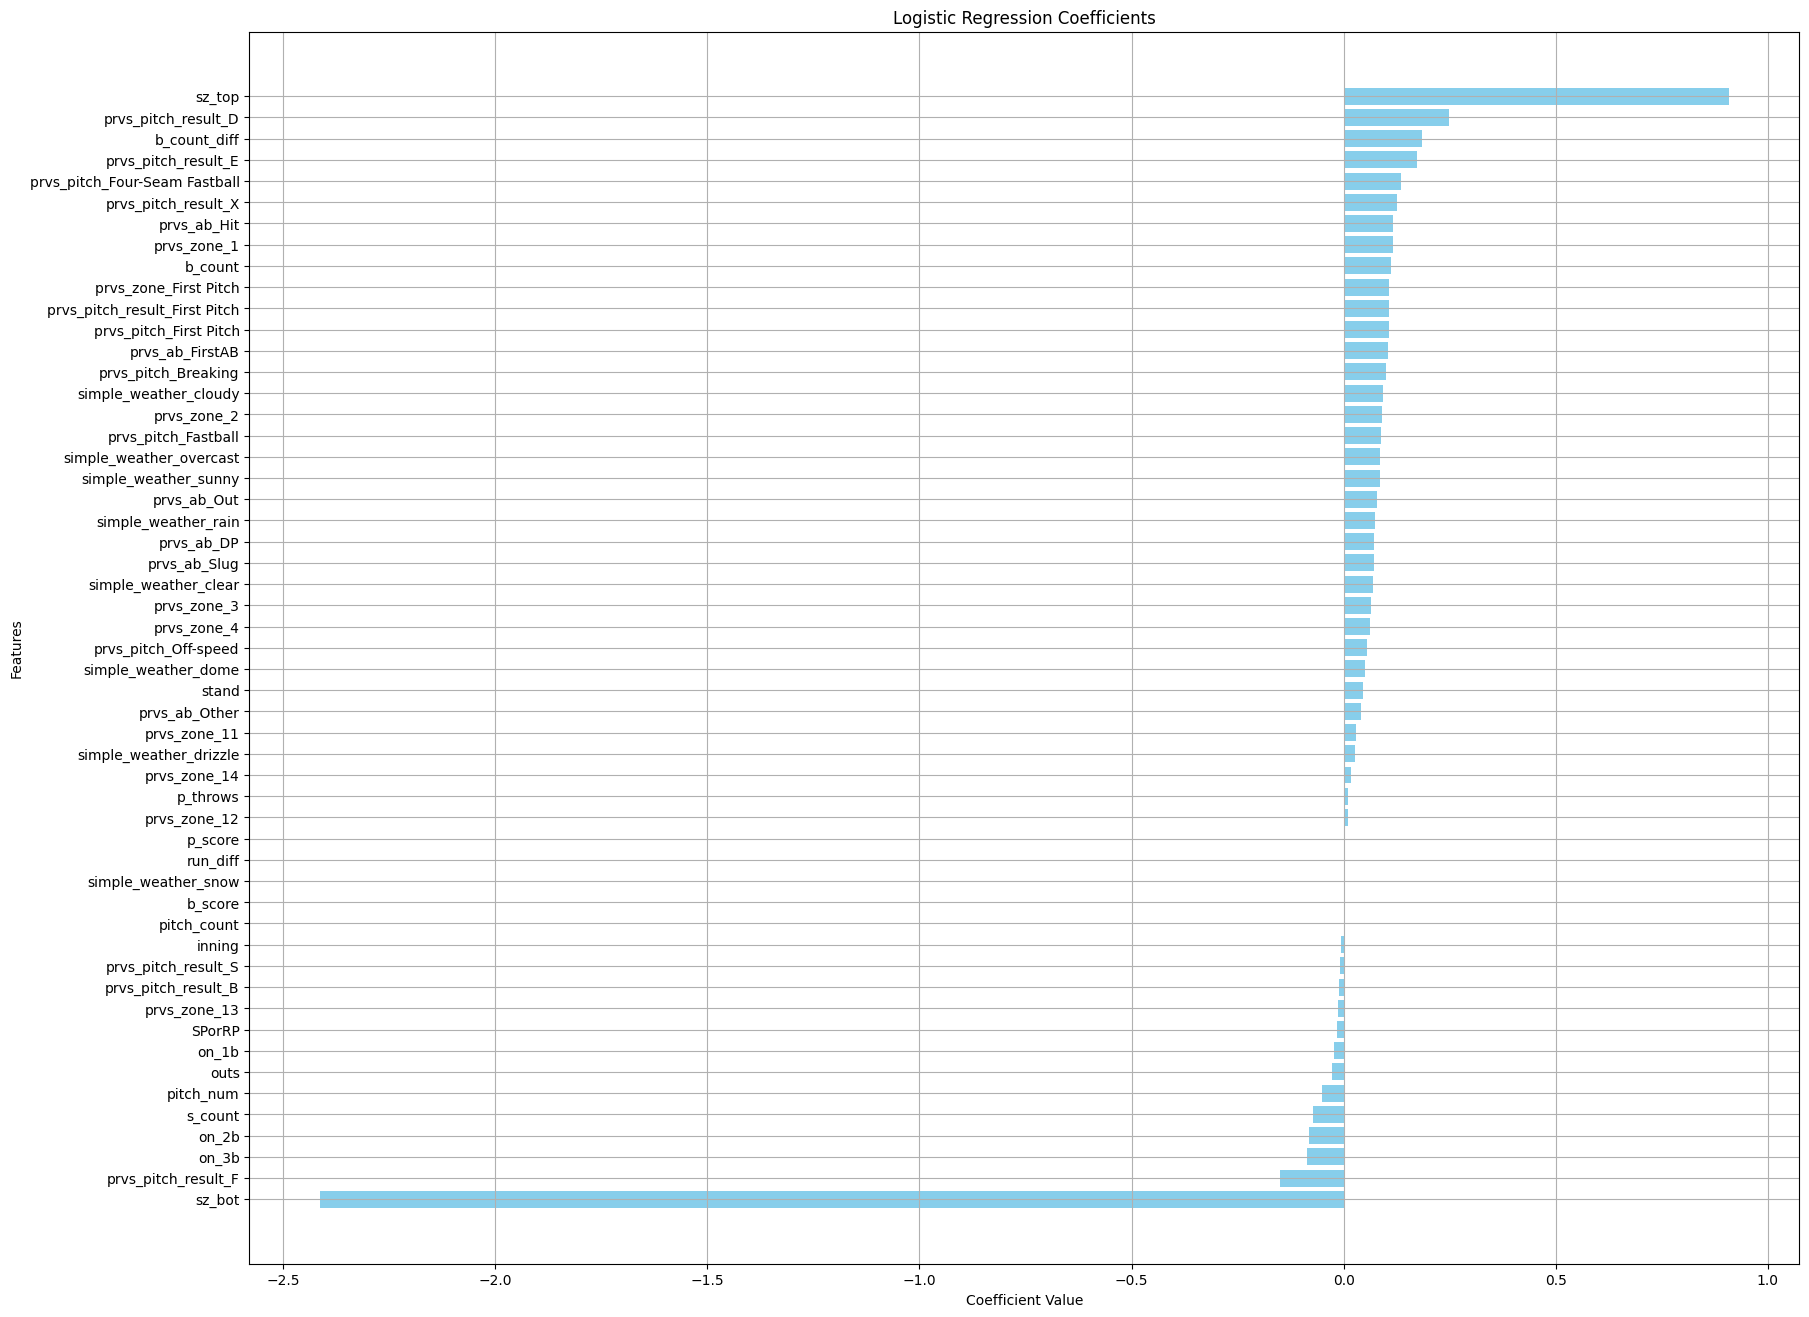

In [ ]:
coefficients = model.coef_[0]  # Single array since it's a binary classification

# Feature names (replace with your actual feature names if available)
feature_names = X.columns.tolist()

coefficients_sorted, feature_names_sorted = zip(*sorted(zip(coefficients, feature_names)))



plt.figure(figsize=(20, 16))
plt.barh(feature_names_sorted, coefficients_sorted, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.grid(True)

# Display the plot
plt.show()

The top 5 factors that leads to pitcher throwing a strike are:
- Higher strike zone boundary: Higher means more room to allow a strike.
- Previous Hit: When the previous at bat ends with a basehit, the pitcher is more likely to throw a strike for the first pitch at next at bat. Probably a way to regain confidence.
- Count disadvantage: When pitchers have more ball count than strike count, he's more likely to throw a strike to ease the disadvantage.
- Run Allowed: When the previous at bat ends with opposite team getting scores, the pitcher is more likely to throw a strike for the first pitch at next at bat. Probably a way to regain confidence.
- Fireball: When the previous pitch is a fastball, the pitcher is more likely to throw a strike on the next pitch. Probably to gain momentum.


The top 5 factors that leads to pitcher throwing a ball are:
- Lower strike zone boundary: The lower the low boundary is, the more likely pitcher will throw a ball. Can't explain why.
- Foul: When previous pitch result is a foul, pitcher will more likely to throw a ball. This is a strategy to disrupt the batter's momentum.
- 2B/3B Occupied: Runner on second/third base means a basehit will allow earned runs. Pitcher are more likely to throw bad pitch, induce batters to have swing and miss for a strike.
- strike count: As previously discussed, more strike counts means pitcher has more "ball" allowance. They will try to throw bad pitch, induce batters to have swing and miss for a strike.



### Clustering

We've discussed about the potential drawback of our baseline model. When working with the entire dataset, we treat all pitchers the same player. To address this issue, we will seperate them into different clusters based on some pitcher_specific features.

In [ ]:
#Do cluster in a seperate dataset
cluster_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

In [ ]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 69 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0.1                   int64  
 1   Unnamed: 0                     int64  
 2   px                             float64
 3   pz                             float64
 4   start_speed                    float64
 5   end_speed                      float64
 6   sz_bot                         float64
 7   sz_top                         float64
 8   zone                           float64
 9   type                           object 
 10  b_score                        float64
 11  ab_id                          float64
 12  b_count                        float64
 13  s_count                        float64
 14  outs                           float64
 15  pitch_num                      float64
 16  on_1b                          float64
 17  on_2b                          float64
 18  on

In this data, we only includs the feature that is under pitcher's knowledge and control. These includes
- Current pitch and previous pitch
- Current zone and previous zone
<ul>
<li> We are considering this as "intended" zone, which means we assume pitcher is always able to throw to the zone he wants. This is NOT always the case.
</ul>
- Start speed (by motion and grip)
- Throwing hand(L or R)
- Pitch-zone combination
- Staring pitcher or relief pitcher

In [ ]:
# We've created dummies for previous pitch and previous zone. I will use idmax to reverse it.
prvs_pitch_list = ['prvs_pitch_First Pitch', 'prvs_pitch_Four-Seam Fastball', 'prvs_pitch_Breaking','prvs_pitch_Off-speed','prvs_pitch_Fastball']
prvs_zone_list = ['prvs_zone_1',
                  'prvs_zone_2',
                  'prvs_zone_3',
                  'prvs_zone_4',
                  'prvs_zone_11',
                  'prvs_zone_12',
                  'prvs_zone_13',
                  'prvs_zone_14',
                  'prvs_zone_First Pitch'
                    ]
# Reverse dummy encoding for 'pitch_type'
cluster_df['prvs_pitch'] = cluster_df[prvs_pitch_list].idxmax(axis=1)

# Reverse dummy encoding for 'zone'
cluster_df['prvs_zone'] = cluster_df[prvs_zone_list].idxmax(axis=1)

# Remove prefixes to get back to the original categories
cluster_df['prvs_pitch'] = cluster_df['prvs_pitch'].str.replace('prvs_pitch_', '')
cluster_df['prvs_zone'] = cluster_df['prvs_zone'].str.replace('prvs_zone_', '')
cluster_df = cluster_df.drop(columns=['prvs_pitch_First Pitch', 'prvs_pitch_Four-Seam Fastball', 'prvs_pitch_Breaking','prvs_pitch_Off-speed','prvs_pitch_Fastball',
                                      'prvs_zone_1',
                                      'prvs_zone_2',
                                      'prvs_zone_3',
                                      'prvs_zone_4',
                                      'prvs_zone_11',
                                      'prvs_zone_12',
                                      'prvs_zone_13',
                                      'prvs_zone_14',
                                      'prvs_zone_First Pitch'])

In [ ]:
for_cluster_df = cluster_df[['pitcher_id','start_speed','zone','simple_pitch_type','p_throws','SPorRP','prvs_pitch','prvs_zone']]

In [ ]:
# Use new string columns to show the combination of previous + current zone/pitch type as well as current pitch + zone
for_cluster_df['zone_seq'] = for_cluster_df['prvs_zone'].astype(str) +'-'+ for_cluster_df['zone'].astype(str)
for_cluster_df['pitch_seq'] = for_cluster_df['prvs_pitch'] +'-'+ for_cluster_df['simple_pitch_type']
for_cluster_df['pitch_zone'] = for_cluster_df['simple_pitch_type'] + '-' + for_cluster_df['zone'].astype(str)

<ipython-input-9-bca07112d4b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_cluster_df['zone_seq'] = for_cluster_df['prvs_zone'].astype(str) +'-'+ for_cluster_df['zone'].astype(str)
<ipython-input-9-bca07112d4b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_cluster_df['pitch_seq'] = for_cluster_df['prvs_pitch'] +'-'+ for_cluster_df['simple_pitch_type']
<ipython-input-9-bca07112d4b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [ ]:
for_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pitcher_id         int64  
 1   start_speed        float64
 2   zone               float64
 3   simple_pitch_type  object 
 4   p_throws           float64
 5   SPorRP             int64  
 6   prvs_pitch         object 
 7   prvs_zone          object 
 8   zone_seq           object 
 9   pitch_seq          object 
 10  pitch_zone         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 277.9+ MB


In [ ]:
# Check how many of each types of pitch a pitcher has thrown
pitch_type_counts = for_cluster_df.groupby(['pitcher_id', 'simple_pitch_type']).size().unstack(fill_value=0)
pitch_type_counts.columns = [f'pitch_type_{col}' for col in pitch_type_counts.columns]

# Check how many of each zones a pitcher has thrown to
zone_counts = for_cluster_df.groupby(['pitcher_id', 'zone']).size().unstack(fill_value=0)
zone_counts.columns = [f'zone_{col}' for col in zone_counts.columns]

# Check how many of past-current zones combo a pitcher has thrown
zone_seq_counts = for_cluster_df.groupby(['pitcher_id', 'zone_seq']).size().unstack(fill_value=0)
zone_seq_counts.columns = [f'zone_seq_{col}' for col in zone_seq_counts.columns]

# Check how many of past-current pitch type combo a pitcher has thrown to
pitch_seq_counts = for_cluster_df.groupby(['pitcher_id', 'pitch_seq']).size().unstack(fill_value=0)
pitch_seq_counts.columns = [f'pitch_seq_{col}' for col in pitch_seq_counts.columns]

# Check how many of pitch type-zone combo a pitcher has thrown to
pitch_zone_counts = for_cluster_df.groupby(['pitcher_id', 'pitch_zone']).size().unstack(fill_value=0)
pitch_zone_counts.columns = [f'pitch_zone_{col}' for col in pitch_zone_counts.columns]

# just in case a pitcher is a switch pitcher(use both hands)
p_throws_counts = for_cluster_df.groupby(['pitcher_id', 'p_throws']).size().unstack(fill_value=0)
p_throws_counts.columns = [f'p_throws_{col}' for col in p_throws_counts.columns]

# just in case a pitcher is both relief and starting pitcher.
SPorRP_counts = for_cluster_df.groupby(['pitcher_id', 'SPorRP']).size().unstack(fill_value=0)
SPorRP_counts.columns = [f'SPorRP_{col}' for col in SPorRP_counts.columns]

grouped_df = pitch_type_counts.copy()  # Start with the first DataFrame
#Merge dataset together
for df in [zone_counts, zone_seq_counts, pitch_seq_counts,
            pitch_zone_counts, p_throws_counts, SPorRP_counts]:
    grouped_df = pd.merge(grouped_df, df, on='pitcher_id', how='outer')

# Fill NaN values with 0
grouped_df.fillna(0, inplace=True)

print(grouped_df)

            pitch_type_Breaking  pitch_type_Fastball  \
pitcher_id                                             
112526                      718                 5832   
115629                       91                    8   
136600                       48                   53   
150116                      218                  184   
150274                       52                   15   
...                         ...                  ...   
673258                       36                    0   
673633                       14                    1   
675916                       41                    0   
676606                      331                    0   
677976                      119                  156   

            pitch_type_Four-Seam Fastball  pitch_type_Off-speed  zone_1.0  \
pitcher_id                                                                  
112526                               2201                   737       962   
115629                                39

In [ ]:
# Calculate the counts of each p_throws value for each pitcher
p_throws_counts = for_cluster_df.groupby(['pitcher_id', 'p_throws']).size().unstack(fill_value=0)
p_throws_counts.columns = [f'p_throws_{col}' for col in p_throws_counts.columns]

# Determine the dominant throwing hand for each pitcher
grouped_df['p_throws'] = p_throws_counts.apply(lambda row: 0 if row['p_throws_0.0'] > row['p_throws_1.0'] else 1, axis=1)

# Drop the minor p_throws columns
grouped_df = grouped_df.drop(columns=['p_throws_0.0', 'p_throws_1.0'])

# Repeat the same process for 'SPorRP'
SPorRP_counts = for_cluster_df.groupby(['pitcher_id', 'SPorRP']).size().unstack(fill_value=0)
SPorRP_counts.columns = [f'SPorRP_{col}' for col in SPorRP_counts.columns]

grouped_df['SPorRP'] = SPorRP_counts.apply(lambda row: 0 if row['SPorRP_0'] > row['SPorRP_1'] else 1, axis=1)
grouped_df = grouped_df.drop(columns=['SPorRP_0', 'SPorRP_1'])

In [ ]:
# Group by pitcher_id and pitch_type, then calculate the average pitch_speed of each pitch type
average_speed_df = for_cluster_df.groupby(['pitcher_id', 'simple_pitch_type'])['start_speed'].mean().unstack()

# Rename columns to include pitch_type
average_speed_df.columns = [f'avg_speed_{col}' for col in average_speed_df.columns]

# Reset index to include pitcher_id as a column
average_speed_df = average_speed_df.reset_index()

In [ ]:
grouped_df = pd.merge(grouped_df, average_speed_df, on='pitcher_id', how='outer')

In [ ]:
# Fill NaN values with 0
grouped_df.fillna(0, inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler = StandardScaler()
scaled_df = scaler.fit_transform(grouped_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

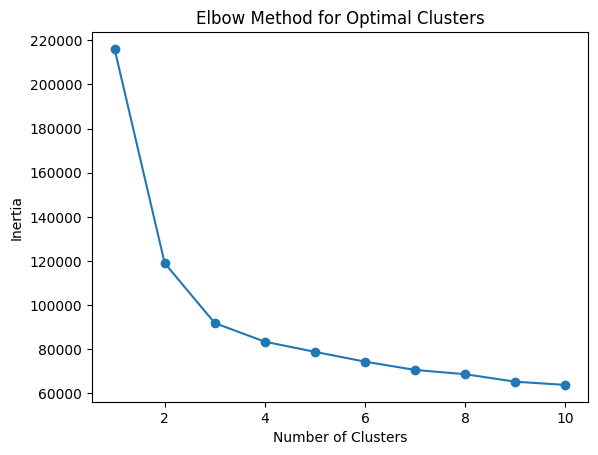

In [ ]:
# Use KNN mean to cluster 1511 pitchers
import matplotlib.pyplot as plt


inertia = []
cluster_range = range(1, 11)  # Testing 1 to 10 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

Based on the elbow method, we will split the pitchers to 3 clusters.

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled_df)

# Add cluster labels to the final DataFrame
grouped_df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
grouped_df['cluster'].value_counts()

,count
cluster,
0,1007
2,383
1,121


The cluster method classify 1000 pitchers as the same kind. This is unexpected, as we will have a major group that accounts for more than 90% of the pitcher population. Likely the clustering won't help too much with accuracy.

### Model Evaluation

Lastly, we need to find an approporate evaluation method with domain knowledge.

We will look at accuracy and classification report of traditional machine learning method like logistic classifier and decision tree classifier.

#### Ball or Strike

This target feature is binary. We will primarily look at the accuracy and precision score for both classes to make sure users can rely on the prediction.

In addition, we would prefer a balanced performance between precision and recall, and the recall score for minority class should not be low. If the model is not capturing enough true positives for minority class, the overall prediction class will be imbalanced.

#### Pitch Type

We have simplied the pitch type to four categories. In real time games, the only way to communicate result is do hand signaling, which means the info must be precise.

Same as ball/strike, high precision score has the highest priority. Batter needs to trust the outcome. On the other hand, off-speed as the minority class will need more attention. While we need to keep a balance between precision and recall, the model must identify enough true positives of off-speed.


## Model Fine-tuning

### Prepare Data

In [ ]:
full_pitcher_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

In [ ]:
full_pitcher_df = full_pitcher_df.merge(grouped_df[['pitcher_id', 'cluster']], on='pitcher_id', how='left')

In [ ]:
full_pitcher_df = full_pitcher_df.drop(columns = ['start_speed','end_speed','px','o','pz','Unnamed: 0','g_id','top','simple_pitch_type','Unnamed: 0.1','type','simple_type'])

In [ ]:
full_pitcher_df['zone'].value_counts()

,count
zone,
14.00,704109
13.00,549531
11.00,420040
4.00,381079
3.00,362343
12.00,312411
1.00,298279
2.00,283767


In [ ]:
#encoding zone columns to make it binary for ball/strike prediction
dictionary_zone_01 = {1:1,
                      2:1,
                      3:1,
                      4:1,
                      11:0,
                      12:0,
                      13:0,
                      14:0}

In [ ]:
new_class = [dictionary_zone_01[class_name] for class_name in full_pitcher_df['zone']]
full_pitcher_df['zone'] = new_class

### Test of Independence

In [ ]:
pitch_type_chi = full_pitcher_df['simple_pitch_type_enc'].astype(str)
zone_chi = full_pitcher_df['zone'].astype(str)

import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a DataFrame `df` with two categorical columns 'col1' and 'col2'
contingency_table = pd.crosstab(pitch_type_chi, zone_chi)
print(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)
if p < 0.05:
    print("There is a significant association between the two variables.")
else:
    print("There is no significant association between the two variables.")

zone                        0       1
simple_pitch_type_enc                
1                      658027  528826
2                      569917  329167
3                      484120  340653
4                      274027  126822
There is a significant association between the two variables.


As the result suggests, there's still a significant relationship between the strike/ball placement and pitch type. We will produce seperate models for each target variables first, and use approaches to attempt catching this relationship.

### Zone Prediction

#### Fine-tuning on the Zone Prediction Model with Logistic Regression Approach

##### Remove colineared Features

 As we compare the model, the Softmax logistic regression model has a higher accuracy, so we will start from it.

 We will remove colineard columns and use grid search to optimize the hyperparameter for this.

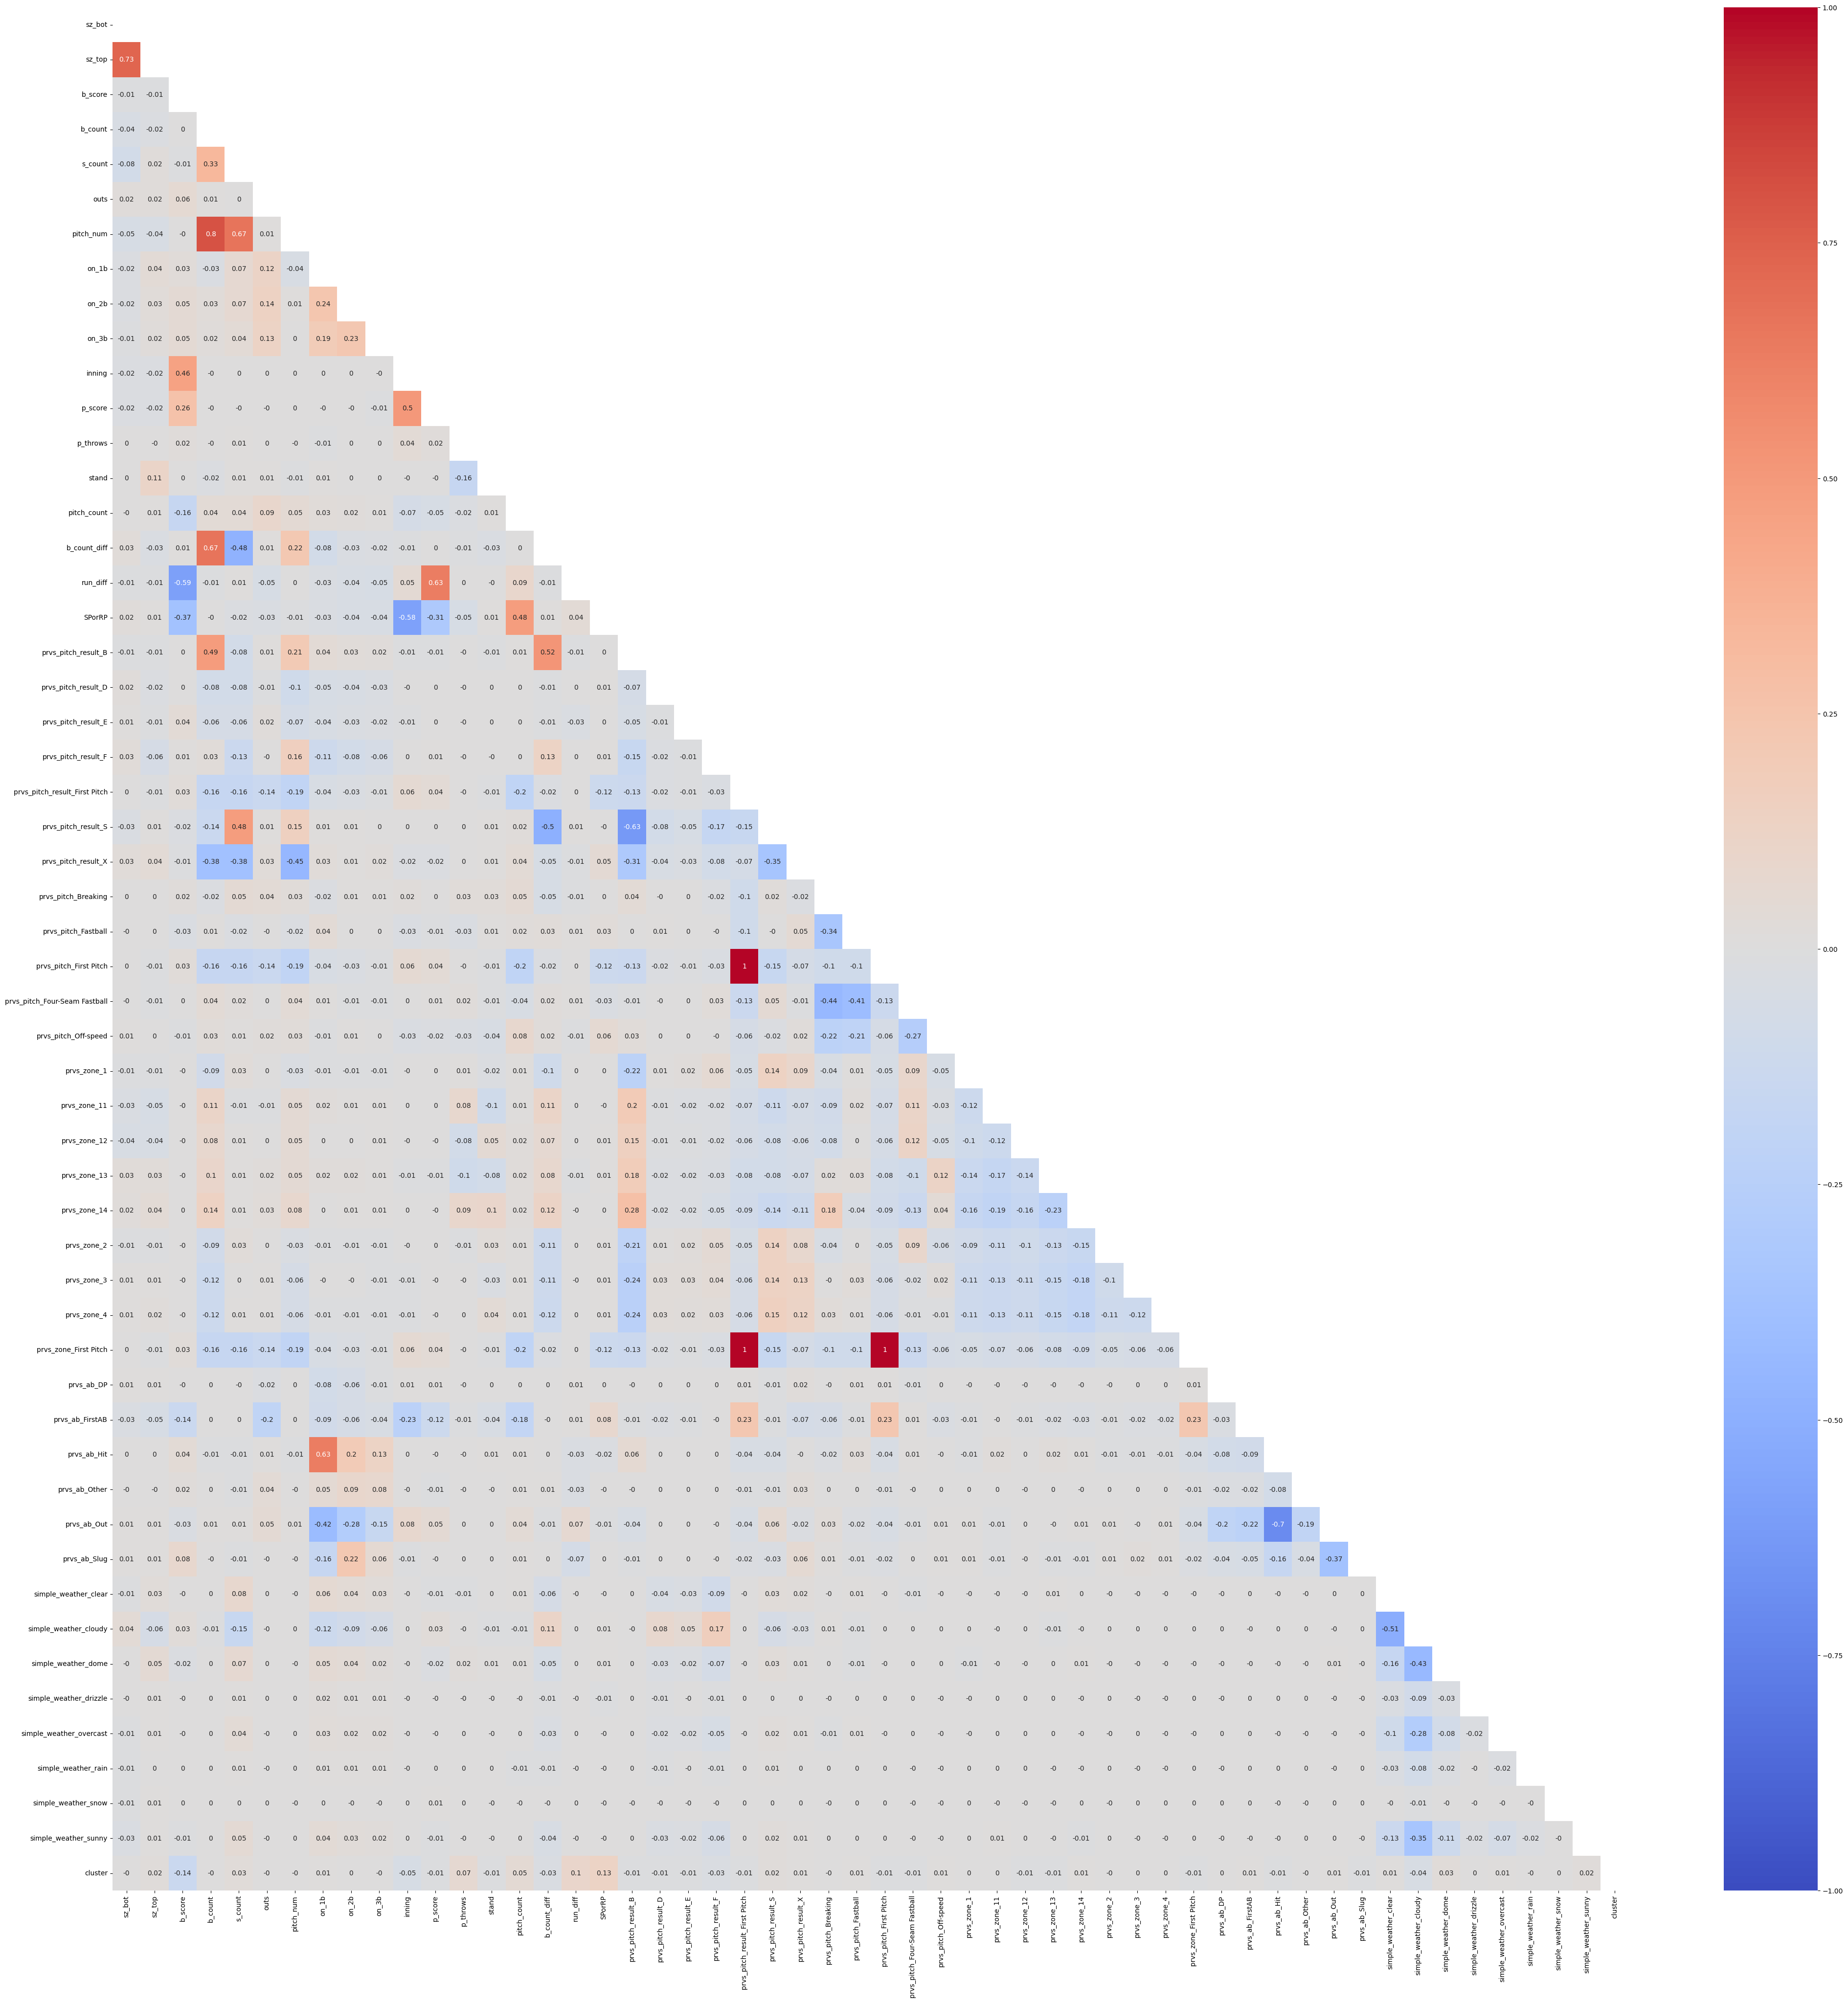

In [ ]:
corr_df = X.corr()

mask = np.triu(corr_df)

plt.figure(figsize=(50,50))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

In [ ]:
# We are removing some columns to make sure all correlation between features are below 0.5.
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                    'sz_bot',
                                    'b_count','s_count',
                                    'prvs_pitch_result_B',
                                    'prvs_ab_Out',
                                    'simple_weather_cloudy',
                                    'on_1b',
                                    'prvs_zone_First Pitch',
                                    'prvs_pitch_result_First Pitch',
                                    'p_score','b_score'])
y = full_pitcher_df['zone']
X.shape

(3311559, 43)

##### Reinstate Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=200, class_weight = 'balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

[1 1 1 ... 0 1 0]
Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.66      0.52      0.58    397350
           1       0.45      0.59      0.51    264962

    accuracy                           0.55    662312
   macro avg       0.55      0.55      0.54    662312
weighted avg       0.57      0.55      0.55    662312



##### Random Search#1

In [ ]:
from sklearn.model_selection import train_test_split
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                    'sz_bot',
                                    'b_count','s_count',
                                    'prvs_pitch_result_B',
                                    'prvs_ab_Out',
                                    'simple_weather_cloudy',
                                    'on_1b',
                                    'prvs_zone_First Pitch',
                                    'prvs_pitch_result_First Pitch',
                                    'p_score','b_score','cluster'])
y = full_pitcher_df['zone']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Scale the features
    ('pca', PCA()),                 # Step 2: Apply PCA
    ('estimator', LogisticRegression())  # Step 3: Placeholder for the model (LogisticRegression initially)
])

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Softmax Logistic Regression
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(1, 43, 1),  # PCA components
        'estimator': [LogisticRegression(solver='lbfgs',class_weight = 'balanced')],
        'estimator__C': np.arange(0.001, 10.001, 0.001)  # Regularization strength
    },
    # Parameters for Decision Tree
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(1, 43, 1),  # PCA components
        'estimator': [DecisionTreeClassifier()],
        'estimator__max_depth': np.arange(5, 25, 1),  # Max depth of the tree
        'estimator__min_samples_split': np.arange(5, 11, 1)  # Minimum samples required to split
    }
]

In [ ]:
# Create the GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_grid,n_iter=10, cv=5, scoring='f1')

# Fit GridSearchCV to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('estimator',
                                              LogisticRegression())]),
                   param_distributions=[{'estimator': [LogisticRegression(class_weight='balanced')],
                                         'estimator__C': array([1.000e-03, 2.000e-03, 3.000e-03, ..., 9.998e+00, 9.999e+00,
       1.000e+01]),
                                         'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12...
                                        {'estimator': [DecisionTreeClassifier()],
                                         'estimator__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24]),
                                         'estimator__min_samples_split': array([ 5,  6,  7,  8,  9, 10]),
                                         'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42]),
                                         'scaler': [StandardScaler(), None]}],
                   scoring='f1')

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {random_search.best_score_:.2f}")

Best parameters: {'scaler': None, 'pca__n_components': 18, 'estimator__C': 6.314, 'estimator': LogisticRegression(class_weight='balanced')}
Best cross-validated accuracy: 0.51


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Test set accuracy: 0.54
              precision    recall  f1-score   support

           0       0.65      0.50      0.57    397350
           1       0.45      0.60      0.51    264962

    accuracy                           0.54    662312
   macro avg       0.55      0.55      0.54    662312
weighted avg       0.57      0.54      0.55    662312



##### Random Search#2

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Softmax Logistic Regression
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(15, 25, 1),  # PCA components
        'estimator': [LogisticRegression(solver='lbfgs', class_weight = 'balanced')],
        'estimator__C': np.arange(3, 6, 0.1)  # Regularization strength
    },
    # Parameters for Decision Tree
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(15, 25, 1),  # PCA components
        'estimator': [DecisionTreeClassifier()],
        'estimator__max_depth': np.arange(5, 20, 1),  # Max depth of the tree
        'estimator__min_samples_split': np.arange(5, 11, 1)  # Minimum samples required to split
    }
]

In [ ]:
# Create the GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_grid,n_iter=10, cv=5, scoring='f1')

# Fit GridSearchCV to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('estimator',
                                              LogisticRegression())]),
                   param_distributions=[{'estimator': [LogisticRegression(class_weight='balanced')],
                                         'estimator__C': array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
       4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5,
       5.6, 5.7, 5.8, 5.9]),
                                         'pca__n_components': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                                         'scaler': [StandardScaler(), None]},
                                        {'estimator': [DecisionTreeClassifier()],
                                         'estimator__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                         'estimator__min_samples_split': array([ 5,  6,  7,  8,  9, 10]),
                                         'pca__n_components': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                                         'scaler': [StandardScaler(), None]}],
                   scoring='f1')

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {random_search.best_score_:.2f}")

Best parameters: {'scaler': None, 'pca__n_components': 20, 'estimator__C': 4.200000000000001, 'estimator': LogisticRegression(class_weight='balanced')}
Best cross-validated accuracy: 0.51


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Test set accuracy: 0.54
              precision    recall  f1-score   support

           0       0.65      0.50      0.57    397350
           1       0.45      0.60      0.51    264962

    accuracy                           0.54    662312
   macro avg       0.55      0.55      0.54    662312
weighted avg       0.57      0.54      0.55    662312



After two random search, we are not noticing many changes on all the scores. We will end up with a grid search and interpret the result.

##### Grid Search

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Softmax Logistic Regression
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': [20,40],  # PCA components
        'estimator': [LogisticRegression(solver='lbfgs',class_weight = 'balanced')],
        'estimator__C': [1,2,4]  # Regularization strength
    }
]

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('estimator', LogisticRegression())]),
             param_grid=[{'estimator': [LogisticRegression(class_weight='balanced')],
                          'estimator__C': [1, 2, 4],
                          'pca__n_components': [20, 40],
                          'scaler': [StandardScaler(), None]}],
             scoring='f1')

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {grid_search.best_score_:.2f}")

Best parameters: {'estimator': LogisticRegression(class_weight='balanced'), 'estimator__C': 4, 'pca__n_components': 20, 'scaler': None}
Best cross-validated accuracy: 0.51


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Test set accuracy: 0.54
              precision    recall  f1-score   support

           0       0.65      0.50      0.57    397350
           1       0.45      0.60      0.51    264962

    accuracy                           0.54    662312
   macro avg       0.55      0.55      0.54    662312
weighted avg       0.57      0.54      0.55    662312



We will check the coefficients again to see if there's new factors.

In [ ]:
lr_pip_coe = Pipeline([
    ('pca', PCA(n_components=20)),  # PCA with 20 components
    ('estimator', LogisticRegression(C=4, class_weight='balanced'))  # Logistic Regression with specified C and class_weight
])

lr_pip_coe.fit(X_train, y_train)


Pipeline(steps=[('pca', PCA(n_components=20)),
                ('estimator',
                 LogisticRegression(C=4, class_weight='balanced'))])

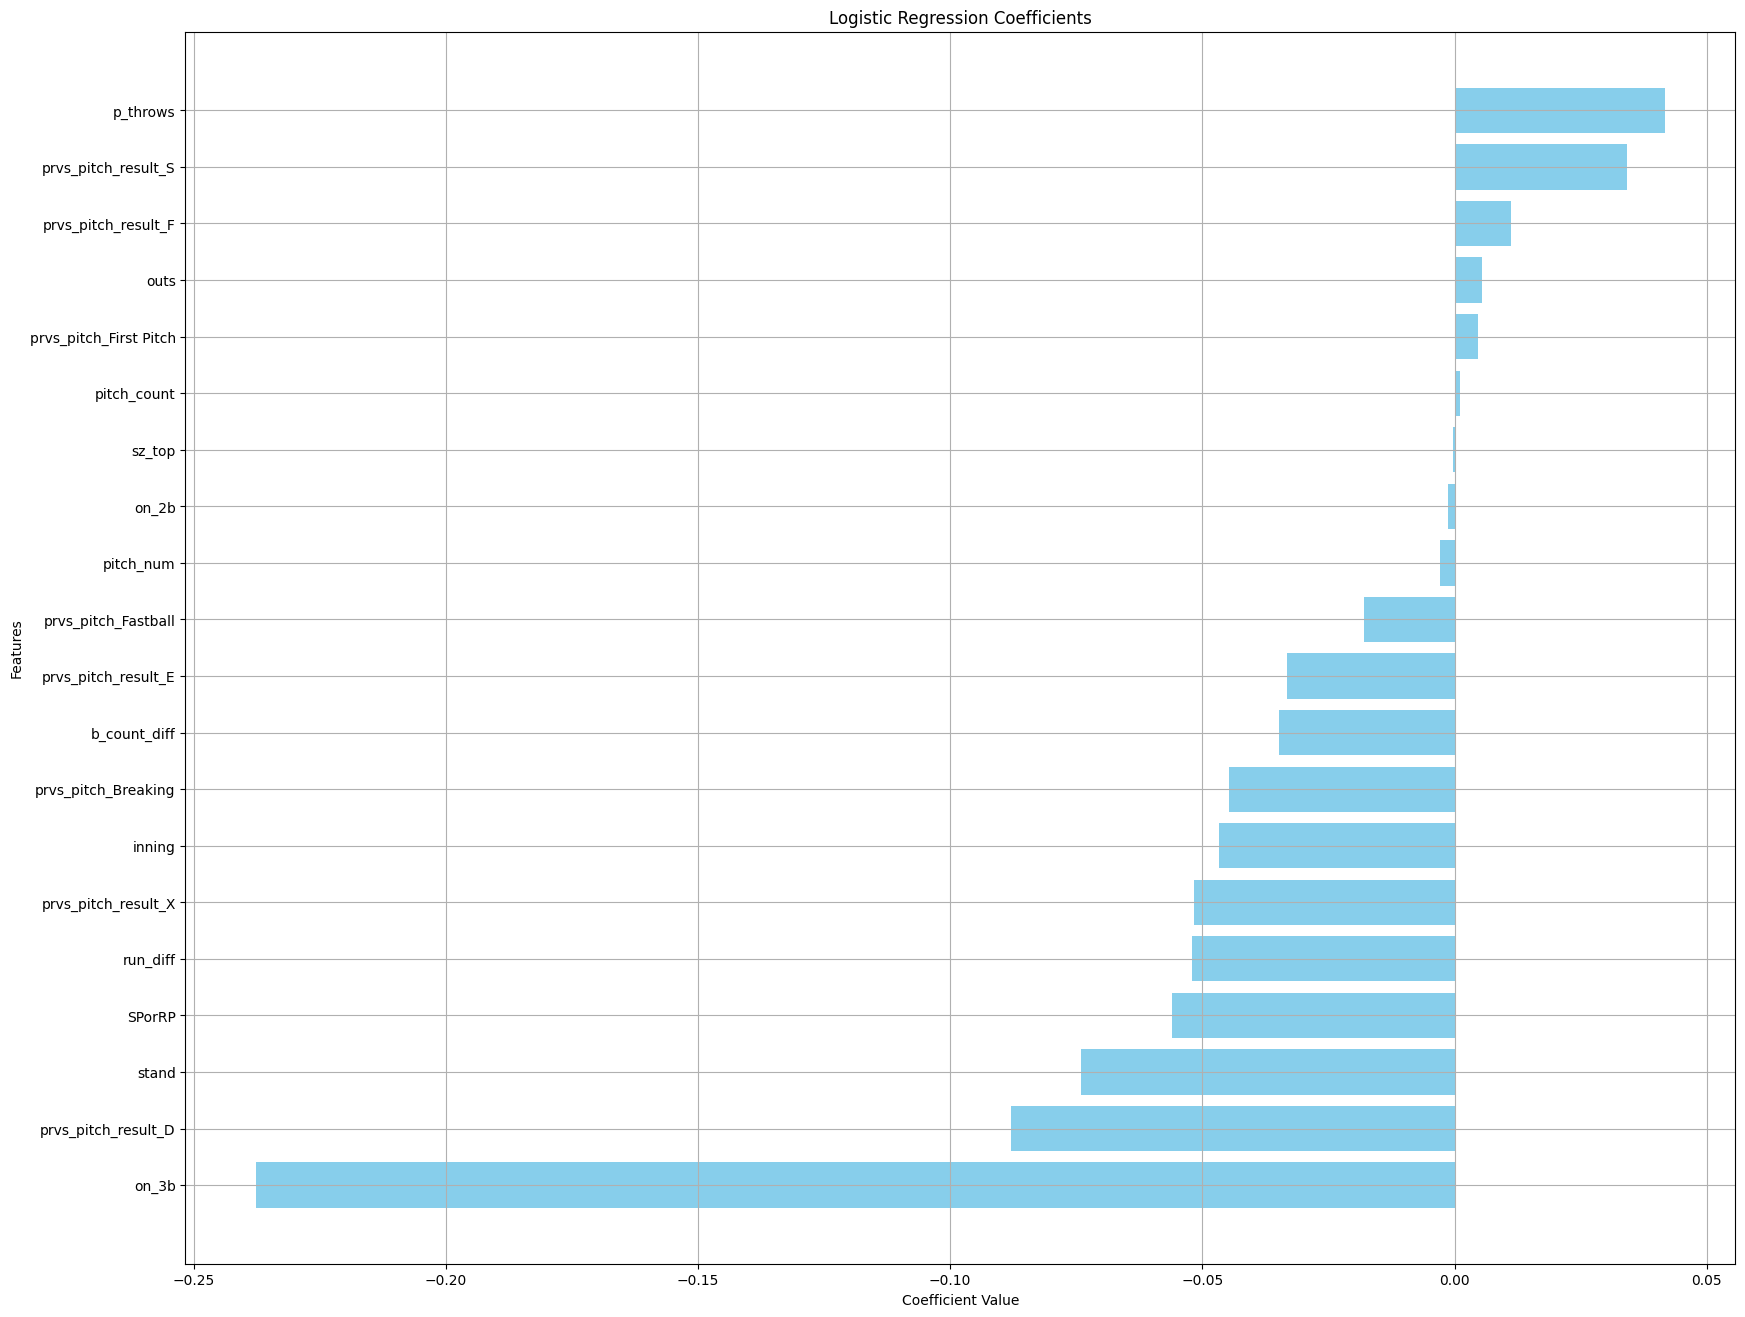

In [ ]:
coefficients = lr_pip_coe[0]  # Single array since it's a binary classification

# Feature names (replace with your actual feature names if available)
feature_names = X.columns.tolist()

# Access the LogisticRegression estimator within the pipeline
lr_estimator = lr_pip_coe.named_steps['estimator']

# Get coefficients from the fitted logistic regression model
coefficients = lr_estimator.coef_[0]  # Single array since it's a binary classification

# Feature names (replace with your actual feature names if available)
feature_names = X.columns.tolist()

# Sort coefficients and feature names together
coefficients_sorted, feature_names_sorted = zip(*sorted(zip(coefficients, feature_names)))

plt.figure(figsize=(20, 16))
plt.barh(feature_names_sorted, coefficients_sorted, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.grid(True)

# Display the plot
plt.show()

After principle component analysis, several featuresa are excluded. Note that there are more negative correlationship left. This aligns with the ball-strike ratio of 3:2 in our dataset.

Top 3 factors of throwing a strike:
- Right-handed pitcher are more likely to throw a strike.
- If previous pitch results in a swing strike, pitcher are more likely to throw a strike in the next pitch.
- If previous pitch results in a foul, pitcher are more likely to throw a strike in the next pitch. This directly conflicts with the observation from our baseline model.






Top 3 factors of throwing a strike:
- Pitcher tends to throw balls when there's runner on 3rd bases. This is the same as we observed earlier.
- Pitcher tends to throw balls when previous hitter made a basehit on the last pitch. This directly conflicts with the observation from our baseline model.
- Pitcher tends to throw ball to right-handed pitcher. This is more like a strategy to pitch to the inside area.



From our fine-tuned logistic regression model, we found something that contridicts with our previous finding.

#### Fine-tuning on the Zone Prediction Model with Decision Tree/Xgboost Approach

In our previous exploration, we noticed that decision tree model has a similar accuracy with logistic regression. We will train a decision tree model as well for comparison or ensembling.

##### Xgboost model

We really need to IMPROVE THE ACCURACY. Let's try xgboost model. This is already an ensembled learning model, so I will simply apply a SMOTE to help with potential class imbalance problem.

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
#Use Synthetic Minority Oversampling Technique to create more rows for minority class.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
import xgboost as xgb
# XGBoost parameters
model = xgb.XGBClassifier(
              objective='binary:logistic',
              max_depth=10,
              learning_rate=0.01,
              n_estimators=500,
              eval_metric='logloss'
)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(report)

Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.62      0.82      0.71    397350
           1       0.49      0.26      0.34    264962

    accuracy                           0.60    662312
   macro avg       0.56      0.54      0.52    662312
weighted avg       0.57      0.60      0.56    662312



The accuracy is higher now, but the f1 score on class 1 (strike) is lower. It might have something to do with the SMOTE method applied as more class 1 has been generated.

We would prefer a higher score on strike classes. Although four balls for a walk is nice, hitter wants to find strike and hit. And domain knowledge tells us the ball-strike ratio won't be 3:2 in real games. **Logistic regression model is better than xgboost with a more balanced accuracy and better prediction on strike class.**

Nevertheless, looks like decision tree classifier might increase accuracy. We will try random forest model.

##### Random Forest Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42,class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.54    397350
           1       0.45      0.67      0.54    264962

    accuracy                           0.54    662312
   macro avg       0.56      0.56      0.54    662312
weighted avg       0.58      0.54      0.54    662312



The accuracy remains the same, but we can notice a strong difference: recall on strike class has increased by 7%. Recall score on ball class decreased by 4%. In other words, the random forest model captures 7% more of the strikes, but 4% less on the balls.

Both models performed similarly with different emphasis. We will ensemble them together.



#### Ensemble Model for Zone Prediction Only

In [ ]:
from sklearn.ensemble import StackingClassifier
# Train base models
rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42,class_weight='balanced')
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=20)),  # Adjust n_components based on your data
    ('lr', LogisticRegression(solver='lbfgs',class_weight = 'balanced',C=4)),
])

rf.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

# Create a stacking classifier
estimators = [('rf', rf), ('lr', lr_pipeline)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced'))

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.54    397350
           1       0.45      0.66      0.54    264962

    accuracy                           0.54    662312
   macro avg       0.56      0.56      0.54    662312
weighted avg       0.58      0.54      0.54    662312



In [ ]:
import joblib
joblib.dump(stacking_clf, 'model_cluster_zone_general.pkl')

['model_cluster_zone_general.pkl']

### Pitch Prediction

#### Fine-tuning on the Pitch Prediction Model

We will start with the softmax model as it's our baseline model. We will still keep decisiontree classifier in the grid search in case it outperformed.

##### Baseline Model

In [ ]:
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                    'sz_bot',
                                    'b_count','s_count',
                                    'prvs_pitch_result_B',
                                    'prvs_ab_Out',
                                    'simple_weather_cloudy',
                                    'on_1b',
                                    'prvs_zone_First Pitch',
                                    'prvs_pitch_result_First Pitch',
                                    'p_score','b_score','cluster'])

y = full_pitcher_df['simple_pitch_type_enc']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=200,class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

[1 2 3 ... 2 2 2]
Accuracy: 0.42
              precision    recall  f1-score   support

           1       0.50      0.46      0.48    237612
           2       0.38      0.36      0.37    179582
           3       0.48      0.47      0.47    164654
           4       0.22      0.30      0.25     80464

    accuracy                           0.42    662312
   macro avg       0.39      0.40      0.39    662312
weighted avg       0.43      0.42      0.42    662312



##### Random Search#1

In [ ]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Scale the features
    ('pca', PCA()),                 # Step 2: Apply PCA
    ('estimator', LogisticRegression())  # Step 3: Placeholder for the model (LogisticRegression initially)
])

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Softmax Logistic Regression
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(1, 43, 1),  # PCA components
        'estimator': [LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced')],
        'estimator__C': np.arange(0.1, 10.2, 0.1)  # Regularization strength
    },
    # Parameters for Decision Tree
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(1, 43, 1),  # PCA components
        'estimator': [DecisionTreeClassifier(class_weight = 'balanced')],
        'estimator__max_depth': np.arange(5, 25, 1),  # Max depth of the tree
        'estimator__min_samples_split': np.arange(5, 11, 1)  # Minimum samples required to split
    }
]

In [ ]:
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, average='weighted')
# Create the GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer)

# Fit GridSearchCV to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('estimator',
                                              LogisticRegression())]),
                   param_distributions=[{'estimator': [LogisticRegression(class_weight='balanced',
                                                                          multi_class='multinomial')],
                                         'estimator__C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4...
                                         'estimator__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24]),
                                         'estimator__min_samples_split': array([ 5,  6,  7,  8,  9, 10]),
                                         'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42]),
                                         'scaler': [StandardScaler(), None]}],
                   scoring=make_scorer(f1_score, average=weighted))

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {random_search.best_score_:.2f}")

Best parameters: {'scaler': None, 'pca__n_components': 37, 'estimator__C': 6.0, 'estimator': LogisticRegression(class_weight='balanced', multi_class='multinomial')}
Best cross-validated accuracy: 0.42


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

Test set accuracy: 0.42


##### Random Search#2

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Scale the features
    ('pca', PCA()),                 # Step 2: Apply PCA
    ('estimator', LogisticRegression())  # Step 3: Placeholder for the model (LogisticRegression initially)
])

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Softmax Logistic Regression
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(24, 43, 1),  # PCA components
        'estimator': [LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced')],
        'estimator__C': np.arange(2.0, 10.2, 0.1)  # Regularization strength
    },
    # Parameters for Decision Tree
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': np.arange(24, 43, 1),  # PCA components
        'estimator': [DecisionTreeClassifier(class_weight = 'balanced')],
        'estimator__max_depth': np.arange(5, 25, 1),  # Max depth of the tree
        'estimator__min_samples_split': np.arange(5, 11, 1)  # Minimum samples required to split
    }
]

In [ ]:
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, average='weighted')
# Create the GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer)

# Fit GridSearchCV to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('estimator',
                                              LogisticRegression())]),
                   param_distributions=[{'estimator': [LogisticRegression(class_weight='balanced',
                                                                          multi_class='multinomial')],
                                         'estimator__C': array([ 2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,...
                                        {'estimator': [DecisionTreeClassifier(class_weight='balanced')],
                                         'estimator__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24]),
                                         'estimator__min_samples_split': array([ 5,  6,  7,  8,  9, 10]),
                                         'pca__n_components': array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42]),
                                         'scaler': [StandardScaler(), None]}],
                   scoring=make_scorer(f1_score, average=weighted))

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {random_search.best_score_:.2f}")

Best parameters: {'scaler': None, 'pca__n_components': 38, 'estimator__C': 6.300000000000004, 'estimator': LogisticRegression(class_weight='balanced', multi_class='multinomial')}
Best cross-validated accuracy: 0.42


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

Test set accuracy: 0.42


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.47      0.48    237612
           2       0.38      0.36      0.37    179582
           3       0.48      0.47      0.47    164654
           4       0.22      0.29      0.25     80464

    accuracy                           0.42    662312
   macro avg       0.39      0.40      0.39    662312
weighted avg       0.43      0.42      0.42    662312



##### Grid Search

In [ ]:
# Define the parameter grid
param_grid = [
    # Parameters for Decision Tree
    {   'scaler': [StandardScaler(), None],
        'pca__n_components': [35,37,38],  # PCA components
        'estimator': [LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced')],
        'estimator__C': [5,6,7]
    }
]

In [ ]:
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, average='weighted')
# Create the GridSearchCV object
grid_search_pitch = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer)

# Fit GridSearchCV to the training data
grid_search_pitch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('estimator', LogisticRegression())]),
             param_grid=[{'estimator': [LogisticRegression(class_weight='balanced',
                                                           multi_class='multinomial')],
                          'estimator__C': [5, 6, 7],
                          'pca__n_components': [35, 37, 38],
                          'scaler': [StandardScaler(), None]}],
             scoring=make_scorer(f1_score, average=weighted))

In [ ]:
# Print the best parameters found by GridSearchCV
print(f"Best parameters: {grid_search_pitch.best_params_}")

# Print the best score achieved during the grid search
print(f"Best cross-validated accuracy: {grid_search_pitch.best_score_:.2f}")

Best parameters: {'estimator': LogisticRegression(class_weight='balanced', multi_class='multinomial'), 'estimator__C': 7, 'pca__n_components': 37, 'scaler': None}
Best cross-validated accuracy: 0.42


In [ ]:
# Make predictions on the test set using the best estimator
y_pred = grid_search_pitch.best_estimator_.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

Test set accuracy: 0.42


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.46      0.48    237612
           2       0.38      0.37      0.37    179582
           3       0.48      0.46      0.47    164654
           4       0.22      0.29      0.25     80464

    accuracy                           0.42    662312
   macro avg       0.39      0.40      0.39    662312
weighted avg       0.43      0.42      0.42    662312



After two random search, we will use logistic regression for the final grid search to save time. We can notice a relatively good f1 score for four-seam fastballs and breaking ball. The performance of predicting other fastball is not as good, and prediction on off-speed is not reliable. In conclusion, the model have moderately prediction power on four-seam fastball, and breaking.

The major issue on the off-speed pitch which is the minority class. We will train the model with SMOTE-processed data again.

##### Reinstate Model with SMOTE

In [ ]:
X = full_pitcher_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                    'sz_bot',
                                    'b_count','s_count',
                                    'prvs_pitch_result_B',
                                    'prvs_ab_Out',
                                    'simple_weather_cloudy',
                                    'on_1b',
                                    'prvs_zone_First Pitch',
                                    'prvs_pitch_result_First Pitch',
                                    'p_score','b_score','cluster'])

y = full_pitcher_df['simple_pitch_type_enc']



In [ ]:
pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
SMOTE_pitch_pipeline = Pipeline([
    ('pca', PCA(n_components=37)),  # PCA with 37 components
    ('estimator', LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced'))
])

# Fit the model on the resampled training data
SMOTE_pitch_pipeline.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the test set
y_pred = SMOTE_pitch_pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.46      0.48    237612
           2       0.38      0.37      0.37    179582
           3       0.48      0.46      0.47    164654
           4       0.22      0.30      0.26     80464

    accuracy                           0.42    662312
   macro avg       0.39      0.40      0.39    662312
weighted avg       0.43      0.42      0.42    662312



When training with synthetic data, there's no difference with the previous model. Probably this is the best this model can do.

#### Pitch Prediction Model with Random Forest

Another way is improve to use a more powerful random forest method.

In [ ]:
# Initialize the Random Forest classifier
pipeline = Pipeline([
    ('pca', PCA(n_components=37)),  # from grid search result
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42,max_depth=13,min_samples_split = 8)) # from grid search result
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4527564048363913
Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.73      0.56    237612
           2       0.42      0.25      0.31    179582
           3       0.48      0.47      0.48    164654
           4       0.40      0.07      0.11     80464

    accuracy                           0.45    662312
   macro avg       0.44      0.38      0.36    662312
weighted avg       0.44      0.45      0.42    662312



The random forest method increased the accuracy by 3%, and recall score on four-seam increases. However, we can notice a low precision on four-seams and a recall of 0.07 on off-speed.

The model is able to identify 20% more true positives of four-seam, but 5% less prediction is correct. On the other hand, the model nearly can't identify true positives of off-speed pitch now.

#### Save model

In [ ]:
model_pitch_type_general = Pipeline([
    ('pca', PCA(n_components=37)),  # Adjust n_components based on your data
    ('lr', LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced'))
])

# Train the model
model_pitch_type_general.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=37)),
                ('lr',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial'))])

In [ ]:
import joblib
joblib.dump(model_pitch_type_general, 'model_pitch_type_general.pkl')

['model_pitch_type_general.pkl']

## Seperate Prediction Models for each Cluster

In the previous review section, we've broken down all the pitchers to three clusters based on their pitch mix, speed and zone/strike/ball placement&combination.

Before we post models to production, we will
1. Partition the data by each cluster.
2. Train stacked zone prediction model and random forest pitch type prediction model as well RNN model designed for multiple output with partitioned data.
3. Compare the acccuracy with fine-tuned model fit with the entire dataset.



### Zone Prediction by Clusters

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

model_cluster_zone = {}
accuracy_cluster_zone = {}
classification_cluster_zone = {}
for cluster in full_pitcher_df['cluster'].unique():
    cluster_df = full_pitcher_df[full_pitcher_df['cluster'] == cluster]
    X = cluster_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                   'sz_bot',
                                   'b_count','s_count',
                                   'prvs_pitch_result_B',
                                   'prvs_ab_Out',
                                   'simple_weather_cloudy',
                                   'on_1b',
                                   'prvs_zone_First Pitch',
                                   'prvs_pitch_result_First Pitch',
                                   'p_score','b_score','cluster'])
    y = cluster_df['zone']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42,class_weight='balanced')
    lr_pipeline = Pipeline([
    ('pca', PCA(n_components=20)),  # Adjust n_components based on your data
    ('lr', LogisticRegression(solver='lbfgs',class_weight = 'balanced',C=4)),
    ])

    rf.fit(X_train, y_train)
    lr_pipeline.fit(X_train, y_train)

    # Create a stacking classifier
    estimators = [('rf', rf), ('lr', lr_pipeline)]
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced'))

      # Train the stacking classifier
    stacking_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = stacking_clf.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)  # Use .iloc for consistency
    model_cluster_zone[cluster] = stacking_clf
    accuracy_cluster_zone[cluster] = accuracy
    classification_cluster_zone[cluster] = classification_report(y_test, y_pred)

In [ ]:
for cluster in full_pitcher_df['cluster'].unique():
    print(f"Cluster {cluster} Accuracy: {accuracy_cluster_zone[cluster]:.2f}")
    print(classification_cluster_zone[cluster])

Cluster 1 Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.67      0.47      0.56    144582
           1       0.45      0.66      0.54     96155

    accuracy                           0.55    240737
   macro avg       0.56      0.56      0.55    240737
weighted avg       0.59      0.55      0.55    240737

Cluster 0 Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.67      0.45      0.53     76608
           1       0.44      0.66      0.53     51076

    accuracy                           0.53    127684
   macro avg       0.56      0.56      0.53    127684
weighted avg       0.58      0.53      0.53    127684

Cluster 2 Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.67      0.46      0.54    176004
           1       0.45      0.66      0.54    117888

    accuracy                           0.54    293892
   macro avg       0.56      0.56      0.54    293892

In [ ]:
import joblib
joblib.dump(model_cluster_zone, 'model_cluster_zone.pkl')

For zone classification, the result is almost identical as the general model.

### Pitch Type Prediction by Clusters

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
model_cluster_pitch = {}
accuracy_cluster_pitch = {}
classification_cluster_pitch = {}
for cluster in full_pitcher_df['cluster'].unique():
    cluster_df = full_pitcher_df[full_pitcher_df['cluster'] == cluster]
    X = cluster_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                   'sz_bot',
                                   'b_count','s_count',
                                   'prvs_pitch_result_B',
                                   'prvs_ab_Out',
                                   'simple_weather_cloudy',
                                   'on_1b',
                                   'prvs_zone_First Pitch',
                                   'prvs_pitch_result_First Pitch',
                                   'p_score','b_score','cluster'])
    y = cluster_df['simple_pitch_type_enc']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr_pipeline = Pipeline([
    ('pca', PCA(n_components=37)),  # PCA with 37 components
    ('estimator', LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight = 'balanced'))
])
    lr_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = lr_pipeline.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)  # Use .iloc for consistency
    model_cluster_pitch[cluster] = lr_pipeline
    accuracy_cluster_pitch[cluster] = accuracy
    classification_cluster_pitch[cluster] = classification_report(y_test, y_pred)

In [ ]:
for cluster in full_pitcher_df['cluster'].unique():
    print(f"Cluster {cluster} Accuracy: {accuracy_cluster_pitch[cluster]:.2f}")
    print(classification_cluster_pitch[cluster])

Cluster 1 Accuracy: 0.39
              precision    recall  f1-score   support

           1       0.46      0.45      0.46     82080
           2       0.37      0.33      0.35     64723
           3       0.44      0.43      0.44     60847
           4       0.22      0.27      0.24     33087

    accuracy                           0.39    240737
   macro avg       0.37      0.37      0.37    240737
weighted avg       0.40      0.39      0.39    240737

Cluster 0 Accuracy: 0.43
              precision    recall  f1-score   support

           1       0.53      0.46      0.50     49190
           2       0.39      0.36      0.37     35399
           3       0.48      0.51      0.49     28955
           4       0.23      0.36      0.28     14140

    accuracy                           0.43    127684
   macro avg       0.41      0.42      0.41    127684
weighted avg       0.45      0.43      0.44    127684

Cluster 2 Accuracy: 0.43
              precision    recall  f1-score   support



When we train optimized logistic regression model for each clusters individually, cluster 0 and cluster 2 perform slightly better than average, while cluster 1 is struggling.

We will train cluster 1 seperately with a random forest model as the last approach. If random forest outperforms the current model, we will replace the current model used for cluster 1.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cluster_1_df = full_pitcher_df[full_pitcher_df['cluster'] == 1]
X_1 = cluster_1_df.drop(columns = ['zone','simple_pitch_type_enc','pitcher_id','ab_id',
                                   'sz_bot',
                                   'b_count','s_count',
                                   'prvs_pitch_result_B',
                                   'prvs_ab_Out',
                                   'simple_weather_cloudy',
                                   'on_1b',
                                   'prvs_zone_First Pitch',
                                   'prvs_pitch_result_First Pitch',
                                   'p_score','b_score','cluster'])
y_1 = cluster_1_df['simple_pitch_type_enc']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

dt_pipeline = Pipeline([
    ('pca', PCA(n_components=37)),  # from grid search result
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42,max_depth=13,min_samples_split = 8, class_weight = 'balanced')) # from grid search result
])
dt_pipeline.fit(X_train_1, y_train_1)

    # Make predictions
y_pred_1 = dt_pipeline.predict(X_test_1)


accuracy = accuracy_score(y_test_1, y_pred_1)

classification_cluster_1 = classification_report(y_test_1, y_pred_1)
print(classification_cluster_1)

              precision    recall  f1-score   support

           1       0.50      0.38      0.43     82080
           2       0.38      0.37      0.37     64723
           3       0.44      0.44      0.44     60847
           4       0.24      0.39      0.30     33087

    accuracy                           0.40    240737
   macro avg       0.39      0.40      0.39    240737
weighted avg       0.42      0.40      0.40    240737



Comparing both models for cluster 1:
- Precision for four-seams increases by 4%
- Recall for four-seams drops by 8%
- f1 score for four-seams drops by 3%
- Recall for off-speed increases by 12%
- f1 score for off speed increases by 6%
- Overall accuracy increases by 1%

In [ ]:
model_cluster_pitch[1] = dt_pipeline

In [ ]:
print(model_cluster_pitch)

{1: Pipeline(steps=[('pca', PCA(n_components=37)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        min_samples_split=8, n_estimators=200,
                                        random_state=42))]), 0: Pipeline(steps=[('pca', PCA(n_components=37)),
                ('estimator',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial'))]), 2: Pipeline(steps=[('pca', PCA(n_components=37)),
                ('estimator',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial'))])}


In [ ]:
joblib.dump(model_cluster_pitch, 'model_cluster_pitch.pkl')

['model_cluster_pitch.pkl']

## ML in Production

Previously, we've saved the prediction models for trained by each clusters as well as the ones trained with the full dataset. We will put them into production in the following way:
1. User will input the pitcher name and batter name
2. System will look up the pitcher and find the cluster he belongs.
3. If the pitcher has a cluster, we will grab the models of that specific cluster. If not, we will use the general models trained with full dataset.
4. Pitcher/batter name will help identify some features automatically.
5. Users need to input some other features manually, including the result of pitch, at bat, zone.
<ul>
- If a game simulator can be developed, many features can be generated from the previous at-bat result, including scores, base situation, outs, pitch counts, ball/strike counts.
- If not, user have to manually input the data.
</ul>
6. Once all features are entered, the webapp will generate two predictions based on the zone prediction model and pitch type prediction model.

## Discussion and Limitation

In notebook, we've attempted to predict ball/pitch and pitch type for in a baseball game context.

For ball/strike prediction, we've comed up with below result:

In [ ]:
import pandas as pd

# Define the zone prediction table dictionary
zone_prediction_table = {
    'Logistic Regression': [0.54, 0.50, 0.60, 0.65, 0.45],
    'Xgboost': [0.60, 0.82, 0.26, 0.62, 0.49],
    'Ensemble Learning': [0.54, 0.46, 0.66, 0.67, 0.45],
    'RNN model': [0.54, 0.47, 0.66, 0.69, 0.44]
}

# Define the index for the DataFrame
index = ['accuracy', 'recall_ball', 'recall_strike', 'precision_ball', 'precision_strike']

# Create the DataFrame
df = pd.DataFrame(zone_prediction_table, index=index)
df_transposed = df.T

# Display the DataFrame
df_transposed

,accuracy,recall_ball,recall_strike,precision_ball,precision_strike
Logistic Regression,0.54,0.50,0.60,0.65,0.45
Xgboost,0.60,0.82,0.26,0.62,0.49
Ensemble Learning,0.54,0.46,0.66,0.67,0.45
RNN model,0.54,0.47,0.66,0.69,0.44


In [ ]:
pitch_type_prediction_table = {
    'Logistic Regression': [0.42, 0.48, 0.37, 0.47, 0.25, 0.29],
    'Random Forest Classifier': [0.45, 0.56, 0.31, 0.48, 0.11, 0.07],
    'RNN model': [0.43, 0.55, 0.15, 0.51, 0.20, 0.17]
}

# Define the index for the DataFrame
index = ['accuracy', 'f1_score_Four-seam', 'f1_score_Other Fastball', 'f1_score_Breaking', 'f1_score_Off-Speed', 'recall_Off-Speed']

# Create the DataFrame
df_pitch_type = pd.DataFrame(pitch_type_prediction_table, index=index)
df_pitch_type_transposed = df_pitch_type.T
# Display the DataFrame
df_pitch_type_transposed

,accuracy,f1_score_Four-seam,f1_score_Other Fastball,f1_score_Breaking,f1_score_Off-Speed,recall_Off-Speed
Logistic Regression,0.42,0.48,0.37,0.47,0.25,0.29
Random Forest Classifier,0.45,0.56,0.31,0.48,0.11,0.07
RNN model,0.43,0.55,0.15,0.51,0.20,0.17


- Prediction Capacity Limit:
<ul>
- It appears the limit of zone prediction accuracy is around 55% with the given data. Although xgboost is able to reach 60%, a low recall score on strikes hurts the model for binary prediction.
- It appears the limit of pitch type prediction accuracy is around 45% with the given data.
</ul>

- Prediction Power:
<ul>
- The model accuracy is somewhat around 50%. Does it mean these models are bad? Remember the rule of at-bat: Pitchers have three chances to throw balls, and they only need 3 "strikes" to eliminate the hitter. This means the hitter has at least two chances to make mistake. Out of three predictions, as long as one prediction is correct and the hitter follow through, he will be able to make a good hit.
<ul>
- A simple math is: the probability of both models making right prediction is 0.55*0.45 = 0.2475. And the chance of both making at least one right prediction out of three attempts will be 57.5%.
</ul>
</ul>
- Data Constrain:
<ul>
- More data is needed. In addition to tackling the class imbalance issue, we need more data to effectively put pitchers into the right clusters.
- More features, especially the hitter's stat should be included in this analysis. Statistics makes it a complete game between pitching and hitting, which means they are supposed to know each other well on the statistics side.
</ul>
- Strategy v.s. Reality
<ul>
- It's worth mentioning that pitcher's strategy doesn't translate into their performance. Pitchers miss their pitches all the time. All models are trained based on the actual outcome rather than "what they want to happen". Users need to combine the preditive outcome with their experience and knowledge.
</ul>
- RNN model:
<ul>
- This notebook spent a lot of the emphasis on RNN model. I truly believe it will be the right model to use when more data and features are available. The other methods touched the nature of sequencial pitching by feature engineering, but they won't be able to learn the entire sequences.
<ul>
- In the appendix, I made a final version of the RNN model. It is able to reach a good accuracy similar to the traditional machine learning models.
- However, keep in mind that the sequence length is 3, which means you need to gather data for 2 pitches in order to predict the third one. This could put the hitter in a tough spot.
</ul>



## Appendix

In the appendix, we will come back to the RNN model when we are predicting ball/strike(2 classes) and pitch type (4 classes). As the codes are indentical, we will directly look at the output.

### RNN model to Predict ball/strike and pitch type

We will re-read the dataset.

In [ ]:
full_pitcher_df = pd.read_csv('/mnt/drive/MyDrive/capstone_data/input_df.csv')

##### Encoding Target Variables

Becase we wil use softmax layer as out final output, we need to encode our target variable starting from 0 to match the output for accuracy analysis.

In [ ]:
full_pitcher_df['simple_pitch_type_enc'].value_counts()

,count
simple_pitch_type_enc,
1,1186853
2,899084
3,824773
4,400849


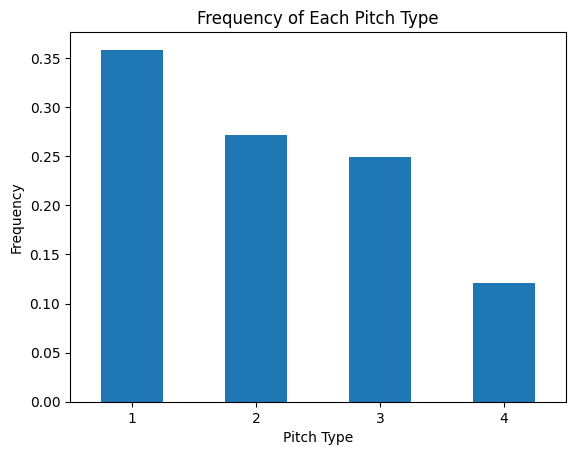

In [ ]:
pitch_counts = full_pitcher_df['simple_pitch_type_enc'].value_counts(normalize = True).sort_index()

# Plotting the bar plot
pitch_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Pitch Type')

plt.show()

In [ ]:
full_pitcher_df['zone'].value_counts()

,count
zone,
14.00,704109
13.00,549531
11.00,420040
4.00,381079
3.00,362343
12.00,312411
1.00,298279
2.00,283767


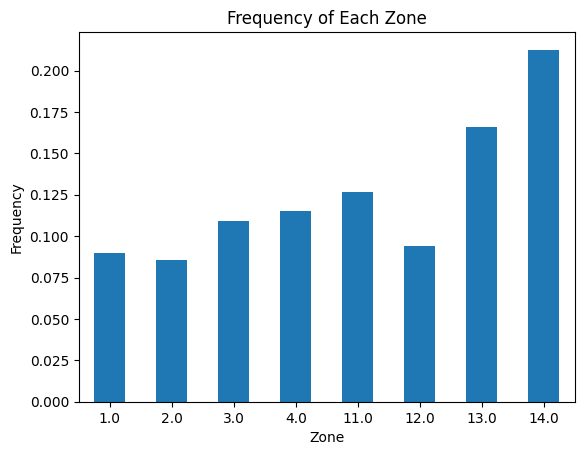

In [ ]:
zone_counts = full_pitcher_df['zone'].value_counts(normalize = True).sort_index()

# Plotting the bar plot
zone_counts.plot(kind='bar', rot=0)

# Adding labels and title
plt.xlabel('Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Each Zone')

plt.show()

In [ ]:
dictionary_pitch_class = {
  1:0,
  2:1,
  3:2,
  4:3,
  11:4,
  12:5,
  13:6,
  14:7,
}

In [ ]:
#Further encode zone columns to 1 and 0.
dictionary_zone01 = {
  1:1,
  2:1,
  3:1,
  4:1,
 11:0,
 12:0,
 13:0,
 14:0,
}

In [ ]:
new_class = [dictionary_zone01[class_name] for class_name in full_pitcher_df['zone']]
full_pitcher_df['zone'] = new_class

In [ ]:
new_class = [dictionary_pitch_class[class_name] for class_name in full_pitcher_df['simple_pitch_type_enc']]
full_pitcher_df['simple_pitch_type_enc'] = new_class

In [ ]:
full_pitcher_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311559 entries, 0 to 3311558
Data columns (total 69 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0.1                   int64  
 1   Unnamed: 0                     int64  
 2   px                             float64
 3   pz                             float64
 4   start_speed                    float64
 5   end_speed                      float64
 6   sz_bot                         float64
 7   sz_top                         float64
 8   zone                           int64  
 9   type                           object 
 10  b_score                        float64
 11  ab_id                          float64
 12  b_count                        float64
 13  s_count                        float64
 14  outs                           float64
 15  pitch_num                      float64
 16  on_1b                          float64
 17  on_2b                          float64
 18  on

Some of the columns need to be removed:
- speed : Human won't be able to measure the speed by bare eye.
- px & pz: We've converted this to 'zone' target
- o : This is the out *after* the pitch is thrown, which is a future event.
- type/simple_type: This is the result of the pitch, which is a future event.
- g_id/top : This is an indication/index of game progress. We are not using them to partitioning the dataset.
- simple_pitch_type: We've encoded this column.


In [ ]:
full_pitcher_df = full_pitcher_df.drop(columns = ['start_speed','end_speed','px','o','pz','Unnamed: 0','g_id','top','simple_pitch_type','Unnamed: 0.1','type','simple_type'])


##### Split Dataframe by at-bat

We are partitioning the dataset based on at-bat id. By doing this, we ensure that sequence are correctly generated with a start point and an end point.

In [ ]:
# Initialize the dictionary to store the data
ab_data_df = {}
ab_list = full_pitcher_df['ab_id'].unique()

for ab_number in ab_list:
    ab_data_df[ab_number] = full_pitcher_df[full_pitcher_df['ab_id'] == ab_number].drop(columns = ['ab_id','pitcher_id'])

##### Create Sequence

The purpose of creating sequence is to create sub_dataframe for every 3 pitches in each at bat.
If an at-bat has 5 pitches, then 3 dataframe will be generated: pitch 1-3, 2-4 and 3-5.

We will stick with 3 as sequence length regardless of any other hyper parameter training. The reason being that it take a long time to generate sequence, and 3 is a good balance between number of data generated and complexity of input data.

In [ ]:
seq_length = 3
target_columns = ['zone', 'simple_pitch_type_enc']
all_X, all_y = [], []

def create_sequences(df, seq_length, target_columns):
    xs, ys = [], []
    for i in range(len(df) - seq_length + 1):
        x = df.iloc[i:i + seq_length].drop(columns=target_columns).values
        y = df.iloc[i + seq_length - 1][target_columns].values
        xs.append(x)
        ys.append(y)
    # Reshape the arrays to ensure consistent dimensions
    return np.array(xs).reshape(-1, seq_length, df.shape[1] - len(target_columns)), np.array(ys)
for ab_id, data in ab_data_df.items():
    X, y = create_sequences(data, seq_length, target_columns)
    # Append only if sequences were created
    if X.size > 0:
       all_X.append(X)
       all_y.append(y)
#Combine all sequences and labels
# Handle the case where all_X might be empty
if all_X:
  X = np.concatenate(all_X)
  y = np.concatenate(all_y)
else:
    print("No sequences were created. Check your data and sequence length.")
    X = np.array([])
    y = np.array([])

In [ ]:
X

array([[[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ]],

       [[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.74, 3.35, 0.  , ..., 0.  , 0.  , 0.  ]],

       [[1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.74, 3.35, 0.  , ..., 0.  , 0.  , 0.  ],
        [1.72, 3.56, 0.  , ..., 0.  , 0.  , 0.  ]],

       ...,

       [[1.43, 3.24, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.62, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ]],

       [[1.62, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.65, 3.31, 4.  , ..., 0.  , 0.  , 0.  ]],

       [[1.58, 3.48, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.65, 3.31, 4.  , ..., 0.  , 0.  , 0.  ],
        [1.58, 3.31, 4.  , ..., 0.  , 0.  , 0.  ]]])

##### Train-Test Split, Tensorizing and Data loading

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Reshape to 2D for scaling (samples x (time steps * features))
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler().fit(X_train_2D)
X_train_scaled = scaler.transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

# Reshape back to 3D for your model (samples x time steps x features)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [ ]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test)

# Create DataLoader objects for bigger dataset
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##### Class Weight

When we are encoding the target variables, there is a class imbalance problems for both targets. Fastball accounts for 50% of the total pitches, and ball zone (zone 11-14) accounts for 67% of the total pitches. We should calculate the class weight and apply it to the weight loss, hoping it will improve the performance of the model.

In [ ]:
# Calculate class weights for output1 (8 classes)
classes1, counts1 = np.unique(y_train[:, 0], return_counts=True)
total_samples1 = len(y_train[:, 0])
class_weights1 = total_samples1 / (len(classes1) * counts1)
class_weights1 = torch.tensor(class_weights1, dtype=torch.float32)

# Calculate class weights for output2 (4 classes)
classes2, counts2 = np.unique(y_train[:, 1], return_counts=True)
total_samples2 = len(y_train[:, 1])
class_weights2 = total_samples2 / (len(classes2) * counts2)

if class_weights2.shape != (4,):
    class_weights2 = np.append(class_weights2, 0)
class_weights2 = torch.tensor(class_weights2, dtype=torch.float32)

##### RNN Model with Full data


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size1, output_size2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Shared fully connected layer with fewer neurons
        self.shared_fc = nn.Linear(hidden_size, hidden_size // 2)

        # Output-specific fully connected layers with increased capacity
        self.fc1 = nn.Linear(hidden_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size)

        self.out1 = nn.Linear(hidden_size, output_size1)
        self.out2 = nn.Linear(hidden_size, output_size2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        # Shared layer
        shared_out = F.relu(self.shared_fc(out))
        #out1 = F.relu(self.fc1(out))

        # Output 1 branch with increased capacity
        out1 = F.relu(self.fc1(shared_out))
        out1 = self.dropout1(out1)
        out1 = self.out1(out1)

        # Output 2 branch with increased capacity
        out2 = F.relu(self.fc2(shared_out))
        #out2 = F.relu(self.fc2(out))
        out2 = self.dropout2(out2)
        out2 = self.out2(out2)

        return out1, out2

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size1 = 2  # Number of classes for the first target
output_size2 = 4  # Number of classes for the second target

# Initialize and print the model
baseline_RNN_full_01_model = RNNModel(input_size, hidden_size, output_size1, output_size2)
print(baseline_RNN_full_01_model)




RNNModel(
  (rnn): RNN(53, 50, batch_first=True)
  (shared_fc): Linear(in_features=50, out_features=25, bias=True)
  (fc1): Linear(in_features=25, out_features=50, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=2, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


##### Training



In [ ]:
import torch.optim as optim

# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss(weight=class_weights1)  # For output1 with 2 classes
criterion2 = nn.CrossEntropyLoss(weight=class_weights2)  # For output2 with 4 classes
optimizer = optim.Adam(baseline_RNN_full_01_model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    baseline_RNN_full_01_model.train()
    optimizer.zero_grad()
    outputs1, outputs2 = baseline_RNN_full_01_model(X_train_tensor)

    # Subtract 1 from y_train_tensor to shift the labels to the range 0-12
    loss1 = criterion1(outputs1, (y_train_tensor[:, 0]).long())
    loss2 = criterion2(outputs2, (y_train_tensor[:, 1]).long())

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 2.091912031173706
Epoch 2/20, Loss: 2.0890703201293945
Epoch 3/20, Loss: 2.0864148139953613
Epoch 4/20, Loss: 2.083909034729004
Epoch 5/20, Loss: 2.0816397666931152
Epoch 6/20, Loss: 2.079282760620117
Epoch 7/20, Loss: 2.0769283771514893
Epoch 8/20, Loss: 2.074824571609497
Epoch 9/20, Loss: 2.072507381439209
Epoch 10/20, Loss: 2.070279598236084
Epoch 11/20, Loss: 2.0679917335510254
Epoch 12/20, Loss: 2.065504312515259
Epoch 13/20, Loss: 2.062868118286133
Epoch 14/20, Loss: 2.0599396228790283
Epoch 15/20, Loss: 2.057039499282837
Epoch 16/20, Loss: 2.054025888442993
Epoch 17/20, Loss: 2.050832509994507
Epoch 18/20, Loss: 2.0472092628479004
Epoch 19/20, Loss: 2.043383836746216
Epoch 20/20, Loss: 2.0394885540008545


##### Evaluation

We will look evaluate the model with loss, accuracy and review of raw output.

###### Training Loss v.s. Test Loss

In [ ]:
baseline_RNN_full_01_model.eval()
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_01_model(X_test_tensor) # Unpack both outputs of the model
    y_train_pred1, y_train_pred2 = baseline_RNN_full_01_model(X_train_tensor) # Unpack both outputs of the model
    train_loss1 = criterion1(y_train_pred1, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    train_loss2 = criterion2(y_train_pred2, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Train Loss 1: {train_loss1.item():.4f}, Train Loss 2: {train_loss2.item():.4f}')
    # Assuming y_test_tensor also needs to be split for two outputs
    test_loss1 = criterion1(y_pred1, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    test_loss2 = criterion2(y_pred2, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Test Loss 1: {test_loss1.item():.4f}, Test Loss 2: {test_loss2.item():.4f}')

Train Loss 1: 0.6901, Train Loss 2: 1.3917
Test Loss 1: 0.6900, Test Loss 2: 1.3915


When fine tuning the model, we will see if the loss is reduced.

###### Accuracy Score

We should compare the predicted value of both target variables with the actual value to get the accuracy score. This also helps with real-life application

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_01_model(X_test_tensor)

    # Check if y_test needs to be split for two outputs and adjust accordingly
    # For example, if y_test is a 2D array where each row represents multiple labels:
    y_test_1 = y_test[:, 0]  # Assuming the first column corresponds to the first output
    y_test_2 = y_test[:, 1]  # Assuming the second column corresponds to the second output

    # Convert model outputs to class predictions
    classification1 = y_pred1.argmax(dim=1).cpu().numpy()
    classification2 = y_pred2.argmax(dim=1).cpu().numpy()

# Calculate accuracy for each output separately
accuracy1 = accuracy_score(y_test_1, classification1)
accuracy2 = accuracy_score(y_test_2, classification2)

print(f"Accuracy score on test set for Zone Prediction: {round(accuracy1 * 100, 2)}%")
print(f"Accuracy score on test set for Pitch Prediction: {round(accuracy2 * 100, 2)}%")

Accuracy score on test set for Zone Prediction: 54.27%
Accuracy score on test set for Pitch Prediction: 40.18%


In [ ]:
print(f"Classification report for zone prediction")
print(classification_report(y_test_1, classification1))
print(f"Classification report for pitch type prediction")
print(classification_report(y_test_2, classification2))

Classification report for zone prediction
              precision    recall  f1-score   support

         0.0       0.69      0.47      0.56    208780
         1.0       0.44      0.66      0.53    131585

    accuracy                           0.54    340365
   macro avg       0.56      0.56      0.54    340365
weighted avg       0.59      0.54      0.55    340365

Classification report for pitch type prediction
              precision    recall  f1-score   support

         0.0       0.53      0.32      0.40    121924
         1.0       0.38      0.47      0.42     94788
         2.0       0.42      0.54      0.47     79009
         3.0       0.22      0.25      0.24     44644

    accuracy                           0.40    340365
   macro avg       0.39      0.39      0.38    340365
weighted avg       0.42      0.40      0.40    340365



#### Fine Tuning

We will attempt some quick fine tuning to see where the limits are.

##### RNN Model with Full data


In the model, I added another shared layer in hope to capture more complex pattern.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size1, output_size2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Shared fully connected layer with fewer neurons
        self.shared_fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.shared_fc2 = nn.Linear(hidden_size // 2, hidden_size // 4) # New layer

        # Output-specific fully connected layers with increased capacity
        self.fc1 = nn.Linear(hidden_size // 4, hidden_size)
        self.fc2 = nn.Linear(hidden_size // 4, hidden_size)

        self.out1 = nn.Linear(hidden_size, output_size1)
        self.out2 = nn.Linear(hidden_size, output_size2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        # Shared layer
        shared_out = F.relu(self.shared_fc1(out)) # Use shared_fc1 here
        shared_out = F.relu(self.shared_fc2(shared_out)) # Use shared_fc2 here

        # Output 1 branch with increased capacity
        out1 = F.relu(self.fc1(shared_out))
        out1 = self.dropout1(out1)
        out1 = self.out1(out1)

        # Output 2 branch with increased capacity
        out2 = F.relu(self.fc2(shared_out))
        #out2 = F.relu(self.fc2(out))
        out2 = self.dropout2(out2)
        out2 = self.out2(out2)

        return out1, out2

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size1 = 2  # Number of classes for the first target
output_size2 = 4  # Number of classes for the second target

# Initialize and print the model
baseline_RNN_full_01_model = RNNModel(input_size, hidden_size, output_size1, output_size2)
print(baseline_RNN_full_01_model)




RNNModel(
  (rnn): RNN(53, 50, batch_first=True)
  (shared_fc1): Linear(in_features=50, out_features=25, bias=True)
  (shared_fc2): Linear(in_features=25, out_features=12, bias=True)
  (fc1): Linear(in_features=12, out_features=50, bias=True)
  (fc2): Linear(in_features=12, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=2, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


##### Training



In training section, I have added a learning rate scheduler. It will reduce the learning rate when the model can't improve further. We will set 30 as epoch limit due to computing power.

In [ ]:
import torch.optim as optim
# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss(weight=class_weights1)  # For output1 with 2 classes
criterion2 = nn.CrossEntropyLoss(weight=class_weights2)  # For output2 with 4 classes
optimizer = optim.Adam(baseline_RNN_full_01_model.parameters(), lr=0.001)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    baseline_RNN_full_01_model.train()
    optimizer.zero_grad()

    outputs1, outputs2 = baseline_RNN_full_01_model(X_train_tensor)

    # Subtract 1 from y_train_tensor to shift the labels to the range 0-12
    loss1 = criterion1(outputs1, (y_train_tensor[:, 0]).long())
    loss2 = criterion2(outputs2, (y_train_tensor[:, 1]).long())

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    # Step the scheduler
    scheduler.step(loss)

    # Print loss and current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, LR: {current_lr}')


Epoch 1/30, Loss: 2.0900330543518066, LR: 0.001
Epoch 2/30, Loss: 2.0883982181549072, LR: 0.001
Epoch 3/30, Loss: 2.0868287086486816, LR: 0.001
Epoch 4/30, Loss: 2.0854456424713135, LR: 0.001
Epoch 5/30, Loss: 2.084129571914673, LR: 0.001
Epoch 6/30, Loss: 2.0828638076782227, LR: 0.001
Epoch 7/30, Loss: 2.0816595554351807, LR: 0.001
Epoch 8/30, Loss: 2.0805230140686035, LR: 0.001
Epoch 9/30, Loss: 2.079411745071411, LR: 0.001
Epoch 10/30, Loss: 2.0782814025878906, LR: 0.001
Epoch 11/30, Loss: 2.07735013961792, LR: 0.001
Epoch 12/30, Loss: 2.0762181282043457, LR: 0.001
Epoch 13/30, Loss: 2.075186252593994, LR: 0.001
Epoch 14/30, Loss: 2.074010133743286, LR: 0.001
Epoch 15/30, Loss: 2.0728917121887207, LR: 0.001
Epoch 16/30, Loss: 2.0716552734375, LR: 0.001
Epoch 17/30, Loss: 2.070453405380249, LR: 0.001
Epoch 18/30, Loss: 2.0690412521362305, LR: 0.001
Epoch 19/30, Loss: 2.067481279373169, LR: 0.001
Epoch 20/30, Loss: 2.065720319747925, LR: 0.001
Epoch 21/30, Loss: 2.063908815383911, LR:

##### Evaluation

We will look evaluate the model with loss, accuracy and review of raw output.

###### Training Loss v.s. Test Loss

In [ ]:
baseline_RNN_full_01_model.eval()
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_01_model(X_test_tensor) # Unpack both outputs of the model
    y_train_pred1, y_train_pred2 = baseline_RNN_full_01_model(X_train_tensor) # Unpack both outputs of the model
    train_loss1 = criterion1(y_train_pred1, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    train_loss2 = criterion2(y_train_pred2, y_train_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Train Loss 1: {train_loss1.item():.4f}, Train Loss 2: {train_loss2.item():.4f}')
    # Assuming y_test_tensor also needs to be split for two outputs
    test_loss1 = criterion1(y_pred1, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    test_loss2 = criterion2(y_pred2, y_test_tensor.argmax(dim=1)) # Adjust slicing if needed
    print(f'Test Loss 1: {test_loss1.item():.4f}, Test Loss 2: {test_loss2.item():.4f}')

Train Loss 1: 0.7022, Train Loss 2: 1.3603
Test Loss 1: 0.7021, Test Loss 2: 1.3600


When fine tuning the model, we will see if the loss is reduced.

###### Accuracy Score

We should compare the predicted value of both target variables with the actual value to get the accuracy score. This also helps with real-life application

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions
with torch.no_grad():
    y_pred1, y_pred2 = baseline_RNN_full_01_model(X_test_tensor)

    # Check if y_test needs to be split for two outputs and adjust accordingly
    # For example, if y_test is a 2D array where each row represents multiple labels:
    y_test_1 = y_test[:, 0]  # Assuming the first column corresponds to the first output
    y_test_2 = y_test[:, 1]  # Assuming the second column corresponds to the second output

    # Convert model outputs to class predictions
    classification1 = y_pred1.argmax(dim=1).cpu().numpy()
    classification2 = y_pred2.argmax(dim=1).cpu().numpy()

# Calculate accuracy for each output separately
accuracy1 = accuracy_score(y_test_1, classification1)
accuracy2 = accuracy_score(y_test_2, classification2)

print(f"Accuracy score on test set for Zone Prediction: {round(accuracy1 * 100, 2)}%")
print(f"Accuracy score on test set for Pitch Prediction: {round(accuracy2 * 100, 2)}%")

Accuracy score on test set for Zone Prediction: 54.93%
Accuracy score on test set for Pitch Prediction: 43.06%


In [ ]:
print(f"Classification report for zone prediction")
print(classification_report(y_test_1, classification1))
print(f"Classification report for pitch type prediction")
print(classification_report(y_test_2, classification2))

Classification report for zone prediction
              precision    recall  f1-score   support

         0.0       0.68      0.50      0.58    208780
         1.0       0.44      0.62      0.52    131585

    accuracy                           0.55    340365
   macro avg       0.56      0.56      0.55    340365
weighted avg       0.59      0.55      0.55    340365

Classification report for pitch type prediction
              precision    recall  f1-score   support

         0.0       0.48      0.64      0.55    121924
         1.0       0.40      0.09      0.15     94788
         2.0       0.41      0.66      0.51     79009
         3.0       0.25      0.17      0.20     44644

    accuracy                           0.43    340365
   macro avg       0.39      0.39      0.35    340365
weighted avg       0.41      0.43      0.38    340365



Comparing to the previous model, this updated RNN model has a higher accuracy on pitch type prediction. The recall score on four-seams and breaking ball is boosted. Unfortunately, it is at the cost of a much lower recall score on other fastballs and off speed pitch.

It's hard to decide which model is better. We will leave it for further tuning and more high-quality data.

#### Saving model

In [ ]:
import torch

# Save the entire model as a .pkl file
torch.save(baseline_RNN_full_01_model, 'rnn_model.pkl')